In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 375443 images
Dataset type val label type: species


Loaded 48562 images
Dataset type test label type: species


Loaded 48790 images
Dataset type test label type: species


Loaded 0 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 hu88k90i


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_e_u = []
trn_e_v = []
trn_rcn = []
trn_tgt = []

val_inp = []
val_e_u = []
val_e_v = []
val_rcn = []
val_tgt = []

ind_inp = []
ind_e_u = []
ind_e_v = []
ind_rcn = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_e_u = []
    ood_e_v = []
    ood_rcn = []
    ood_tgt = []

rnd_inp = []
rnd_e_u = []
rnd_e_v = []
rnd_rcn = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_e_u.extend(e_u.detach().cpu().numpy())
    trn_e_v.extend(e_v.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_e_u.extend(e_u.detach().cpu().numpy())
    val_e_v.extend(e_v.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_e_u.extend(e_u.detach().cpu().numpy())
    ind_e_v.extend(e_v.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_e_u.extend(e_u.detach().cpu().numpy())
        ood_e_v.extend(e_v.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_e_u.extend(e_u.detach().cpu().numpy())
    rnd_e_v.extend(e_v.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                        | 0/5867 [00:00<?, ?it/s]

  0%|                                                                                              | 1/5867 [00:01<1:38:25,  1.01s/it]

  0%|                                                                                                | 3/5867 [00:01<29:27,  3.32it/s]

  0%|                                                                                                | 5/5867 [00:01<16:54,  5.78it/s]

  0%|                                                                                                | 7/5867 [00:01<11:50,  8.25it/s]

  0%|▏                                                                                               | 9/5867 [00:01<09:15, 10.55it/s]

  0%|▏                                                                                              | 11/5867 [00:01<07:45, 12.58it/s]

  0%|▏                                                                                              | 13/5867 [00:01<06:51, 14.24it/s]

  0%|▏                                                                                              | 15/5867 [00:01<06:16, 15.56it/s]

  0%|▎                                                                                              | 17/5867 [00:01<05:52, 16.58it/s]

  0%|▎                                                                                              | 19/5867 [00:01<05:37, 17.32it/s]

  0%|▎                                                                                              | 21/5867 [00:02<05:27, 17.85it/s]

  0%|▎                                                                                              | 23/5867 [00:02<05:21, 18.20it/s]

  0%|▍                                                                                              | 25/5867 [00:02<05:15, 18.53it/s]

  0%|▍                                                                                              | 27/5867 [00:02<05:11, 18.73it/s]

  0%|▍                                                                                              | 29/5867 [00:02<05:08, 18.91it/s]

  1%|▌                                                                                              | 31/5867 [00:02<05:06, 19.04it/s]

  1%|▌                                                                                              | 33/5867 [00:02<05:05, 19.10it/s]

  1%|▌                                                                                              | 35/5867 [00:02<05:05, 19.10it/s]

  1%|▌                                                                                              | 37/5867 [00:02<05:04, 19.12it/s]

  1%|▋                                                                                              | 39/5867 [00:02<05:04, 19.16it/s]

  1%|▋                                                                                              | 41/5867 [00:03<05:04, 19.16it/s]

  1%|▋                                                                                              | 43/5867 [00:03<05:03, 19.16it/s]

  1%|▋                                                                                              | 45/5867 [00:03<05:03, 19.17it/s]

  1%|▊                                                                                              | 47/5867 [00:03<05:03, 19.19it/s]

  1%|▊                                                                                              | 49/5867 [00:03<05:03, 19.14it/s]

  1%|▊                                                                                              | 51/5867 [00:03<05:03, 19.17it/s]

  1%|▊                                                                                              | 53/5867 [00:03<05:02, 19.20it/s]

  1%|▉                                                                                              | 55/5867 [00:03<05:02, 19.19it/s]

  1%|▉                                                                                              | 57/5867 [00:03<05:02, 19.23it/s]

  1%|▉                                                                                              | 59/5867 [00:04<05:02, 19.23it/s]

  1%|▉                                                                                              | 61/5867 [00:04<05:02, 19.20it/s]

  1%|█                                                                                              | 63/5867 [00:04<05:02, 19.16it/s]

  1%|█                                                                                              | 65/5867 [00:04<05:03, 19.14it/s]

  1%|█                                                                                              | 67/5867 [00:04<05:03, 19.10it/s]

  1%|█                                                                                              | 69/5867 [00:04<05:03, 19.09it/s]

  1%|█▏                                                                                             | 71/5867 [00:04<05:03, 19.11it/s]

  1%|█▏                                                                                             | 73/5867 [00:04<05:02, 19.17it/s]

  1%|█▏                                                                                             | 75/5867 [00:04<05:00, 19.25it/s]

  1%|█▏                                                                                             | 77/5867 [00:04<05:00, 19.27it/s]

  1%|█▎                                                                                             | 79/5867 [00:05<04:59, 19.31it/s]

  1%|█▎                                                                                             | 81/5867 [00:05<04:59, 19.33it/s]

  1%|█▎                                                                                             | 83/5867 [00:05<04:59, 19.34it/s]

  1%|█▍                                                                                             | 85/5867 [00:05<04:58, 19.34it/s]

  1%|█▍                                                                                             | 87/5867 [00:05<04:58, 19.36it/s]

  2%|█▍                                                                                             | 89/5867 [00:05<04:58, 19.37it/s]

  2%|█▍                                                                                             | 91/5867 [00:05<04:58, 19.35it/s]

  2%|█▌                                                                                             | 93/5867 [00:05<04:58, 19.36it/s]

  2%|█▌                                                                                             | 95/5867 [00:05<04:58, 19.37it/s]

  2%|█▌                                                                                             | 97/5867 [00:05<04:57, 19.42it/s]

  2%|█▌                                                                                             | 99/5867 [00:06<04:56, 19.43it/s]

  2%|█▌                                                                                            | 101/5867 [00:06<04:55, 19.49it/s]

  2%|█▋                                                                                            | 103/5867 [00:06<04:55, 19.53it/s]

  2%|█▋                                                                                            | 105/5867 [00:06<04:54, 19.56it/s]

  2%|█▋                                                                                            | 107/5867 [00:06<04:53, 19.59it/s]

  2%|█▋                                                                                            | 109/5867 [00:06<04:53, 19.64it/s]

  2%|█▊                                                                                            | 111/5867 [00:06<04:52, 19.67it/s]

  2%|█▊                                                                                            | 113/5867 [00:06<04:52, 19.67it/s]

  2%|█▊                                                                                            | 115/5867 [00:06<04:51, 19.70it/s]

  2%|█▊                                                                                            | 117/5867 [00:07<04:51, 19.72it/s]

  2%|█▉                                                                                            | 119/5867 [00:07<04:51, 19.72it/s]

  2%|█▉                                                                                            | 121/5867 [00:07<04:51, 19.69it/s]

  2%|█▉                                                                                            | 123/5867 [00:07<04:51, 19.71it/s]

  2%|██                                                                                            | 125/5867 [00:07<04:51, 19.72it/s]

  2%|██                                                                                            | 127/5867 [00:07<04:51, 19.70it/s]

  2%|██                                                                                            | 129/5867 [00:07<04:50, 19.72it/s]

  2%|██                                                                                            | 131/5867 [00:07<04:50, 19.73it/s]

  2%|██▏                                                                                           | 133/5867 [00:07<04:50, 19.73it/s]

  2%|██▏                                                                                           | 135/5867 [00:07<04:50, 19.71it/s]

  2%|██▏                                                                                           | 137/5867 [00:08<04:50, 19.72it/s]

  2%|██▏                                                                                           | 139/5867 [00:08<04:50, 19.71it/s]

  2%|██▎                                                                                           | 141/5867 [00:08<04:50, 19.69it/s]

  2%|██▎                                                                                           | 143/5867 [00:08<04:50, 19.71it/s]

  2%|██▎                                                                                           | 145/5867 [00:08<04:50, 19.71it/s]

  3%|██▎                                                                                           | 147/5867 [00:08<04:50, 19.72it/s]

  3%|██▍                                                                                           | 149/5867 [00:08<04:50, 19.68it/s]

  3%|██▍                                                                                           | 151/5867 [00:08<04:50, 19.69it/s]

  3%|██▍                                                                                           | 153/5867 [00:08<04:50, 19.66it/s]

  3%|██▍                                                                                           | 155/5867 [00:08<04:51, 19.61it/s]

  3%|██▌                                                                                           | 157/5867 [00:09<04:51, 19.58it/s]

  3%|██▌                                                                                           | 159/5867 [00:09<04:51, 19.55it/s]

  3%|██▌                                                                                           | 161/5867 [00:09<04:52, 19.51it/s]

  3%|██▌                                                                                           | 163/5867 [00:09<04:52, 19.47it/s]

  3%|██▋                                                                                           | 165/5867 [00:09<04:52, 19.47it/s]

  3%|██▋                                                                                           | 167/5867 [00:09<04:52, 19.46it/s]

  3%|██▋                                                                                           | 169/5867 [00:09<04:53, 19.44it/s]

  3%|██▋                                                                                           | 171/5867 [00:09<04:52, 19.45it/s]

  3%|██▊                                                                                           | 173/5867 [00:09<04:52, 19.46it/s]

  3%|██▊                                                                                           | 175/5867 [00:09<04:52, 19.47it/s]

  3%|██▊                                                                                           | 177/5867 [00:10<04:52, 19.44it/s]

  3%|██▊                                                                                           | 179/5867 [00:10<04:52, 19.45it/s]

  3%|██▉                                                                                           | 181/5867 [00:10<04:52, 19.44it/s]

  3%|██▉                                                                                           | 183/5867 [00:10<04:52, 19.43it/s]

  3%|██▉                                                                                           | 185/5867 [00:10<04:52, 19.44it/s]

  3%|██▉                                                                                           | 187/5867 [00:10<04:52, 19.44it/s]

  3%|███                                                                                           | 189/5867 [00:10<04:51, 19.46it/s]

  3%|███                                                                                           | 191/5867 [00:10<04:51, 19.45it/s]

  3%|███                                                                                           | 193/5867 [00:10<04:51, 19.47it/s]

  3%|███                                                                                           | 195/5867 [00:10<04:51, 19.47it/s]

  3%|███▏                                                                                          | 197/5867 [00:11<04:51, 19.45it/s]

  3%|███▏                                                                                          | 199/5867 [00:11<04:51, 19.44it/s]

  3%|███▏                                                                                          | 201/5867 [00:11<04:51, 19.44it/s]

  3%|███▎                                                                                          | 203/5867 [00:11<04:51, 19.42it/s]

  3%|███▎                                                                                          | 205/5867 [00:11<04:51, 19.42it/s]

  4%|███▎                                                                                          | 207/5867 [00:11<04:51, 19.40it/s]

  4%|███▎                                                                                          | 209/5867 [00:11<04:51, 19.39it/s]

  4%|███▍                                                                                          | 211/5867 [00:11<04:51, 19.38it/s]

  4%|███▍                                                                                          | 213/5867 [00:11<04:53, 19.27it/s]

  4%|███▍                                                                                          | 215/5867 [00:12<04:53, 19.27it/s]

  4%|███▍                                                                                          | 217/5867 [00:12<04:53, 19.23it/s]

  4%|███▌                                                                                          | 219/5867 [00:12<04:54, 19.20it/s]

  4%|███▌                                                                                          | 221/5867 [00:12<04:53, 19.21it/s]

  4%|███▌                                                                                          | 223/5867 [00:12<04:53, 19.22it/s]

  4%|███▌                                                                                          | 225/5867 [00:12<04:53, 19.22it/s]

  4%|███▋                                                                                          | 227/5867 [00:12<04:53, 19.22it/s]

  4%|███▋                                                                                          | 229/5867 [00:12<04:53, 19.23it/s]

  4%|███▋                                                                                          | 231/5867 [00:12<04:53, 19.23it/s]

  4%|███▋                                                                                          | 233/5867 [00:12<04:53, 19.16it/s]

  4%|███▊                                                                                          | 235/5867 [00:13<04:54, 19.13it/s]

  4%|███▊                                                                                          | 237/5867 [00:13<04:54, 19.15it/s]

  4%|███▊                                                                                          | 239/5867 [00:13<04:53, 19.18it/s]

  4%|███▊                                                                                          | 241/5867 [00:13<04:53, 19.20it/s]

  4%|███▉                                                                                          | 243/5867 [00:13<04:52, 19.25it/s]

  4%|███▉                                                                                          | 245/5867 [00:13<04:51, 19.28it/s]

  4%|███▉                                                                                          | 247/5867 [00:13<04:51, 19.28it/s]

  4%|███▉                                                                                          | 249/5867 [00:13<04:51, 19.24it/s]

  4%|████                                                                                          | 251/5867 [00:13<04:52, 19.23it/s]

  4%|████                                                                                          | 253/5867 [00:14<04:51, 19.25it/s]

  4%|████                                                                                          | 255/5867 [00:14<04:51, 19.26it/s]

  4%|████                                                                                          | 257/5867 [00:14<04:51, 19.25it/s]

  4%|████▏                                                                                         | 259/5867 [00:14<04:51, 19.26it/s]

  4%|████▏                                                                                         | 261/5867 [00:14<04:51, 19.26it/s]

  4%|████▏                                                                                         | 263/5867 [00:14<04:50, 19.26it/s]

  5%|████▏                                                                                         | 265/5867 [00:14<04:51, 19.23it/s]

  5%|████▎                                                                                         | 267/5867 [00:14<04:51, 19.23it/s]

  5%|████▎                                                                                         | 269/5867 [00:14<04:50, 19.25it/s]

  5%|████▎                                                                                         | 271/5867 [00:14<04:50, 19.23it/s]

  5%|████▎                                                                                         | 273/5867 [00:15<04:50, 19.24it/s]

  5%|████▍                                                                                         | 275/5867 [00:15<04:50, 19.24it/s]

  5%|████▍                                                                                         | 277/5867 [00:15<04:51, 19.20it/s]

  5%|████▍                                                                                         | 279/5867 [00:15<04:51, 19.18it/s]

  5%|████▌                                                                                         | 281/5867 [00:15<04:51, 19.14it/s]

  5%|████▌                                                                                         | 283/5867 [00:15<04:51, 19.14it/s]

  5%|████▌                                                                                         | 285/5867 [00:15<04:51, 19.12it/s]

  5%|████▌                                                                                         | 287/5867 [00:15<04:51, 19.13it/s]

  5%|████▋                                                                                         | 289/5867 [00:15<04:51, 19.12it/s]

  5%|████▋                                                                                         | 291/5867 [00:15<04:51, 19.13it/s]

  5%|████▋                                                                                         | 293/5867 [00:16<04:51, 19.13it/s]

  5%|████▋                                                                                         | 295/5867 [00:16<04:51, 19.14it/s]

  5%|████▊                                                                                         | 297/5867 [00:16<04:51, 19.13it/s]

  5%|████▊                                                                                         | 299/5867 [00:16<04:51, 19.10it/s]

  5%|████▊                                                                                         | 301/5867 [00:16<04:51, 19.10it/s]

  5%|████▊                                                                                         | 303/5867 [00:16<04:51, 19.10it/s]

  5%|████▉                                                                                         | 305/5867 [00:16<04:51, 19.10it/s]

  5%|████▉                                                                                         | 307/5867 [00:16<04:51, 19.07it/s]

  5%|████▉                                                                                         | 309/5867 [00:16<04:51, 19.05it/s]

  5%|████▉                                                                                         | 311/5867 [00:17<04:51, 19.03it/s]

  5%|█████                                                                                         | 313/5867 [00:17<04:52, 18.99it/s]

  5%|█████                                                                                         | 315/5867 [00:17<04:52, 18.98it/s]

  5%|█████                                                                                         | 317/5867 [00:17<04:52, 19.00it/s]

  5%|█████                                                                                         | 319/5867 [00:17<04:51, 19.03it/s]

  5%|█████▏                                                                                        | 321/5867 [00:17<04:51, 19.00it/s]

  6%|█████▏                                                                                        | 323/5867 [00:17<04:52, 18.98it/s]

  6%|█████▏                                                                                        | 325/5867 [00:17<04:52, 18.97it/s]

  6%|█████▏                                                                                        | 327/5867 [00:17<04:52, 18.96it/s]

  6%|█████▎                                                                                        | 329/5867 [00:17<04:52, 18.91it/s]

  6%|█████▎                                                                                        | 331/5867 [00:18<04:52, 18.91it/s]

  6%|█████▎                                                                                        | 333/5867 [00:18<04:52, 18.90it/s]

  6%|█████▎                                                                                        | 335/5867 [00:18<04:52, 18.89it/s]

  6%|█████▍                                                                                        | 337/5867 [00:18<04:52, 18.93it/s]

  6%|█████▍                                                                                        | 339/5867 [00:18<04:51, 18.96it/s]

  6%|█████▍                                                                                        | 341/5867 [00:18<04:51, 18.98it/s]

  6%|█████▍                                                                                        | 343/5867 [00:18<04:51, 18.97it/s]

  6%|█████▌                                                                                        | 345/5867 [00:18<04:50, 18.98it/s]

  6%|█████▌                                                                                        | 347/5867 [00:18<04:50, 18.99it/s]

  6%|█████▌                                                                                        | 349/5867 [00:19<04:50, 19.00it/s]

  6%|█████▌                                                                                        | 351/5867 [00:19<04:50, 19.02it/s]

  6%|█████▋                                                                                        | 353/5867 [00:19<04:49, 19.03it/s]

  6%|█████▋                                                                                        | 355/5867 [00:19<04:49, 19.03it/s]

  6%|█████▋                                                                                        | 357/5867 [00:19<04:49, 19.04it/s]

  6%|█████▊                                                                                        | 359/5867 [00:19<04:48, 19.08it/s]

  6%|█████▊                                                                                        | 361/5867 [00:19<04:48, 19.08it/s]

  6%|█████▊                                                                                        | 363/5867 [00:19<04:47, 19.12it/s]

  6%|█████▊                                                                                        | 365/5867 [00:19<04:47, 19.13it/s]

  6%|█████▉                                                                                        | 367/5867 [00:19<04:47, 19.15it/s]

  6%|█████▉                                                                                        | 369/5867 [00:20<04:46, 19.16it/s]

  6%|█████▉                                                                                        | 371/5867 [00:20<04:46, 19.17it/s]

  6%|█████▉                                                                                        | 373/5867 [00:20<04:46, 19.14it/s]

  6%|██████                                                                                        | 375/5867 [00:20<04:48, 19.05it/s]

  6%|██████                                                                                        | 377/5867 [00:20<04:48, 19.04it/s]

  6%|██████                                                                                        | 379/5867 [00:20<04:48, 19.03it/s]

  6%|██████                                                                                        | 381/5867 [00:20<04:47, 19.07it/s]

  7%|██████▏                                                                                       | 383/5867 [00:20<04:47, 19.10it/s]

  7%|██████▏                                                                                       | 385/5867 [00:20<04:46, 19.13it/s]

  7%|██████▏                                                                                       | 387/5867 [00:21<04:46, 19.15it/s]

  7%|██████▏                                                                                       | 389/5867 [00:21<04:46, 19.13it/s]

  7%|██████▎                                                                                       | 391/5867 [00:21<04:46, 19.10it/s]

  7%|██████▎                                                                                       | 393/5867 [00:21<04:47, 19.03it/s]

  7%|██████▎                                                                                       | 395/5867 [00:21<04:47, 19.03it/s]

  7%|██████▎                                                                                       | 397/5867 [00:21<04:47, 19.04it/s]

  7%|██████▍                                                                                       | 399/5867 [00:21<04:46, 19.07it/s]

  7%|██████▍                                                                                       | 401/5867 [00:21<04:46, 19.10it/s]

  7%|██████▍                                                                                       | 403/5867 [00:21<04:46, 19.08it/s]

  7%|██████▍                                                                                       | 405/5867 [00:21<04:46, 19.08it/s]

  7%|██████▌                                                                                       | 407/5867 [00:22<04:46, 19.09it/s]

  7%|██████▌                                                                                       | 409/5867 [00:22<04:45, 19.09it/s]

  7%|██████▌                                                                                       | 411/5867 [00:22<04:45, 19.13it/s]

  7%|██████▌                                                                                       | 413/5867 [00:22<04:44, 19.18it/s]

  7%|██████▋                                                                                       | 415/5867 [00:22<04:43, 19.21it/s]

  7%|██████▋                                                                                       | 417/5867 [00:22<04:43, 19.21it/s]

  7%|██████▋                                                                                       | 419/5867 [00:22<04:43, 19.24it/s]

  7%|██████▋                                                                                       | 421/5867 [00:22<04:42, 19.26it/s]

  7%|██████▊                                                                                       | 423/5867 [00:22<04:42, 19.26it/s]

  7%|██████▊                                                                                       | 425/5867 [00:23<04:42, 19.23it/s]

  7%|██████▊                                                                                       | 427/5867 [00:23<04:42, 19.26it/s]

  7%|██████▊                                                                                       | 429/5867 [00:23<04:42, 19.26it/s]

  7%|██████▉                                                                                       | 431/5867 [00:23<04:42, 19.23it/s]

  7%|██████▉                                                                                       | 433/5867 [00:23<04:42, 19.22it/s]

  7%|██████▉                                                                                       | 435/5867 [00:23<04:42, 19.22it/s]

  7%|███████                                                                                       | 437/5867 [00:23<04:43, 19.17it/s]

  7%|███████                                                                                       | 439/5867 [00:23<04:43, 19.14it/s]

  8%|███████                                                                                       | 441/5867 [00:23<04:43, 19.12it/s]

  8%|███████                                                                                       | 443/5867 [00:23<04:43, 19.11it/s]

  8%|███████▏                                                                                      | 445/5867 [00:24<04:44, 19.06it/s]

  8%|███████▏                                                                                      | 447/5867 [00:24<04:44, 19.05it/s]

  8%|███████▏                                                                                      | 449/5867 [00:24<04:44, 19.05it/s]

  8%|███████▏                                                                                      | 451/5867 [00:24<04:44, 19.04it/s]

  8%|███████▎                                                                                      | 453/5867 [00:24<04:44, 19.02it/s]

  8%|███████▎                                                                                      | 455/5867 [00:24<04:45, 18.97it/s]

  8%|███████▎                                                                                      | 457/5867 [00:24<04:45, 18.95it/s]

  8%|███████▎                                                                                      | 459/5867 [00:24<04:44, 18.98it/s]

  8%|███████▍                                                                                      | 461/5867 [00:24<04:44, 19.01it/s]

  8%|███████▍                                                                                      | 463/5867 [00:25<04:44, 19.00it/s]

  8%|███████▍                                                                                      | 465/5867 [00:25<04:45, 18.95it/s]

  8%|███████▍                                                                                      | 467/5867 [00:25<04:44, 18.95it/s]

  8%|███████▌                                                                                      | 469/5867 [00:25<04:43, 19.04it/s]

  8%|███████▌                                                                                      | 471/5867 [00:25<04:42, 19.09it/s]

  8%|███████▌                                                                                      | 473/5867 [00:25<04:43, 19.06it/s]

  8%|███████▌                                                                                      | 475/5867 [00:25<04:43, 19.05it/s]

  8%|███████▋                                                                                      | 477/5867 [00:25<04:43, 19.04it/s]

  8%|███████▋                                                                                      | 479/5867 [00:25<04:43, 19.02it/s]

  8%|███████▋                                                                                      | 481/5867 [00:25<04:42, 19.06it/s]

  8%|███████▋                                                                                      | 483/5867 [00:26<04:42, 19.06it/s]

  8%|███████▊                                                                                      | 485/5867 [00:26<04:42, 19.03it/s]

  8%|███████▊                                                                                      | 487/5867 [00:26<04:43, 18.99it/s]

  8%|███████▊                                                                                      | 489/5867 [00:26<04:43, 18.95it/s]

  8%|███████▊                                                                                      | 491/5867 [00:26<04:43, 18.94it/s]

  8%|███████▉                                                                                      | 493/5867 [00:26<04:44, 18.91it/s]

  8%|███████▉                                                                                      | 495/5867 [00:26<04:44, 18.90it/s]

  8%|███████▉                                                                                      | 497/5867 [00:26<04:44, 18.90it/s]

  9%|███████▉                                                                                      | 499/5867 [00:26<04:44, 18.90it/s]

  9%|████████                                                                                      | 501/5867 [00:27<04:44, 18.88it/s]

  9%|████████                                                                                      | 503/5867 [00:27<04:44, 18.87it/s]

  9%|████████                                                                                      | 505/5867 [00:27<04:44, 18.86it/s]

  9%|████████                                                                                      | 507/5867 [00:27<04:44, 18.85it/s]

  9%|████████▏                                                                                     | 509/5867 [00:27<04:43, 18.88it/s]

  9%|████████▏                                                                                     | 511/5867 [00:27<04:43, 18.89it/s]

  9%|████████▏                                                                                     | 513/5867 [00:27<04:43, 18.88it/s]

  9%|████████▎                                                                                     | 515/5867 [00:27<04:43, 18.89it/s]

  9%|████████▎                                                                                     | 517/5867 [00:27<04:43, 18.90it/s]

  9%|████████▎                                                                                     | 519/5867 [00:27<04:42, 18.92it/s]

  9%|████████▎                                                                                     | 521/5867 [00:28<04:42, 18.91it/s]

  9%|████████▍                                                                                     | 523/5867 [00:28<04:41, 18.98it/s]

  9%|████████▍                                                                                     | 525/5867 [00:28<04:39, 19.08it/s]

  9%|████████▍                                                                                     | 527/5867 [00:28<04:38, 19.17it/s]

  9%|████████▍                                                                                     | 529/5867 [00:28<04:39, 19.11it/s]

  9%|████████▌                                                                                     | 531/5867 [00:28<04:38, 19.13it/s]

  9%|████████▌                                                                                     | 533/5867 [00:28<04:38, 19.17it/s]

  9%|████████▌                                                                                     | 535/5867 [00:28<04:37, 19.23it/s]

  9%|████████▌                                                                                     | 537/5867 [00:28<04:36, 19.27it/s]

  9%|████████▋                                                                                     | 539/5867 [00:29<04:36, 19.29it/s]

  9%|████████▋                                                                                     | 541/5867 [00:29<04:36, 19.29it/s]

  9%|████████▋                                                                                     | 543/5867 [00:29<04:36, 19.27it/s]

  9%|████████▋                                                                                     | 545/5867 [00:29<04:36, 19.27it/s]

  9%|████████▊                                                                                     | 547/5867 [00:29<04:37, 19.18it/s]

  9%|████████▊                                                                                     | 549/5867 [00:29<04:37, 19.14it/s]

  9%|████████▊                                                                                     | 551/5867 [00:29<04:38, 19.12it/s]

  9%|████████▊                                                                                     | 553/5867 [00:29<04:38, 19.07it/s]

  9%|████████▉                                                                                     | 555/5867 [00:29<04:38, 19.05it/s]

  9%|████████▉                                                                                     | 557/5867 [00:29<04:39, 18.99it/s]

 10%|████████▉                                                                                     | 559/5867 [00:30<04:39, 19.02it/s]

 10%|████████▉                                                                                     | 561/5867 [00:30<04:38, 19.05it/s]

 10%|█████████                                                                                     | 563/5867 [00:30<04:38, 19.06it/s]

 10%|█████████                                                                                     | 565/5867 [00:30<04:38, 19.03it/s]

 10%|█████████                                                                                     | 567/5867 [00:30<04:38, 19.06it/s]

 10%|█████████                                                                                     | 569/5867 [00:30<04:37, 19.10it/s]

 10%|█████████▏                                                                                    | 571/5867 [00:30<04:37, 19.10it/s]

 10%|█████████▏                                                                                    | 573/5867 [00:30<04:36, 19.13it/s]

 10%|█████████▏                                                                                    | 575/5867 [00:30<04:36, 19.11it/s]

 10%|█████████▏                                                                                    | 577/5867 [00:30<04:36, 19.14it/s]

 10%|█████████▎                                                                                    | 579/5867 [00:31<04:36, 19.15it/s]

 10%|█████████▎                                                                                    | 581/5867 [00:31<04:36, 19.14it/s]

 10%|█████████▎                                                                                    | 583/5867 [00:31<04:36, 19.14it/s]

 10%|█████████▎                                                                                    | 585/5867 [00:31<04:35, 19.15it/s]

 10%|█████████▍                                                                                    | 587/5867 [00:31<04:35, 19.17it/s]

 10%|█████████▍                                                                                    | 589/5867 [00:31<04:34, 19.20it/s]

 10%|█████████▍                                                                                    | 591/5867 [00:31<04:34, 19.24it/s]

 10%|█████████▌                                                                                    | 593/5867 [00:31<04:33, 19.27it/s]

 10%|█████████▌                                                                                    | 595/5867 [00:31<04:33, 19.26it/s]

 10%|█████████▌                                                                                    | 597/5867 [00:32<04:33, 19.27it/s]

 10%|█████████▌                                                                                    | 599/5867 [00:32<04:33, 19.29it/s]

 10%|█████████▋                                                                                    | 601/5867 [00:32<04:33, 19.28it/s]

 10%|█████████▋                                                                                    | 603/5867 [00:32<04:33, 19.28it/s]

 10%|█████████▋                                                                                    | 605/5867 [00:32<04:32, 19.33it/s]

 10%|█████████▋                                                                                    | 607/5867 [00:32<04:31, 19.36it/s]

 10%|█████████▊                                                                                    | 609/5867 [00:32<04:31, 19.36it/s]

 10%|█████████▊                                                                                    | 611/5867 [00:32<04:31, 19.39it/s]

 10%|█████████▊                                                                                    | 613/5867 [00:32<04:30, 19.42it/s]

 10%|█████████▊                                                                                    | 615/5867 [00:32<04:30, 19.40it/s]

 11%|█████████▉                                                                                    | 617/5867 [00:33<04:30, 19.42it/s]

 11%|█████████▉                                                                                    | 619/5867 [00:33<04:30, 19.44it/s]

 11%|█████████▉                                                                                    | 621/5867 [00:33<04:29, 19.43it/s]

 11%|█████████▉                                                                                    | 623/5867 [00:33<04:29, 19.43it/s]

 11%|██████████                                                                                    | 625/5867 [00:33<04:29, 19.44it/s]

 11%|██████████                                                                                    | 627/5867 [00:33<04:29, 19.44it/s]

 11%|██████████                                                                                    | 629/5867 [00:33<04:29, 19.42it/s]

 11%|██████████                                                                                    | 631/5867 [00:33<04:29, 19.43it/s]

 11%|██████████▏                                                                                   | 633/5867 [00:33<04:29, 19.44it/s]

 11%|██████████▏                                                                                   | 635/5867 [00:33<04:29, 19.45it/s]

 11%|██████████▏                                                                                   | 637/5867 [00:34<04:29, 19.42it/s]

 11%|██████████▏                                                                                   | 639/5867 [00:34<04:28, 19.44it/s]

 11%|██████████▎                                                                                   | 641/5867 [00:34<04:28, 19.45it/s]

 11%|██████████▎                                                                                   | 643/5867 [00:34<04:29, 19.40it/s]

 11%|██████████▎                                                                                   | 645/5867 [00:34<04:29, 19.36it/s]

 11%|██████████▎                                                                                   | 647/5867 [00:34<04:30, 19.29it/s]

 11%|██████████▍                                                                                   | 649/5867 [00:34<04:31, 19.24it/s]

 11%|██████████▍                                                                                   | 651/5867 [00:34<04:31, 19.23it/s]

 11%|██████████▍                                                                                   | 653/5867 [00:34<04:31, 19.23it/s]

 11%|██████████▍                                                                                   | 655/5867 [00:35<04:30, 19.24it/s]

 11%|██████████▌                                                                                   | 657/5867 [00:35<04:30, 19.26it/s]

 11%|██████████▌                                                                                   | 659/5867 [00:35<04:30, 19.27it/s]

 11%|██████████▌                                                                                   | 661/5867 [00:35<04:30, 19.26it/s]

 11%|██████████▌                                                                                   | 663/5867 [00:35<04:29, 19.28it/s]

 11%|██████████▋                                                                                   | 665/5867 [00:35<04:29, 19.29it/s]

 11%|██████████▋                                                                                   | 667/5867 [00:35<04:29, 19.28it/s]

 11%|██████████▋                                                                                   | 669/5867 [00:35<04:29, 19.28it/s]

 11%|██████████▊                                                                                   | 671/5867 [00:35<04:29, 19.29it/s]

 11%|██████████▊                                                                                   | 673/5867 [00:35<04:29, 19.30it/s]

 12%|██████████▊                                                                                   | 675/5867 [00:36<04:29, 19.29it/s]

 12%|██████████▊                                                                                   | 677/5867 [00:36<04:28, 19.30it/s]

 12%|██████████▉                                                                                   | 679/5867 [00:36<04:28, 19.30it/s]

 12%|██████████▉                                                                                   | 681/5867 [00:36<04:29, 19.26it/s]

 12%|██████████▉                                                                                   | 683/5867 [00:36<04:29, 19.26it/s]

 12%|██████████▉                                                                                   | 685/5867 [00:36<04:29, 19.24it/s]

 12%|███████████                                                                                   | 687/5867 [00:36<04:29, 19.21it/s]

 12%|███████████                                                                                   | 689/5867 [00:36<04:30, 19.18it/s]

 12%|███████████                                                                                   | 691/5867 [00:36<04:29, 19.18it/s]

 12%|███████████                                                                                   | 693/5867 [00:37<04:29, 19.18it/s]

 12%|███████████▏                                                                                  | 695/5867 [00:37<04:29, 19.16it/s]

 12%|███████████▏                                                                                  | 697/5867 [00:37<04:29, 19.16it/s]

 12%|███████████▏                                                                                  | 699/5867 [00:37<04:29, 19.15it/s]

 12%|███████████▏                                                                                  | 701/5867 [00:37<04:29, 19.15it/s]

 12%|███████████▎                                                                                  | 703/5867 [00:37<04:30, 19.12it/s]

 12%|███████████▎                                                                                  | 705/5867 [00:37<04:29, 19.13it/s]

 12%|███████████▎                                                                                  | 707/5867 [00:37<04:29, 19.15it/s]

 12%|███████████▎                                                                                  | 709/5867 [00:37<04:29, 19.14it/s]

 12%|███████████▍                                                                                  | 711/5867 [00:37<04:29, 19.12it/s]

 12%|███████████▍                                                                                  | 713/5867 [00:38<04:29, 19.12it/s]

 12%|███████████▍                                                                                  | 715/5867 [00:38<04:29, 19.14it/s]

 12%|███████████▍                                                                                  | 717/5867 [00:38<04:29, 19.12it/s]

 12%|███████████▌                                                                                  | 719/5867 [00:38<04:29, 19.13it/s]

 12%|███████████▌                                                                                  | 721/5867 [00:38<04:28, 19.14it/s]

 12%|███████████▌                                                                                  | 723/5867 [00:38<04:28, 19.14it/s]

 12%|███████████▌                                                                                  | 725/5867 [00:38<04:28, 19.12it/s]

 12%|███████████▋                                                                                  | 727/5867 [00:38<04:29, 19.10it/s]

 12%|███████████▋                                                                                  | 729/5867 [00:38<04:28, 19.13it/s]

 12%|███████████▋                                                                                  | 731/5867 [00:38<04:28, 19.14it/s]

 12%|███████████▋                                                                                  | 733/5867 [00:39<04:28, 19.14it/s]

 13%|███████████▊                                                                                  | 735/5867 [00:39<04:28, 19.15it/s]

 13%|███████████▊                                                                                  | 737/5867 [00:39<04:27, 19.15it/s]

 13%|███████████▊                                                                                  | 739/5867 [00:39<04:27, 19.15it/s]

 13%|███████████▊                                                                                  | 741/5867 [00:39<04:28, 19.11it/s]

 13%|███████████▉                                                                                  | 743/5867 [00:39<04:27, 19.15it/s]

 13%|███████████▉                                                                                  | 745/5867 [00:39<04:27, 19.18it/s]

 13%|███████████▉                                                                                  | 747/5867 [00:39<04:26, 19.18it/s]

 13%|████████████                                                                                  | 749/5867 [00:39<04:26, 19.18it/s]

 13%|████████████                                                                                  | 751/5867 [00:40<04:26, 19.20it/s]

 13%|████████████                                                                                  | 753/5867 [00:40<04:26, 19.20it/s]

 13%|████████████                                                                                  | 755/5867 [00:40<04:26, 19.21it/s]

 13%|████████████▏                                                                                 | 757/5867 [00:40<04:26, 19.21it/s]

 13%|████████████▏                                                                                 | 759/5867 [00:40<04:25, 19.21it/s]

 13%|████████████▏                                                                                 | 761/5867 [00:40<04:25, 19.21it/s]

 13%|████████████▏                                                                                 | 763/5867 [00:40<04:25, 19.21it/s]

 13%|████████████▎                                                                                 | 765/5867 [00:40<04:25, 19.23it/s]

 13%|████████████▎                                                                                 | 767/5867 [00:40<04:25, 19.22it/s]

 13%|████████████▎                                                                                 | 769/5867 [00:40<04:25, 19.22it/s]

 13%|████████████▎                                                                                 | 771/5867 [00:41<04:25, 19.23it/s]

 13%|████████████▍                                                                                 | 773/5867 [00:41<04:24, 19.24it/s]

 13%|████████████▍                                                                                 | 775/5867 [00:41<04:24, 19.24it/s]

 13%|████████████▍                                                                                 | 777/5867 [00:41<04:24, 19.24it/s]

 13%|████████████▍                                                                                 | 779/5867 [00:41<04:24, 19.22it/s]

 13%|████████████▌                                                                                 | 781/5867 [00:41<04:24, 19.22it/s]

 13%|████████████▌                                                                                 | 783/5867 [00:41<04:24, 19.22it/s]

 13%|████████████▌                                                                                 | 785/5867 [00:41<04:24, 19.23it/s]

 13%|████████████▌                                                                                 | 787/5867 [00:41<04:24, 19.22it/s]

 13%|████████████▋                                                                                 | 789/5867 [00:42<04:24, 19.23it/s]

 13%|████████████▋                                                                                 | 791/5867 [00:42<04:23, 19.23it/s]

 14%|████████████▋                                                                                 | 793/5867 [00:42<04:23, 19.24it/s]

 14%|████████████▋                                                                                 | 795/5867 [00:42<04:23, 19.24it/s]

 14%|████████████▊                                                                                 | 797/5867 [00:42<04:23, 19.22it/s]

 14%|████████████▊                                                                                 | 799/5867 [00:42<04:23, 19.20it/s]

 14%|████████████▊                                                                                 | 801/5867 [00:42<04:24, 19.18it/s]

 14%|████████████▊                                                                                 | 803/5867 [00:42<04:24, 19.17it/s]

 14%|████████████▉                                                                                 | 805/5867 [00:42<04:24, 19.17it/s]

 14%|████████████▉                                                                                 | 807/5867 [00:42<04:23, 19.17it/s]

 14%|████████████▉                                                                                 | 809/5867 [00:43<04:23, 19.18it/s]

 14%|████████████▉                                                                                 | 811/5867 [00:43<04:23, 19.18it/s]

 14%|█████████████                                                                                 | 813/5867 [00:43<04:22, 19.22it/s]

 14%|█████████████                                                                                 | 815/5867 [00:43<04:21, 19.28it/s]

 14%|█████████████                                                                                 | 817/5867 [00:43<04:21, 19.32it/s]

 14%|█████████████                                                                                 | 819/5867 [00:43<04:21, 19.29it/s]

 14%|█████████████▏                                                                                | 821/5867 [00:43<04:21, 19.33it/s]

 14%|█████████████▏                                                                                | 823/5867 [00:43<04:20, 19.36it/s]

 14%|█████████████▏                                                                                | 825/5867 [00:43<04:20, 19.37it/s]

 14%|█████████████▎                                                                                | 827/5867 [00:43<04:20, 19.37it/s]

 14%|█████████████▎                                                                                | 829/5867 [00:44<04:20, 19.35it/s]

 14%|█████████████▎                                                                                | 831/5867 [00:44<04:20, 19.37it/s]

 14%|█████████████▎                                                                                | 833/5867 [00:44<04:19, 19.38it/s]

 14%|█████████████▍                                                                                | 835/5867 [00:44<04:19, 19.38it/s]

 14%|█████████████▍                                                                                | 837/5867 [00:44<04:20, 19.34it/s]

 14%|█████████████▍                                                                                | 839/5867 [00:44<04:19, 19.36it/s]

 14%|█████████████▍                                                                                | 841/5867 [00:44<04:19, 19.36it/s]

 14%|█████████████▌                                                                                | 843/5867 [00:44<04:19, 19.37it/s]

 14%|█████████████▌                                                                                | 845/5867 [00:44<04:19, 19.36it/s]

 14%|█████████████▌                                                                                | 847/5867 [00:45<04:19, 19.36it/s]

 14%|█████████████▌                                                                                | 849/5867 [00:45<04:19, 19.37it/s]

 15%|█████████████▋                                                                                | 851/5867 [00:45<04:19, 19.34it/s]

 15%|█████████████▋                                                                                | 853/5867 [00:45<04:18, 19.37it/s]

 15%|█████████████▋                                                                                | 855/5867 [00:45<04:18, 19.39it/s]

 15%|█████████████▋                                                                                | 857/5867 [00:45<04:18, 19.38it/s]

 15%|█████████████▊                                                                                | 859/5867 [00:45<04:18, 19.37it/s]

 15%|█████████████▊                                                                                | 861/5867 [00:45<04:18, 19.38it/s]

 15%|█████████████▊                                                                                | 863/5867 [00:45<04:18, 19.39it/s]

 15%|█████████████▊                                                                                | 865/5867 [00:45<04:18, 19.37it/s]

 15%|█████████████▉                                                                                | 867/5867 [00:46<04:18, 19.37it/s]

 15%|█████████████▉                                                                                | 869/5867 [00:46<04:17, 19.38it/s]

 15%|█████████████▉                                                                                | 871/5867 [00:46<04:17, 19.38it/s]

 15%|█████████████▉                                                                                | 873/5867 [00:46<04:17, 19.37it/s]

 15%|██████████████                                                                                | 875/5867 [00:46<04:17, 19.39it/s]

 15%|██████████████                                                                                | 877/5867 [00:46<04:17, 19.40it/s]

 15%|██████████████                                                                                | 879/5867 [00:46<04:17, 19.38it/s]

 15%|██████████████                                                                                | 881/5867 [00:46<04:17, 19.38it/s]

 15%|██████████████▏                                                                               | 883/5867 [00:46<04:17, 19.39it/s]

 15%|██████████████▏                                                                               | 885/5867 [00:46<04:16, 19.40it/s]

 15%|██████████████▏                                                                               | 887/5867 [00:47<04:17, 19.36it/s]

 15%|██████████████▏                                                                               | 889/5867 [00:47<04:17, 19.31it/s]

 15%|██████████████▎                                                                               | 891/5867 [00:47<04:18, 19.26it/s]

 15%|██████████████▎                                                                               | 893/5867 [00:47<04:19, 19.18it/s]

 15%|██████████████▎                                                                               | 895/5867 [00:47<04:18, 19.20it/s]

 15%|██████████████▎                                                                               | 897/5867 [00:47<04:18, 19.21it/s]

 15%|██████████████▍                                                                               | 899/5867 [00:47<04:18, 19.23it/s]

 15%|██████████████▍                                                                               | 901/5867 [00:47<04:18, 19.22it/s]

 15%|██████████████▍                                                                               | 903/5867 [00:47<04:18, 19.20it/s]

 15%|██████████████▍                                                                               | 905/5867 [00:48<04:19, 19.13it/s]

 15%|██████████████▌                                                                               | 907/5867 [00:48<04:19, 19.08it/s]

 15%|██████████████▌                                                                               | 909/5867 [00:48<04:19, 19.10it/s]

 16%|██████████████▌                                                                               | 911/5867 [00:48<04:19, 19.12it/s]

 16%|██████████████▋                                                                               | 913/5867 [00:48<04:18, 19.17it/s]

 16%|██████████████▋                                                                               | 915/5867 [00:48<04:17, 19.19it/s]

 16%|██████████████▋                                                                               | 917/5867 [00:48<04:17, 19.19it/s]

 16%|██████████████▋                                                                               | 919/5867 [00:48<04:17, 19.22it/s]

 16%|██████████████▊                                                                               | 921/5867 [00:48<04:18, 19.15it/s]

 16%|██████████████▊                                                                               | 923/5867 [00:48<04:18, 19.10it/s]

 16%|██████████████▊                                                                               | 925/5867 [00:49<04:18, 19.13it/s]

 16%|██████████████▊                                                                               | 927/5867 [00:49<04:17, 19.18it/s]

 16%|██████████████▉                                                                               | 929/5867 [00:49<04:16, 19.23it/s]

 16%|██████████████▉                                                                               | 931/5867 [00:49<04:16, 19.25it/s]

 16%|██████████████▉                                                                               | 933/5867 [00:49<04:16, 19.27it/s]

 16%|██████████████▉                                                                               | 935/5867 [00:49<04:15, 19.29it/s]

 16%|███████████████                                                                               | 937/5867 [00:49<04:15, 19.32it/s]

 16%|███████████████                                                                               | 939/5867 [00:49<04:14, 19.34it/s]

 16%|███████████████                                                                               | 941/5867 [00:49<04:14, 19.36it/s]

 16%|███████████████                                                                               | 943/5867 [00:49<04:14, 19.36it/s]

 16%|███████████████▏                                                                              | 945/5867 [00:50<04:14, 19.36it/s]

 16%|███████████████▏                                                                              | 947/5867 [00:50<04:14, 19.36it/s]

 16%|███████████████▏                                                                              | 949/5867 [00:50<04:13, 19.37it/s]

 16%|███████████████▏                                                                              | 951/5867 [00:50<04:13, 19.37it/s]

 16%|███████████████▎                                                                              | 953/5867 [00:50<04:13, 19.37it/s]

 16%|███████████████▎                                                                              | 955/5867 [00:50<04:13, 19.36it/s]

 16%|███████████████▎                                                                              | 957/5867 [00:50<04:13, 19.36it/s]

 16%|███████████████▎                                                                              | 959/5867 [00:50<04:13, 19.35it/s]

 16%|███████████████▍                                                                              | 961/5867 [00:50<04:13, 19.36it/s]

 16%|███████████████▍                                                                              | 963/5867 [00:51<04:13, 19.35it/s]

 16%|███████████████▍                                                                              | 965/5867 [00:51<04:13, 19.35it/s]

 16%|███████████████▍                                                                              | 967/5867 [00:51<04:13, 19.34it/s]

 17%|███████████████▌                                                                              | 969/5867 [00:51<04:13, 19.35it/s]

 17%|███████████████▌                                                                              | 971/5867 [00:51<04:12, 19.36it/s]

 17%|███████████████▌                                                                              | 973/5867 [00:51<04:12, 19.36it/s]

 17%|███████████████▌                                                                              | 975/5867 [00:51<04:12, 19.34it/s]

 17%|███████████████▋                                                                              | 977/5867 [00:51<04:13, 19.31it/s]

 17%|███████████████▋                                                                              | 979/5867 [00:51<04:13, 19.26it/s]

 17%|███████████████▋                                                                              | 981/5867 [00:51<04:14, 19.20it/s]

 17%|███████████████▋                                                                              | 983/5867 [00:52<04:14, 19.16it/s]

 17%|███████████████▊                                                                              | 985/5867 [00:52<04:15, 19.13it/s]

 17%|███████████████▊                                                                              | 987/5867 [00:52<04:15, 19.12it/s]

 17%|███████████████▊                                                                              | 989/5867 [00:52<04:15, 19.09it/s]

 17%|███████████████▉                                                                              | 991/5867 [00:52<04:15, 19.09it/s]

 17%|███████████████▉                                                                              | 993/5867 [00:52<04:15, 19.06it/s]

 17%|███████████████▉                                                                              | 995/5867 [00:52<04:15, 19.03it/s]

 17%|███████████████▉                                                                              | 997/5867 [00:52<04:16, 19.02it/s]

 17%|████████████████                                                                              | 999/5867 [00:52<04:15, 19.02it/s]

 17%|███████████████▊                                                                             | 1001/5867 [00:53<04:15, 19.01it/s]

 17%|███████████████▉                                                                             | 1003/5867 [00:53<04:15, 19.01it/s]

 17%|███████████████▉                                                                             | 1005/5867 [00:53<04:15, 19.01it/s]

 17%|███████████████▉                                                                             | 1007/5867 [00:53<04:15, 19.01it/s]

 17%|███████████████▉                                                                             | 1009/5867 [00:53<04:15, 19.00it/s]

 17%|████████████████                                                                             | 1011/5867 [00:53<04:15, 19.00it/s]

 17%|████████████████                                                                             | 1013/5867 [00:53<04:15, 19.00it/s]

 17%|████████████████                                                                             | 1015/5867 [00:53<04:15, 18.99it/s]

 17%|████████████████                                                                             | 1017/5867 [00:53<04:15, 18.99it/s]

 17%|████████████████▏                                                                            | 1019/5867 [00:53<04:15, 19.00it/s]

 17%|████████████████▏                                                                            | 1021/5867 [00:54<04:15, 19.00it/s]

 17%|████████████████▏                                                                            | 1023/5867 [00:54<04:14, 19.02it/s]

 17%|████████████████▏                                                                            | 1025/5867 [00:54<04:13, 19.09it/s]

 18%|████████████████▎                                                                            | 1027/5867 [00:54<04:12, 19.17it/s]

 18%|████████████████▎                                                                            | 1029/5867 [00:54<04:11, 19.22it/s]

 18%|████████████████▎                                                                            | 1031/5867 [00:54<04:11, 19.25it/s]

 18%|████████████████▎                                                                            | 1033/5867 [00:54<04:10, 19.27it/s]

 18%|████████████████▍                                                                            | 1035/5867 [00:54<04:10, 19.29it/s]

 18%|████████████████▍                                                                            | 1037/5867 [00:54<04:10, 19.28it/s]

 18%|████████████████▍                                                                            | 1039/5867 [00:54<04:09, 19.32it/s]

 18%|████████████████▌                                                                            | 1041/5867 [00:55<04:09, 19.33it/s]

 18%|████████████████▌                                                                            | 1043/5867 [00:55<04:09, 19.30it/s]

 18%|████████████████▌                                                                            | 1045/5867 [00:55<04:09, 19.32it/s]

 18%|████████████████▌                                                                            | 1047/5867 [00:55<04:09, 19.33it/s]

 18%|████████████████▋                                                                            | 1049/5867 [00:55<04:09, 19.31it/s]

 18%|████████████████▋                                                                            | 1051/5867 [00:55<04:09, 19.33it/s]

 18%|████████████████▋                                                                            | 1053/5867 [00:55<04:08, 19.33it/s]

 18%|████████████████▋                                                                            | 1055/5867 [00:55<04:08, 19.35it/s]

 18%|████████████████▊                                                                            | 1057/5867 [00:55<04:08, 19.33it/s]

 18%|████████████████▊                                                                            | 1059/5867 [00:56<04:08, 19.32it/s]

 18%|████████████████▊                                                                            | 1061/5867 [00:56<04:08, 19.33it/s]

 18%|████████████████▊                                                                            | 1063/5867 [00:56<04:08, 19.32it/s]

 18%|████████████████▉                                                                            | 1065/5867 [00:56<04:08, 19.34it/s]

 18%|████████████████▉                                                                            | 1067/5867 [00:56<04:07, 19.37it/s]

 18%|████████████████▉                                                                            | 1069/5867 [00:56<04:07, 19.37it/s]

 18%|████████████████▉                                                                            | 1071/5867 [00:56<04:08, 19.34it/s]

 18%|█████████████████                                                                            | 1073/5867 [00:56<04:09, 19.24it/s]

 18%|█████████████████                                                                            | 1075/5867 [00:56<04:09, 19.18it/s]

 18%|█████████████████                                                                            | 1077/5867 [00:56<04:10, 19.13it/s]

 18%|█████████████████                                                                            | 1079/5867 [00:57<04:09, 19.16it/s]

 18%|█████████████████▏                                                                           | 1081/5867 [00:57<04:09, 19.18it/s]

 18%|█████████████████▏                                                                           | 1083/5867 [00:57<04:09, 19.20it/s]

 18%|█████████████████▏                                                                           | 1085/5867 [00:57<04:08, 19.21it/s]

 19%|█████████████████▏                                                                           | 1087/5867 [00:57<04:08, 19.21it/s]

 19%|█████████████████▎                                                                           | 1089/5867 [00:57<04:08, 19.21it/s]

 19%|█████████████████▎                                                                           | 1091/5867 [00:57<04:08, 19.20it/s]

 19%|█████████████████▎                                                                           | 1093/5867 [00:57<04:08, 19.20it/s]

 19%|█████████████████▎                                                                           | 1095/5867 [00:57<04:08, 19.22it/s]

 19%|█████████████████▍                                                                           | 1097/5867 [00:58<04:07, 19.24it/s]

 19%|█████████████████▍                                                                           | 1099/5867 [00:58<04:08, 19.20it/s]

 19%|█████████████████▍                                                                           | 1101/5867 [00:58<04:08, 19.19it/s]

 19%|█████████████████▍                                                                           | 1103/5867 [00:58<04:08, 19.19it/s]

 19%|█████████████████▌                                                                           | 1105/5867 [00:58<04:08, 19.15it/s]

 19%|█████████████████▌                                                                           | 1107/5867 [00:58<04:08, 19.16it/s]

 19%|█████████████████▌                                                                           | 1109/5867 [00:58<04:08, 19.16it/s]

 19%|█████████████████▌                                                                           | 1111/5867 [00:58<04:08, 19.16it/s]

 19%|█████████████████▋                                                                           | 1113/5867 [00:58<04:08, 19.14it/s]

 19%|█████████████████▋                                                                           | 1115/5867 [00:58<04:08, 19.14it/s]

 19%|█████████████████▋                                                                           | 1117/5867 [00:59<04:08, 19.14it/s]

 19%|█████████████████▋                                                                           | 1119/5867 [00:59<04:08, 19.10it/s]

 19%|█████████████████▊                                                                           | 1121/5867 [00:59<04:08, 19.12it/s]

 19%|█████████████████▊                                                                           | 1123/5867 [00:59<04:08, 19.12it/s]

 19%|█████████████████▊                                                                           | 1125/5867 [00:59<04:07, 19.13it/s]

 19%|█████████████████▊                                                                           | 1127/5867 [00:59<04:07, 19.13it/s]

 19%|█████████████████▉                                                                           | 1129/5867 [00:59<04:07, 19.14it/s]

 19%|█████████████████▉                                                                           | 1131/5867 [00:59<04:07, 19.15it/s]

 19%|█████████████████▉                                                                           | 1133/5867 [00:59<04:07, 19.16it/s]

 19%|█████████████████▉                                                                           | 1135/5867 [00:59<04:06, 19.23it/s]

 19%|██████████████████                                                                           | 1137/5867 [01:00<04:05, 19.27it/s]

 19%|██████████████████                                                                           | 1139/5867 [01:00<04:05, 19.26it/s]

 19%|██████████████████                                                                           | 1141/5867 [01:00<04:05, 19.24it/s]

 19%|██████████████████                                                                           | 1143/5867 [01:00<04:05, 19.25it/s]

 20%|██████████████████▏                                                                          | 1145/5867 [01:00<04:05, 19.24it/s]

 20%|██████████████████▏                                                                          | 1147/5867 [01:00<04:05, 19.21it/s]

 20%|██████████████████▏                                                                          | 1149/5867 [01:00<04:05, 19.22it/s]

 20%|██████████████████▏                                                                          | 1151/5867 [01:00<04:05, 19.24it/s]

 20%|██████████████████▎                                                                          | 1153/5867 [01:00<04:04, 19.25it/s]

 20%|██████████████████▎                                                                          | 1155/5867 [01:01<04:05, 19.22it/s]

 20%|██████████████████▎                                                                          | 1157/5867 [01:01<04:05, 19.22it/s]

 20%|██████████████████▎                                                                          | 1159/5867 [01:01<04:04, 19.22it/s]

 20%|██████████████████▍                                                                          | 1161/5867 [01:01<04:05, 19.21it/s]

 20%|██████████████████▍                                                                          | 1163/5867 [01:01<04:05, 19.19it/s]

 20%|██████████████████▍                                                                          | 1165/5867 [01:01<04:05, 19.16it/s]

 20%|██████████████████▍                                                                          | 1167/5867 [01:01<04:06, 19.09it/s]

 20%|██████████████████▌                                                                          | 1169/5867 [01:01<04:05, 19.11it/s]

 20%|██████████████████▌                                                                          | 1171/5867 [01:01<04:05, 19.12it/s]

 20%|██████████████████▌                                                                          | 1173/5867 [01:01<04:05, 19.10it/s]

 20%|██████████████████▋                                                                          | 1175/5867 [01:02<04:05, 19.11it/s]

 20%|██████████████████▋                                                                          | 1177/5867 [01:02<04:05, 19.11it/s]

 20%|██████████████████▋                                                                          | 1179/5867 [01:02<04:05, 19.12it/s]

 20%|██████████████████▋                                                                          | 1181/5867 [01:02<04:05, 19.11it/s]

 20%|██████████████████▊                                                                          | 1183/5867 [01:02<04:05, 19.11it/s]

 20%|██████████████████▊                                                                          | 1185/5867 [01:02<04:04, 19.12it/s]

 20%|██████████████████▊                                                                          | 1187/5867 [01:02<04:04, 19.11it/s]

 20%|██████████████████▊                                                                          | 1189/5867 [01:02<04:04, 19.13it/s]

 20%|██████████████████▉                                                                          | 1191/5867 [01:02<04:04, 19.13it/s]

 20%|██████████████████▉                                                                          | 1193/5867 [01:03<04:04, 19.15it/s]

 20%|██████████████████▉                                                                          | 1195/5867 [01:03<04:04, 19.13it/s]

 20%|██████████████████▉                                                                          | 1197/5867 [01:03<04:04, 19.13it/s]

 20%|███████████████████                                                                          | 1199/5867 [01:03<04:03, 19.17it/s]

 20%|███████████████████                                                                          | 1201/5867 [01:03<04:03, 19.16it/s]

 21%|███████████████████                                                                          | 1203/5867 [01:03<04:02, 19.22it/s]

 21%|███████████████████                                                                          | 1205/5867 [01:03<04:02, 19.23it/s]

 21%|███████████████████▏                                                                         | 1207/5867 [01:03<04:02, 19.25it/s]

 21%|███████████████████▏                                                                         | 1209/5867 [01:03<04:02, 19.22it/s]

 21%|███████████████████▏                                                                         | 1211/5867 [01:03<04:02, 19.21it/s]

 21%|███████████████████▏                                                                         | 1213/5867 [01:04<04:02, 19.19it/s]

 21%|███████████████████▎                                                                         | 1215/5867 [01:04<04:02, 19.16it/s]

 21%|███████████████████▎                                                                         | 1217/5867 [01:04<04:02, 19.14it/s]

 21%|███████████████████▎                                                                         | 1219/5867 [01:04<04:03, 19.12it/s]

 21%|███████████████████▎                                                                         | 1221/5867 [01:04<04:02, 19.18it/s]

 21%|███████████████████▍                                                                         | 1223/5867 [01:04<04:01, 19.21it/s]

 21%|███████████████████▍                                                                         | 1225/5867 [01:04<04:01, 19.25it/s]

 21%|███████████████████▍                                                                         | 1227/5867 [01:04<04:00, 19.31it/s]

 21%|███████████████████▍                                                                         | 1229/5867 [01:04<04:00, 19.25it/s]

 21%|███████████████████▌                                                                         | 1231/5867 [01:04<04:00, 19.31it/s]

 21%|███████████████████▌                                                                         | 1233/5867 [01:05<03:59, 19.34it/s]

 21%|███████████████████▌                                                                         | 1235/5867 [01:05<03:59, 19.35it/s]

 21%|███████████████████▌                                                                         | 1237/5867 [01:05<03:59, 19.31it/s]

 21%|███████████████████▋                                                                         | 1239/5867 [01:05<03:59, 19.33it/s]

 21%|███████████████████▋                                                                         | 1241/5867 [01:05<03:59, 19.34it/s]

 21%|███████████████████▋                                                                         | 1243/5867 [01:05<03:59, 19.31it/s]

 21%|███████████████████▋                                                                         | 1245/5867 [01:05<03:59, 19.32it/s]

 21%|███████████████████▊                                                                         | 1247/5867 [01:05<03:59, 19.31it/s]

 21%|███████████████████▊                                                                         | 1249/5867 [01:05<03:59, 19.30it/s]

 21%|███████████████████▊                                                                         | 1251/5867 [01:06<03:59, 19.26it/s]

 21%|███████████████████▊                                                                         | 1253/5867 [01:06<03:59, 19.24it/s]

 21%|███████████████████▉                                                                         | 1255/5867 [01:06<03:59, 19.25it/s]

 21%|███████████████████▉                                                                         | 1257/5867 [01:06<04:00, 19.19it/s]

 21%|███████████████████▉                                                                         | 1259/5867 [01:06<04:00, 19.20it/s]

 21%|███████████████████▉                                                                         | 1261/5867 [01:06<03:59, 19.22it/s]

 22%|████████████████████                                                                         | 1263/5867 [01:06<03:59, 19.22it/s]

 22%|████████████████████                                                                         | 1265/5867 [01:06<03:59, 19.21it/s]

 22%|████████████████████                                                                         | 1267/5867 [01:06<03:59, 19.24it/s]

 22%|████████████████████                                                                         | 1269/5867 [01:06<03:58, 19.27it/s]

 22%|████████████████████▏                                                                        | 1271/5867 [01:07<03:58, 19.26it/s]

 22%|████████████████████▏                                                                        | 1273/5867 [01:07<03:58, 19.25it/s]

 22%|████████████████████▏                                                                        | 1275/5867 [01:07<03:58, 19.25it/s]

 22%|████████████████████▏                                                                        | 1277/5867 [01:07<03:58, 19.26it/s]

 22%|████████████████████▎                                                                        | 1279/5867 [01:07<03:58, 19.23it/s]

 22%|████████████████████▎                                                                        | 1281/5867 [01:07<03:58, 19.21it/s]

 22%|████████████████████▎                                                                        | 1283/5867 [01:07<03:58, 19.19it/s]

 22%|████████████████████▎                                                                        | 1285/5867 [01:07<04:00, 19.06it/s]

 22%|████████████████████▍                                                                        | 1287/5867 [01:07<03:59, 19.09it/s]

 22%|████████████████████▍                                                                        | 1289/5867 [01:08<03:59, 19.11it/s]

 22%|████████████████████▍                                                                        | 1291/5867 [01:08<03:59, 19.12it/s]

 22%|████████████████████▍                                                                        | 1293/5867 [01:08<03:59, 19.11it/s]

 22%|████████████████████▌                                                                        | 1295/5867 [01:08<03:59, 19.13it/s]

 22%|████████████████████▌                                                                        | 1297/5867 [01:08<03:58, 19.14it/s]

 22%|████████████████████▌                                                                        | 1299/5867 [01:08<03:58, 19.13it/s]

 22%|████████████████████▌                                                                        | 1301/5867 [01:08<03:59, 19.09it/s]

 22%|████████████████████▋                                                                        | 1303/5867 [01:08<03:58, 19.10it/s]

 22%|████████████████████▋                                                                        | 1305/5867 [01:08<03:58, 19.10it/s]

 22%|████████████████████▋                                                                        | 1307/5867 [01:08<03:58, 19.10it/s]

 22%|████████████████████▋                                                                        | 1309/5867 [01:09<03:58, 19.12it/s]

 22%|████████████████████▊                                                                        | 1311/5867 [01:09<03:58, 19.13it/s]

 22%|████████████████████▊                                                                        | 1313/5867 [01:09<03:59, 19.05it/s]

 22%|████████████████████▊                                                                        | 1315/5867 [01:09<03:58, 19.10it/s]

 22%|████████████████████▉                                                                        | 1317/5867 [01:09<03:57, 19.17it/s]

 22%|████████████████████▉                                                                        | 1319/5867 [01:09<03:56, 19.22it/s]

 23%|████████████████████▉                                                                        | 1321/5867 [01:09<03:56, 19.22it/s]

 23%|████████████████████▉                                                                        | 1323/5867 [01:09<03:56, 19.25it/s]

 23%|█████████████████████                                                                        | 1325/5867 [01:09<03:55, 19.26it/s]

 23%|█████████████████████                                                                        | 1327/5867 [01:09<03:55, 19.29it/s]

 23%|█████████████████████                                                                        | 1329/5867 [01:10<03:55, 19.30it/s]

 23%|█████████████████████                                                                        | 1331/5867 [01:10<03:55, 19.30it/s]

 23%|█████████████████████▏                                                                       | 1333/5867 [01:10<03:54, 19.31it/s]

 23%|█████████████████████▏                                                                       | 1335/5867 [01:10<03:54, 19.30it/s]

 23%|█████████████████████▏                                                                       | 1337/5867 [01:10<03:54, 19.30it/s]

 23%|█████████████████████▏                                                                       | 1339/5867 [01:10<03:55, 19.26it/s]

 23%|█████████████████████▎                                                                       | 1341/5867 [01:10<03:55, 19.19it/s]

 23%|█████████████████████▎                                                                       | 1343/5867 [01:10<03:54, 19.26it/s]

 23%|█████████████████████▎                                                                       | 1345/5867 [01:10<03:54, 19.29it/s]

 23%|█████████████████████▎                                                                       | 1347/5867 [01:11<03:54, 19.29it/s]

 23%|█████████████████████▍                                                                       | 1349/5867 [01:11<03:53, 19.33it/s]

 23%|█████████████████████▍                                                                       | 1351/5867 [01:11<03:53, 19.32it/s]

 23%|█████████████████████▍                                                                       | 1353/5867 [01:11<03:54, 19.24it/s]

 23%|█████████████████████▍                                                                       | 1355/5867 [01:11<03:55, 19.19it/s]

 23%|█████████████████████▌                                                                       | 1357/5867 [01:11<03:55, 19.16it/s]

 23%|█████████████████████▌                                                                       | 1359/5867 [01:11<03:55, 19.15it/s]

 23%|█████████████████████▌                                                                       | 1361/5867 [01:11<03:55, 19.13it/s]

 23%|█████████████████████▌                                                                       | 1363/5867 [01:11<03:55, 19.12it/s]

 23%|█████████████████████▋                                                                       | 1365/5867 [01:11<03:55, 19.12it/s]

 23%|█████████████████████▋                                                                       | 1367/5867 [01:12<03:55, 19.10it/s]

 23%|█████████████████████▋                                                                       | 1369/5867 [01:12<03:55, 19.11it/s]

 23%|█████████████████████▋                                                                       | 1371/5867 [01:12<03:56, 19.04it/s]

 23%|█████████████████████▊                                                                       | 1373/5867 [01:12<03:55, 19.07it/s]

 23%|█████████████████████▊                                                                       | 1375/5867 [01:12<03:55, 19.06it/s]

 23%|█████████████████████▊                                                                       | 1377/5867 [01:12<03:55, 19.08it/s]

 24%|█████████████████████▊                                                                       | 1379/5867 [01:12<03:55, 19.10it/s]

 24%|█████████████████████▉                                                                       | 1381/5867 [01:12<03:54, 19.09it/s]

 24%|█████████████████████▉                                                                       | 1383/5867 [01:12<03:54, 19.10it/s]

 24%|█████████████████████▉                                                                       | 1385/5867 [01:13<03:54, 19.11it/s]

 24%|█████████████████████▉                                                                       | 1387/5867 [01:13<03:53, 19.15it/s]

 24%|██████████████████████                                                                       | 1389/5867 [01:13<03:53, 19.18it/s]

 24%|██████████████████████                                                                       | 1391/5867 [01:13<03:52, 19.23it/s]

 24%|██████████████████████                                                                       | 1393/5867 [01:13<03:52, 19.27it/s]

 24%|██████████████████████                                                                       | 1395/5867 [01:13<03:52, 19.22it/s]

 24%|██████████████████████▏                                                                      | 1397/5867 [01:13<03:52, 19.20it/s]

 24%|██████████████████████▏                                                                      | 1399/5867 [01:13<03:53, 19.15it/s]

 24%|██████████████████████▏                                                                      | 1401/5867 [01:13<03:53, 19.15it/s]

 24%|██████████████████████▏                                                                      | 1403/5867 [01:13<03:53, 19.13it/s]

 24%|██████████████████████▎                                                                      | 1405/5867 [01:14<03:53, 19.13it/s]

 24%|██████████████████████▎                                                                      | 1407/5867 [01:14<03:53, 19.13it/s]

 24%|██████████████████████▎                                                                      | 1409/5867 [01:14<03:53, 19.11it/s]

 24%|██████████████████████▎                                                                      | 1411/5867 [01:14<03:53, 19.11it/s]

 24%|██████████████████████▍                                                                      | 1413/5867 [01:14<03:52, 19.13it/s]

 24%|██████████████████████▍                                                                      | 1415/5867 [01:14<03:52, 19.13it/s]

 24%|██████████████████████▍                                                                      | 1417/5867 [01:14<03:52, 19.10it/s]

 24%|██████████████████████▍                                                                      | 1419/5867 [01:14<03:52, 19.11it/s]

 24%|██████████████████████▌                                                                      | 1421/5867 [01:14<03:52, 19.12it/s]

 24%|██████████████████████▌                                                                      | 1423/5867 [01:15<03:52, 19.10it/s]

 24%|██████████████████████▌                                                                      | 1425/5867 [01:15<03:52, 19.12it/s]

 24%|██████████████████████▌                                                                      | 1427/5867 [01:15<03:52, 19.13it/s]

 24%|██████████████████████▋                                                                      | 1429/5867 [01:15<03:53, 19.01it/s]

 24%|██████████████████████▋                                                                      | 1431/5867 [01:15<03:52, 19.08it/s]

 24%|██████████████████████▋                                                                      | 1433/5867 [01:15<03:51, 19.17it/s]

 24%|██████████████████████▋                                                                      | 1435/5867 [01:15<03:50, 19.25it/s]

 24%|██████████████████████▊                                                                      | 1437/5867 [01:15<03:49, 19.27it/s]

 25%|██████████████████████▊                                                                      | 1439/5867 [01:15<03:49, 19.31it/s]

 25%|██████████████████████▊                                                                      | 1441/5867 [01:15<03:48, 19.35it/s]

 25%|██████████████████████▊                                                                      | 1443/5867 [01:16<03:48, 19.40it/s]

 25%|██████████████████████▉                                                                      | 1445/5867 [01:16<03:48, 19.39it/s]

 25%|██████████████████████▉                                                                      | 1447/5867 [01:16<03:47, 19.40it/s]

 25%|██████████████████████▉                                                                      | 1449/5867 [01:16<03:47, 19.41it/s]

 25%|███████████████████████                                                                      | 1451/5867 [01:16<03:47, 19.40it/s]

 25%|███████████████████████                                                                      | 1453/5867 [01:16<03:48, 19.35it/s]

 25%|███████████████████████                                                                      | 1455/5867 [01:16<03:48, 19.33it/s]

 25%|███████████████████████                                                                      | 1457/5867 [01:16<03:48, 19.31it/s]

 25%|███████████████████████▏                                                                     | 1459/5867 [01:16<03:50, 19.14it/s]

 25%|███████████████████████▏                                                                     | 1461/5867 [01:16<03:49, 19.19it/s]

 25%|███████████████████████▏                                                                     | 1463/5867 [01:17<03:49, 19.22it/s]

 25%|███████████████████████▏                                                                     | 1465/5867 [01:17<03:49, 19.21it/s]

 25%|███████████████████████▎                                                                     | 1467/5867 [01:17<03:49, 19.21it/s]

 25%|███████████████████████▎                                                                     | 1469/5867 [01:17<03:48, 19.23it/s]

 25%|███████████████████████▎                                                                     | 1471/5867 [01:17<03:48, 19.21it/s]

 25%|███████████████████████▎                                                                     | 1473/5867 [01:17<03:48, 19.20it/s]

 25%|███████████████████████▍                                                                     | 1475/5867 [01:17<03:48, 19.22it/s]

 25%|███████████████████████▍                                                                     | 1477/5867 [01:17<03:48, 19.19it/s]

 25%|███████████████████████▍                                                                     | 1479/5867 [01:17<03:49, 19.11it/s]

 25%|███████████████████████▍                                                                     | 1481/5867 [01:18<03:49, 19.14it/s]

 25%|███████████████████████▌                                                                     | 1483/5867 [01:18<03:48, 19.17it/s]

 25%|███████████████████████▌                                                                     | 1485/5867 [01:18<03:48, 19.22it/s]

 25%|███████████████████████▌                                                                     | 1487/5867 [01:18<03:47, 19.22it/s]

 25%|███████████████████████▌                                                                     | 1489/5867 [01:18<03:47, 19.23it/s]

 25%|███████████████████████▋                                                                     | 1491/5867 [01:18<03:47, 19.25it/s]

 25%|███████████████████████▋                                                                     | 1493/5867 [01:18<03:47, 19.25it/s]

 25%|███████████████████████▋                                                                     | 1495/5867 [01:18<03:47, 19.26it/s]

 26%|███████████████████████▋                                                                     | 1497/5867 [01:18<03:47, 19.23it/s]

 26%|███████████████████████▊                                                                     | 1499/5867 [01:18<03:47, 19.16it/s]

 26%|███████████████████████▊                                                                     | 1501/5867 [01:19<03:47, 19.15it/s]

 26%|███████████████████████▊                                                                     | 1503/5867 [01:19<03:47, 19.15it/s]

 26%|███████████████████████▊                                                                     | 1505/5867 [01:19<03:47, 19.14it/s]

 26%|███████████████████████▉                                                                     | 1507/5867 [01:19<03:47, 19.13it/s]

 26%|███████████████████████▉                                                                     | 1509/5867 [01:19<03:47, 19.15it/s]

 26%|███████████████████████▉                                                                     | 1511/5867 [01:19<03:47, 19.15it/s]

 26%|███████████████████████▉                                                                     | 1513/5867 [01:19<03:47, 19.13it/s]

 26%|████████████████████████                                                                     | 1515/5867 [01:19<03:47, 19.14it/s]

 26%|████████████████████████                                                                     | 1517/5867 [01:19<03:47, 19.15it/s]

 26%|████████████████████████                                                                     | 1519/5867 [01:19<03:47, 19.13it/s]

 26%|████████████████████████                                                                     | 1521/5867 [01:20<03:47, 19.11it/s]

 26%|████████████████████████▏                                                                    | 1523/5867 [01:20<03:47, 19.12it/s]

 26%|████████████████████████▏                                                                    | 1525/5867 [01:20<03:47, 19.13it/s]

 26%|████████████████████████▏                                                                    | 1527/5867 [01:20<03:47, 19.11it/s]

 26%|████████████████████████▏                                                                    | 1529/5867 [01:20<03:46, 19.11it/s]

 26%|████████████████████████▎                                                                    | 1531/5867 [01:20<03:46, 19.14it/s]

 26%|████████████████████████▎                                                                    | 1533/5867 [01:20<03:45, 19.19it/s]

 26%|████████████████████████▎                                                                    | 1535/5867 [01:20<03:45, 19.22it/s]

 26%|████████████████████████▎                                                                    | 1537/5867 [01:20<03:44, 19.30it/s]

 26%|████████████████████████▍                                                                    | 1539/5867 [01:21<03:43, 19.34it/s]

 26%|████████████████████████▍                                                                    | 1541/5867 [01:21<03:43, 19.37it/s]

 26%|████████████████████████▍                                                                    | 1543/5867 [01:21<03:42, 19.44it/s]

 26%|████████████████████████▍                                                                    | 1545/5867 [01:21<03:42, 19.44it/s]

 26%|████████████████████████▌                                                                    | 1547/5867 [01:21<03:41, 19.50it/s]

 26%|████████████████████████▌                                                                    | 1549/5867 [01:21<03:41, 19.51it/s]

 26%|████████████████████████▌                                                                    | 1551/5867 [01:21<03:40, 19.54it/s]

 26%|████████████████████████▌                                                                    | 1553/5867 [01:21<03:40, 19.58it/s]

 27%|████████████████████████▋                                                                    | 1555/5867 [01:21<03:40, 19.58it/s]

 27%|████████████████████████▋                                                                    | 1557/5867 [01:21<03:39, 19.60it/s]

 27%|████████████████████████▋                                                                    | 1559/5867 [01:22<03:39, 19.61it/s]

 27%|████████████████████████▋                                                                    | 1561/5867 [01:22<03:39, 19.61it/s]

 27%|████████████████████████▊                                                                    | 1563/5867 [01:22<03:39, 19.59it/s]

 27%|████████████████████████▊                                                                    | 1565/5867 [01:22<03:39, 19.60it/s]

 27%|████████████████████████▊                                                                    | 1567/5867 [01:22<03:39, 19.62it/s]

 27%|████████████████████████▊                                                                    | 1569/5867 [01:22<03:39, 19.61it/s]

 27%|████████████████████████▉                                                                    | 1571/5867 [01:22<03:39, 19.61it/s]

 27%|████████████████████████▉                                                                    | 1573/5867 [01:22<03:39, 19.53it/s]

 27%|████████████████████████▉                                                                    | 1575/5867 [01:22<03:39, 19.55it/s]

 27%|████████████████████████▉                                                                    | 1577/5867 [01:22<03:39, 19.55it/s]

 27%|█████████████████████████                                                                    | 1579/5867 [01:23<03:39, 19.57it/s]

 27%|█████████████████████████                                                                    | 1581/5867 [01:23<03:38, 19.58it/s]

 27%|█████████████████████████                                                                    | 1583/5867 [01:23<03:38, 19.57it/s]

 27%|█████████████████████████                                                                    | 1585/5867 [01:23<03:38, 19.58it/s]

 27%|█████████████████████████▏                                                                   | 1587/5867 [01:23<03:38, 19.58it/s]

 27%|█████████████████████████▏                                                                   | 1589/5867 [01:23<03:38, 19.60it/s]

 27%|█████████████████████████▏                                                                   | 1591/5867 [01:23<03:38, 19.57it/s]

 27%|█████████████████████████▎                                                                   | 1593/5867 [01:23<03:38, 19.58it/s]

 27%|█████████████████████████▎                                                                   | 1595/5867 [01:23<03:38, 19.59it/s]

 27%|█████████████████████████▎                                                                   | 1597/5867 [01:24<03:38, 19.58it/s]

 27%|█████████████████████████▎                                                                   | 1599/5867 [01:24<03:37, 19.60it/s]

 27%|█████████████████████████▍                                                                   | 1601/5867 [01:24<03:37, 19.61it/s]

 27%|█████████████████████████▍                                                                   | 1603/5867 [01:24<03:37, 19.57it/s]

 27%|█████████████████████████▍                                                                   | 1605/5867 [01:24<03:37, 19.56it/s]

 27%|█████████████████████████▍                                                                   | 1607/5867 [01:24<03:37, 19.57it/s]

 27%|█████████████████████████▌                                                                   | 1609/5867 [01:24<03:37, 19.59it/s]

 27%|█████████████████████████▌                                                                   | 1611/5867 [01:24<03:37, 19.58it/s]

 27%|█████████████████████████▌                                                                   | 1613/5867 [01:24<03:37, 19.58it/s]

 28%|█████████████████████████▌                                                                   | 1615/5867 [01:24<03:37, 19.59it/s]

 28%|█████████████████████████▋                                                                   | 1617/5867 [01:25<03:36, 19.60it/s]

 28%|█████████████████████████▋                                                                   | 1619/5867 [01:25<03:36, 19.58it/s]

 28%|█████████████████████████▋                                                                   | 1621/5867 [01:25<03:36, 19.59it/s]

 28%|█████████████████████████▋                                                                   | 1623/5867 [01:25<03:36, 19.60it/s]

 28%|█████████████████████████▊                                                                   | 1625/5867 [01:25<03:36, 19.58it/s]

 28%|█████████████████████████▊                                                                   | 1627/5867 [01:25<03:36, 19.59it/s]

 28%|█████████████████████████▊                                                                   | 1629/5867 [01:25<03:36, 19.60it/s]

 28%|█████████████████████████▊                                                                   | 1631/5867 [01:25<03:36, 19.58it/s]

 28%|█████████████████████████▉                                                                   | 1633/5867 [01:25<03:36, 19.57it/s]

 28%|█████████████████████████▉                                                                   | 1635/5867 [01:25<03:36, 19.57it/s]

 28%|█████████████████████████▉                                                                   | 1637/5867 [01:26<03:35, 19.59it/s]

 28%|█████████████████████████▉                                                                   | 1639/5867 [01:26<03:36, 19.56it/s]

 28%|██████████████████████████                                                                   | 1641/5867 [01:26<03:35, 19.57it/s]

 28%|██████████████████████████                                                                   | 1643/5867 [01:26<03:36, 19.55it/s]

 28%|██████████████████████████                                                                   | 1645/5867 [01:26<03:36, 19.51it/s]

 28%|██████████████████████████                                                                   | 1647/5867 [01:26<03:36, 19.50it/s]

 28%|██████████████████████████▏                                                                  | 1649/5867 [01:26<03:36, 19.49it/s]

 28%|██████████████████████████▏                                                                  | 1651/5867 [01:26<03:37, 19.37it/s]

 28%|██████████████████████████▏                                                                  | 1653/5867 [01:26<03:38, 19.32it/s]

 28%|██████████████████████████▏                                                                  | 1655/5867 [01:26<03:38, 19.29it/s]

 28%|██████████████████████████▎                                                                  | 1657/5867 [01:27<03:38, 19.26it/s]

 28%|██████████████████████████▎                                                                  | 1659/5867 [01:27<03:38, 19.24it/s]

 28%|██████████████████████████▎                                                                  | 1661/5867 [01:27<03:40, 19.10it/s]

 28%|██████████████████████████▎                                                                  | 1663/5867 [01:27<03:40, 19.03it/s]

 28%|██████████████████████████▍                                                                  | 1665/5867 [01:27<03:40, 19.08it/s]

 28%|██████████████████████████▍                                                                  | 1667/5867 [01:27<03:39, 19.12it/s]

 28%|██████████████████████████▍                                                                  | 1669/5867 [01:27<03:39, 19.15it/s]

 28%|██████████████████████████▍                                                                  | 1671/5867 [01:27<03:39, 19.12it/s]

 29%|██████████████████████████▌                                                                  | 1673/5867 [01:27<03:39, 19.09it/s]

 29%|██████████████████████████▌                                                                  | 1675/5867 [01:28<03:41, 18.90it/s]

 29%|██████████████████████████▌                                                                  | 1677/5867 [01:28<03:40, 19.01it/s]

 29%|██████████████████████████▌                                                                  | 1679/5867 [01:28<03:39, 19.12it/s]

 29%|██████████████████████████▋                                                                  | 1681/5867 [01:28<03:38, 19.19it/s]

 29%|██████████████████████████▋                                                                  | 1683/5867 [01:28<03:37, 19.22it/s]

 29%|██████████████████████████▋                                                                  | 1685/5867 [01:28<03:37, 19.25it/s]

 29%|██████████████████████████▋                                                                  | 1687/5867 [01:28<03:36, 19.29it/s]

 29%|██████████████████████████▊                                                                  | 1689/5867 [01:28<03:36, 19.29it/s]

 29%|██████████████████████████▊                                                                  | 1691/5867 [01:28<03:38, 19.10it/s]

 29%|██████████████████████████▊                                                                  | 1693/5867 [01:28<03:37, 19.18it/s]

 29%|██████████████████████████▊                                                                  | 1695/5867 [01:29<03:36, 19.23it/s]

 29%|██████████████████████████▉                                                                  | 1697/5867 [01:29<03:36, 19.23it/s]

 29%|██████████████████████████▉                                                                  | 1699/5867 [01:29<03:36, 19.23it/s]

 29%|██████████████████████████▉                                                                  | 1701/5867 [01:29<03:36, 19.23it/s]

 29%|██████████████████████████▉                                                                  | 1703/5867 [01:29<03:36, 19.24it/s]

 29%|███████████████████████████                                                                  | 1705/5867 [01:29<03:36, 19.21it/s]

 29%|███████████████████████████                                                                  | 1707/5867 [01:29<03:36, 19.23it/s]

 29%|███████████████████████████                                                                  | 1709/5867 [01:29<03:36, 19.22it/s]

 29%|███████████████████████████                                                                  | 1711/5867 [01:29<03:36, 19.21it/s]

 29%|███████████████████████████▏                                                                 | 1713/5867 [01:29<03:36, 19.15it/s]

 29%|███████████████████████████▏                                                                 | 1715/5867 [01:30<03:36, 19.16it/s]

 29%|███████████████████████████▏                                                                 | 1717/5867 [01:30<03:36, 19.14it/s]

 29%|███████████████████████████▏                                                                 | 1719/5867 [01:30<03:37, 19.03it/s]

 29%|███████████████████████████▎                                                                 | 1721/5867 [01:30<03:37, 19.08it/s]

 29%|███████████████████████████▎                                                                 | 1723/5867 [01:30<03:36, 19.12it/s]

 29%|███████████████████████████▎                                                                 | 1725/5867 [01:30<03:36, 19.09it/s]

 29%|███████████████████████████▍                                                                 | 1727/5867 [01:30<03:36, 19.14it/s]

 29%|███████████████████████████▍                                                                 | 1729/5867 [01:30<03:35, 19.18it/s]

 30%|███████████████████████████▍                                                                 | 1731/5867 [01:30<03:35, 19.19it/s]

 30%|███████████████████████████▍                                                                 | 1733/5867 [01:31<03:35, 19.14it/s]

 30%|███████████████████████████▌                                                                 | 1735/5867 [01:31<03:35, 19.15it/s]

 30%|███████████████████████████▌                                                                 | 1737/5867 [01:31<03:35, 19.17it/s]

 30%|███████████████████████████▌                                                                 | 1739/5867 [01:31<03:35, 19.16it/s]

 30%|███████████████████████████▌                                                                 | 1741/5867 [01:31<03:35, 19.17it/s]

 30%|███████████████████████████▋                                                                 | 1743/5867 [01:31<03:34, 19.20it/s]

 30%|███████████████████████████▋                                                                 | 1745/5867 [01:31<03:34, 19.22it/s]

 30%|███████████████████████████▋                                                                 | 1747/5867 [01:31<03:34, 19.20it/s]

 30%|███████████████████████████▋                                                                 | 1749/5867 [01:31<03:38, 18.85it/s]

 30%|███████████████████████████▊                                                                 | 1751/5867 [01:31<03:39, 18.74it/s]

 30%|███████████████████████████▊                                                                 | 1753/5867 [01:32<03:40, 18.64it/s]

 30%|███████████████████████████▊                                                                 | 1755/5867 [01:32<03:41, 18.61it/s]

 30%|███████████████████████████▊                                                                 | 1757/5867 [01:32<03:41, 18.57it/s]

 30%|███████████████████████████▉                                                                 | 1759/5867 [01:32<03:41, 18.55it/s]

 30%|███████████████████████████▉                                                                 | 1761/5867 [01:32<03:41, 18.50it/s]

 30%|███████████████████████████▉                                                                 | 1763/5867 [01:32<03:42, 18.49it/s]

 30%|███████████████████████████▉                                                                 | 1765/5867 [01:32<03:41, 18.49it/s]

 30%|████████████████████████████                                                                 | 1767/5867 [01:32<03:41, 18.48it/s]

 30%|████████████████████████████                                                                 | 1769/5867 [01:32<03:41, 18.49it/s]

 30%|████████████████████████████                                                                 | 1771/5867 [01:33<03:41, 18.49it/s]

 30%|████████████████████████████                                                                 | 1773/5867 [01:33<03:41, 18.48it/s]

 30%|████████████████████████████▏                                                                | 1775/5867 [01:33<03:41, 18.46it/s]

 30%|████████████████████████████▏                                                                | 1777/5867 [01:33<03:42, 18.37it/s]

 30%|████████████████████████████▏                                                                | 1779/5867 [01:33<03:42, 18.41it/s]

 30%|████████████████████████████▏                                                                | 1781/5867 [01:33<03:41, 18.42it/s]

 30%|████████████████████████████▎                                                                | 1783/5867 [01:33<03:41, 18.45it/s]

 30%|████████████████████████████▎                                                                | 1785/5867 [01:33<03:41, 18.47it/s]

 30%|████████████████████████████▎                                                                | 1787/5867 [01:33<03:40, 18.47it/s]

 30%|████████████████████████████▎                                                                | 1789/5867 [01:34<03:41, 18.45it/s]

 31%|████████████████████████████▍                                                                | 1791/5867 [01:34<03:40, 18.47it/s]

 31%|████████████████████████████▍                                                                | 1793/5867 [01:34<03:40, 18.46it/s]

 31%|████████████████████████████▍                                                                | 1795/5867 [01:34<03:40, 18.45it/s]

 31%|████████████████████████████▍                                                                | 1797/5867 [01:34<03:40, 18.48it/s]

 31%|████████████████████████████▌                                                                | 1799/5867 [01:34<03:40, 18.48it/s]

 31%|████████████████████████████▌                                                                | 1801/5867 [01:34<03:39, 18.48it/s]

 31%|████████████████████████████▌                                                                | 1803/5867 [01:34<03:39, 18.48it/s]

 31%|████████████████████████████▌                                                                | 1805/5867 [01:34<03:41, 18.35it/s]

 31%|████████████████████████████▋                                                                | 1807/5867 [01:35<03:40, 18.40it/s]

 31%|████████████████████████████▋                                                                | 1809/5867 [01:35<03:40, 18.40it/s]

 31%|████████████████████████████▋                                                                | 1811/5867 [01:35<03:40, 18.43it/s]

 31%|████████████████████████████▋                                                                | 1813/5867 [01:35<03:40, 18.41it/s]

 31%|████████████████████████████▊                                                                | 1815/5867 [01:35<03:39, 18.42it/s]

 31%|████████████████████████████▊                                                                | 1817/5867 [01:35<03:40, 18.39it/s]

 31%|████████████████████████████▊                                                                | 1819/5867 [01:35<03:40, 18.38it/s]

 31%|████████████████████████████▊                                                                | 1821/5867 [01:35<03:40, 18.38it/s]

 31%|████████████████████████████▉                                                                | 1823/5867 [01:35<03:40, 18.37it/s]

 31%|████████████████████████████▉                                                                | 1825/5867 [01:36<03:39, 18.38it/s]

 31%|████████████████████████████▉                                                                | 1827/5867 [01:36<03:39, 18.39it/s]

 31%|████████████████████████████▉                                                                | 1829/5867 [01:36<03:39, 18.39it/s]

 31%|█████████████████████████████                                                                | 1831/5867 [01:36<03:39, 18.35it/s]

 31%|█████████████████████████████                                                                | 1833/5867 [01:36<03:40, 18.28it/s]

 31%|█████████████████████████████                                                                | 1835/5867 [01:36<03:40, 18.32it/s]

 31%|█████████████████████████████                                                                | 1837/5867 [01:36<03:39, 18.33it/s]

 31%|█████████████████████████████▏                                                               | 1839/5867 [01:36<03:39, 18.39it/s]

 31%|█████████████████████████████▏                                                               | 1841/5867 [01:36<03:36, 18.58it/s]

 31%|█████████████████████████████▏                                                               | 1843/5867 [01:36<03:36, 18.61it/s]

 31%|█████████████████████████████▏                                                               | 1845/5867 [01:37<03:36, 18.60it/s]

 31%|█████████████████████████████▎                                                               | 1847/5867 [01:37<03:35, 18.68it/s]

 32%|█████████████████████████████▎                                                               | 1849/5867 [01:37<03:34, 18.76it/s]

 32%|█████████████████████████████▎                                                               | 1851/5867 [01:37<03:33, 18.85it/s]

 32%|█████████████████████████████▎                                                               | 1853/5867 [01:37<03:31, 18.95it/s]

 32%|█████████████████████████████▍                                                               | 1855/5867 [01:37<03:30, 19.04it/s]

 32%|█████████████████████████████▍                                                               | 1857/5867 [01:37<03:29, 19.12it/s]

 32%|█████████████████████████████▍                                                               | 1859/5867 [01:37<03:28, 19.18it/s]

 32%|█████████████████████████████▍                                                               | 1861/5867 [01:37<03:30, 19.06it/s]

 32%|█████████████████████████████▌                                                               | 1863/5867 [01:38<03:29, 19.15it/s]

 32%|█████████████████████████████▌                                                               | 1865/5867 [01:38<03:28, 19.18it/s]

 32%|█████████████████████████████▌                                                               | 1867/5867 [01:38<03:29, 19.10it/s]

 32%|█████████████████████████████▋                                                               | 1869/5867 [01:38<03:28, 19.13it/s]

 32%|█████████████████████████████▋                                                               | 1871/5867 [01:38<03:30, 18.97it/s]

 32%|█████████████████████████████▋                                                               | 1873/5867 [01:38<03:29, 19.08it/s]

 32%|█████████████████████████████▋                                                               | 1875/5867 [01:38<03:28, 19.17it/s]

 32%|█████████████████████████████▊                                                               | 1877/5867 [01:38<03:27, 19.22it/s]

 32%|█████████████████████████████▊                                                               | 1879/5867 [01:38<03:27, 19.23it/s]

 32%|█████████████████████████████▊                                                               | 1881/5867 [01:38<03:26, 19.27it/s]

 32%|█████████████████████████████▊                                                               | 1883/5867 [01:39<03:26, 19.28it/s]

 32%|█████████████████████████████▉                                                               | 1885/5867 [01:39<03:27, 19.24it/s]

 32%|█████████████████████████████▉                                                               | 1887/5867 [01:39<03:29, 19.00it/s]

 32%|█████████████████████████████▉                                                               | 1889/5867 [01:39<03:31, 18.82it/s]

 32%|█████████████████████████████▉                                                               | 1891/5867 [01:39<03:33, 18.63it/s]

 32%|██████████████████████████████                                                               | 1893/5867 [01:39<03:34, 18.56it/s]

 32%|██████████████████████████████                                                               | 1895/5867 [01:39<03:34, 18.53it/s]

 32%|██████████████████████████████                                                               | 1897/5867 [01:39<03:34, 18.50it/s]

 32%|██████████████████████████████                                                               | 1899/5867 [01:39<03:34, 18.46it/s]

 32%|██████████████████████████████▏                                                              | 1901/5867 [01:40<03:34, 18.45it/s]

 32%|██████████████████████████████▏                                                              | 1903/5867 [01:40<03:34, 18.44it/s]

 32%|██████████████████████████████▏                                                              | 1905/5867 [01:40<03:32, 18.62it/s]

 33%|██████████████████████████████▏                                                              | 1907/5867 [01:40<03:30, 18.78it/s]

 33%|██████████████████████████████▎                                                              | 1909/5867 [01:40<03:29, 18.93it/s]

 33%|██████████████████████████████▎                                                              | 1911/5867 [01:40<03:27, 19.04it/s]

 33%|██████████████████████████████▎                                                              | 1913/5867 [01:40<03:27, 19.08it/s]

 33%|██████████████████████████████▎                                                              | 1915/5867 [01:40<03:26, 19.14it/s]

 33%|██████████████████████████████▍                                                              | 1917/5867 [01:40<03:26, 19.17it/s]

 33%|██████████████████████████████▍                                                              | 1919/5867 [01:40<03:25, 19.19it/s]

 33%|██████████████████████████████▍                                                              | 1921/5867 [01:41<03:27, 19.02it/s]

 33%|██████████████████████████████▍                                                              | 1923/5867 [01:41<03:26, 19.07it/s]

 33%|██████████████████████████████▌                                                              | 1925/5867 [01:41<03:26, 19.09it/s]

 33%|██████████████████████████████▌                                                              | 1927/5867 [01:41<03:26, 19.12it/s]

 33%|██████████████████████████████▌                                                              | 1929/5867 [01:41<03:25, 19.12it/s]

 33%|██████████████████████████████▌                                                              | 1931/5867 [01:41<03:25, 19.13it/s]

 33%|██████████████████████████████▋                                                              | 1933/5867 [01:41<03:25, 19.14it/s]

 33%|██████████████████████████████▋                                                              | 1935/5867 [01:41<03:25, 19.12it/s]

 33%|██████████████████████████████▋                                                              | 1937/5867 [01:41<03:25, 19.13it/s]

 33%|██████████████████████████████▋                                                              | 1939/5867 [01:42<03:25, 19.13it/s]

 33%|██████████████████████████████▊                                                              | 1941/5867 [01:42<03:25, 19.14it/s]

 33%|██████████████████████████████▊                                                              | 1943/5867 [01:42<03:25, 19.12it/s]

 33%|██████████████████████████████▊                                                              | 1945/5867 [01:42<03:24, 19.13it/s]

 33%|██████████████████████████████▊                                                              | 1947/5867 [01:42<03:25, 19.11it/s]

 33%|██████████████████████████████▉                                                              | 1949/5867 [01:42<03:26, 18.95it/s]

 33%|██████████████████████████████▉                                                              | 1951/5867 [01:42<03:26, 19.00it/s]

 33%|██████████████████████████████▉                                                              | 1953/5867 [01:42<03:25, 19.03it/s]

 33%|██████████████████████████████▉                                                              | 1955/5867 [01:42<03:25, 19.07it/s]

 33%|███████████████████████████████                                                              | 1957/5867 [01:42<03:25, 19.07it/s]

 33%|███████████████████████████████                                                              | 1959/5867 [01:43<03:24, 19.12it/s]

 33%|███████████████████████████████                                                              | 1961/5867 [01:43<03:23, 19.17it/s]

 33%|███████████████████████████████                                                              | 1963/5867 [01:43<03:22, 19.24it/s]

 33%|███████████████████████████████▏                                                             | 1965/5867 [01:43<03:23, 19.19it/s]

 34%|███████████████████████████████▏                                                             | 1967/5867 [01:43<03:23, 19.13it/s]

 34%|███████████████████████████████▏                                                             | 1969/5867 [01:43<03:23, 19.18it/s]

 34%|███████████████████████████████▏                                                             | 1971/5867 [01:43<03:23, 19.17it/s]

 34%|███████████████████████████████▎                                                             | 1973/5867 [01:43<03:23, 19.16it/s]

 34%|███████████████████████████████▎                                                             | 1975/5867 [01:43<03:25, 18.94it/s]

 34%|███████████████████████████████▎                                                             | 1977/5867 [01:44<03:27, 18.79it/s]

 34%|███████████████████████████████▎                                                             | 1979/5867 [01:44<03:26, 18.86it/s]

 34%|███████████████████████████████▍                                                             | 1981/5867 [01:44<03:24, 18.97it/s]

 34%|███████████████████████████████▍                                                             | 1983/5867 [01:44<03:24, 19.02it/s]

 34%|███████████████████████████████▍                                                             | 1985/5867 [01:44<03:23, 19.04it/s]

 34%|███████████████████████████████▍                                                             | 1987/5867 [01:44<03:23, 19.03it/s]

 34%|███████████████████████████████▌                                                             | 1989/5867 [01:44<03:24, 18.97it/s]

 34%|███████████████████████████████▌                                                             | 1991/5867 [01:44<03:24, 18.99it/s]

 34%|███████████████████████████████▌                                                             | 1993/5867 [01:44<03:23, 19.00it/s]

 34%|███████████████████████████████▌                                                             | 1995/5867 [01:44<03:24, 18.96it/s]

 34%|███████████████████████████████▋                                                             | 1997/5867 [01:45<03:23, 19.01it/s]

 34%|███████████████████████████████▋                                                             | 1999/5867 [01:45<03:22, 19.06it/s]

 34%|███████████████████████████████▋                                                             | 2001/5867 [01:45<03:22, 19.10it/s]

 34%|███████████████████████████████▊                                                             | 2003/5867 [01:45<03:21, 19.19it/s]

 34%|███████████████████████████████▊                                                             | 2005/5867 [01:45<03:21, 19.20it/s]

 34%|███████████████████████████████▊                                                             | 2007/5867 [01:45<03:23, 18.94it/s]

 34%|███████████████████████████████▊                                                             | 2009/5867 [01:45<03:25, 18.76it/s]

 34%|███████████████████████████████▉                                                             | 2011/5867 [01:45<03:26, 18.69it/s]

 34%|███████████████████████████████▉                                                             | 2013/5867 [01:45<03:26, 18.65it/s]

 34%|███████████████████████████████▉                                                             | 2015/5867 [01:46<03:26, 18.65it/s]

 34%|███████████████████████████████▉                                                             | 2017/5867 [01:46<03:24, 18.82it/s]

 34%|████████████████████████████████                                                             | 2019/5867 [01:46<03:22, 18.97it/s]

 34%|████████████████████████████████                                                             | 2021/5867 [01:46<03:21, 19.05it/s]

 34%|████████████████████████████████                                                             | 2023/5867 [01:46<03:21, 19.12it/s]

 35%|████████████████████████████████                                                             | 2025/5867 [01:46<03:20, 19.13it/s]

 35%|████████████████████████████████▏                                                            | 2027/5867 [01:46<03:20, 19.19it/s]

 35%|████████████████████████████████▏                                                            | 2029/5867 [01:46<03:19, 19.20it/s]

 35%|████████████████████████████████▏                                                            | 2031/5867 [01:46<03:20, 19.13it/s]

 35%|████████████████████████████████▏                                                            | 2033/5867 [01:46<03:20, 19.13it/s]

 35%|████████████████████████████████▎                                                            | 2035/5867 [01:47<03:19, 19.18it/s]

 35%|████████████████████████████████▎                                                            | 2037/5867 [01:47<03:19, 19.21it/s]

 35%|████████████████████████████████▎                                                            | 2039/5867 [01:47<03:19, 19.20it/s]

 35%|████████████████████████████████▎                                                            | 2041/5867 [01:47<03:20, 19.07it/s]

 35%|████████████████████████████████▍                                                            | 2043/5867 [01:47<03:23, 18.84it/s]

 35%|████████████████████████████████▍                                                            | 2045/5867 [01:47<03:24, 18.67it/s]

 35%|████████████████████████████████▍                                                            | 2047/5867 [01:47<03:25, 18.55it/s]

 35%|████████████████████████████████▍                                                            | 2049/5867 [01:47<03:26, 18.45it/s]

 35%|████████████████████████████████▌                                                            | 2051/5867 [01:47<03:27, 18.38it/s]

 35%|████████████████████████████████▌                                                            | 2053/5867 [01:48<03:27, 18.36it/s]

 35%|████████████████████████████████▌                                                            | 2055/5867 [01:48<03:27, 18.36it/s]

 35%|████████████████████████████████▌                                                            | 2057/5867 [01:48<03:27, 18.33it/s]

 35%|████████████████████████████████▋                                                            | 2059/5867 [01:48<03:27, 18.35it/s]

 35%|████████████████████████████████▋                                                            | 2061/5867 [01:48<03:27, 18.38it/s]

 35%|████████████████████████████████▋                                                            | 2063/5867 [01:48<03:26, 18.42it/s]

 35%|████████████████████████████████▋                                                            | 2065/5867 [01:48<03:26, 18.45it/s]

 35%|████████████████████████████████▊                                                            | 2067/5867 [01:48<03:24, 18.54it/s]

 35%|████████████████████████████████▊                                                            | 2069/5867 [01:48<03:23, 18.67it/s]

 35%|████████████████████████████████▊                                                            | 2071/5867 [01:49<03:21, 18.79it/s]

 35%|████████████████████████████████▊                                                            | 2073/5867 [01:49<03:21, 18.87it/s]

 35%|████████████████████████████████▉                                                            | 2075/5867 [01:49<03:19, 18.96it/s]

 35%|████████████████████████████████▉                                                            | 2077/5867 [01:49<03:19, 19.02it/s]

 35%|████████████████████████████████▉                                                            | 2079/5867 [01:49<03:19, 19.02it/s]

 35%|████████████████████████████████▉                                                            | 2081/5867 [01:49<03:18, 19.05it/s]

 36%|█████████████████████████████████                                                            | 2083/5867 [01:49<03:18, 19.10it/s]

 36%|█████████████████████████████████                                                            | 2085/5867 [01:49<03:18, 19.07it/s]

 36%|█████████████████████████████████                                                            | 2087/5867 [01:49<03:18, 19.06it/s]

 36%|█████████████████████████████████                                                            | 2089/5867 [01:49<03:18, 19.07it/s]

 36%|█████████████████████████████████▏                                                           | 2091/5867 [01:50<03:17, 19.08it/s]

 36%|█████████████████████████████████▏                                                           | 2093/5867 [01:50<03:17, 19.06it/s]

 36%|█████████████████████████████████▏                                                           | 2095/5867 [01:50<03:17, 19.09it/s]

 36%|█████████████████████████████████▏                                                           | 2097/5867 [01:50<03:17, 19.10it/s]

 36%|█████████████████████████████████▎                                                           | 2099/5867 [01:50<03:17, 19.10it/s]

 36%|█████████████████████████████████▎                                                           | 2101/5867 [01:50<03:17, 19.10it/s]

 36%|█████████████████████████████████▎                                                           | 2103/5867 [01:50<03:16, 19.11it/s]

 36%|█████████████████████████████████▎                                                           | 2105/5867 [01:50<03:17, 19.00it/s]

 36%|█████████████████████████████████▍                                                           | 2107/5867 [01:50<03:17, 19.00it/s]

 36%|█████████████████████████████████▍                                                           | 2109/5867 [01:51<03:17, 19.02it/s]

 36%|█████████████████████████████████▍                                                           | 2111/5867 [01:51<03:16, 19.07it/s]

 36%|█████████████████████████████████▍                                                           | 2113/5867 [01:51<03:16, 19.11it/s]

 36%|█████████████████████████████████▌                                                           | 2115/5867 [01:51<03:16, 19.09it/s]

 36%|█████████████████████████████████▌                                                           | 2117/5867 [01:51<03:16, 19.09it/s]

 36%|█████████████████████████████████▌                                                           | 2119/5867 [01:51<03:16, 19.08it/s]

 36%|█████████████████████████████████▌                                                           | 2121/5867 [01:51<03:16, 19.05it/s]

 36%|█████████████████████████████████▋                                                           | 2123/5867 [01:51<03:16, 19.04it/s]

 36%|█████████████████████████████████▋                                                           | 2125/5867 [01:51<03:16, 19.05it/s]

 36%|█████████████████████████████████▋                                                           | 2127/5867 [01:51<03:16, 19.05it/s]

 36%|█████████████████████████████████▋                                                           | 2129/5867 [01:52<03:16, 19.03it/s]

 36%|█████████████████████████████████▊                                                           | 2131/5867 [01:52<03:16, 19.04it/s]

 36%|█████████████████████████████████▊                                                           | 2133/5867 [01:52<03:15, 19.05it/s]

 36%|█████████████████████████████████▊                                                           | 2135/5867 [01:52<03:16, 19.04it/s]

 36%|█████████████████████████████████▊                                                           | 2137/5867 [01:52<03:16, 19.03it/s]

 36%|█████████████████████████████████▉                                                           | 2139/5867 [01:52<03:15, 19.04it/s]

 36%|█████████████████████████████████▉                                                           | 2141/5867 [01:52<03:15, 19.05it/s]

 37%|█████████████████████████████████▉                                                           | 2143/5867 [01:52<03:15, 19.04it/s]

 37%|██████████████████████████████████                                                           | 2145/5867 [01:52<03:15, 19.04it/s]

 37%|██████████████████████████████████                                                           | 2147/5867 [01:53<03:15, 19.05it/s]

 37%|██████████████████████████████████                                                           | 2149/5867 [01:53<03:15, 19.02it/s]

 37%|██████████████████████████████████                                                           | 2151/5867 [01:53<03:15, 19.01it/s]

 37%|██████████████████████████████████▏                                                          | 2153/5867 [01:53<03:15, 19.00it/s]

 37%|██████████████████████████████████▏                                                          | 2155/5867 [01:53<03:15, 19.00it/s]

 37%|██████████████████████████████████▏                                                          | 2157/5867 [01:53<03:15, 18.99it/s]

 37%|██████████████████████████████████▏                                                          | 2159/5867 [01:53<03:15, 19.01it/s]

 37%|██████████████████████████████████▎                                                          | 2161/5867 [01:53<03:14, 19.01it/s]

 37%|██████████████████████████████████▎                                                          | 2163/5867 [01:53<03:14, 19.03it/s]

 37%|██████████████████████████████████▎                                                          | 2165/5867 [01:53<03:14, 19.01it/s]

 37%|██████████████████████████████████▎                                                          | 2167/5867 [01:54<03:14, 19.02it/s]

 37%|██████████████████████████████████▍                                                          | 2169/5867 [01:54<03:14, 19.02it/s]

 37%|██████████████████████████████████▍                                                          | 2171/5867 [01:54<03:14, 19.00it/s]

 37%|██████████████████████████████████▍                                                          | 2173/5867 [01:54<03:13, 19.05it/s]

 37%|██████████████████████████████████▍                                                          | 2175/5867 [01:54<03:13, 19.07it/s]

 37%|██████████████████████████████████▌                                                          | 2177/5867 [01:54<03:13, 19.09it/s]

 37%|██████████████████████████████████▌                                                          | 2179/5867 [01:54<03:13, 19.08it/s]

 37%|██████████████████████████████████▌                                                          | 2181/5867 [01:54<03:12, 19.10it/s]

 37%|██████████████████████████████████▌                                                          | 2183/5867 [01:54<03:12, 19.13it/s]

 37%|██████████████████████████████████▋                                                          | 2185/5867 [01:54<03:12, 19.11it/s]

 37%|██████████████████████████████████▋                                                          | 2187/5867 [01:55<03:12, 19.12it/s]

 37%|██████████████████████████████████▋                                                          | 2189/5867 [01:55<03:12, 19.13it/s]

 37%|██████████████████████████████████▋                                                          | 2191/5867 [01:55<03:12, 19.14it/s]

 37%|██████████████████████████████████▊                                                          | 2193/5867 [01:55<03:12, 19.12it/s]

 37%|██████████████████████████████████▊                                                          | 2195/5867 [01:55<03:12, 19.11it/s]

 37%|██████████████████████████████████▊                                                          | 2197/5867 [01:55<03:11, 19.12it/s]

 37%|██████████████████████████████████▊                                                          | 2199/5867 [01:55<03:12, 19.10it/s]

 38%|██████████████████████████████████▉                                                          | 2201/5867 [01:55<03:11, 19.11it/s]

 38%|██████████████████████████████████▉                                                          | 2203/5867 [01:55<03:11, 19.11it/s]

 38%|██████████████████████████████████▉                                                          | 2205/5867 [01:56<03:11, 19.12it/s]

 38%|██████████████████████████████████▉                                                          | 2207/5867 [01:56<03:11, 19.11it/s]

 38%|███████████████████████████████████                                                          | 2209/5867 [01:56<03:11, 19.12it/s]

 38%|███████████████████████████████████                                                          | 2211/5867 [01:56<03:11, 19.12it/s]

 38%|███████████████████████████████████                                                          | 2213/5867 [01:56<03:11, 19.11it/s]

 38%|███████████████████████████████████                                                          | 2215/5867 [01:56<03:10, 19.12it/s]

 38%|███████████████████████████████████▏                                                         | 2217/5867 [01:56<03:10, 19.12it/s]

 38%|███████████████████████████████████▏                                                         | 2219/5867 [01:56<03:10, 19.13it/s]

 38%|███████████████████████████████████▏                                                         | 2221/5867 [01:56<03:10, 19.12it/s]

 38%|███████████████████████████████████▏                                                         | 2223/5867 [01:56<03:10, 19.12it/s]

 38%|███████████████████████████████████▎                                                         | 2225/5867 [01:57<03:10, 19.13it/s]

 38%|███████████████████████████████████▎                                                         | 2227/5867 [01:57<03:10, 19.08it/s]

 38%|███████████████████████████████████▎                                                         | 2229/5867 [01:57<03:10, 19.07it/s]

 38%|███████████████████████████████████▎                                                         | 2231/5867 [01:57<03:10, 19.07it/s]

 38%|███████████████████████████████████▍                                                         | 2233/5867 [01:57<03:10, 19.07it/s]

 38%|███████████████████████████████████▍                                                         | 2235/5867 [01:57<03:10, 19.06it/s]

 38%|███████████████████████████████████▍                                                         | 2237/5867 [01:57<03:10, 19.05it/s]

 38%|███████████████████████████████████▍                                                         | 2239/5867 [01:57<03:10, 19.04it/s]

 38%|███████████████████████████████████▌                                                         | 2241/5867 [01:57<03:10, 19.06it/s]

 38%|███████████████████████████████████▌                                                         | 2243/5867 [01:58<03:09, 19.08it/s]

 38%|███████████████████████████████████▌                                                         | 2245/5867 [01:58<03:09, 19.11it/s]

 38%|███████████████████████████████████▌                                                         | 2247/5867 [01:58<03:09, 19.07it/s]

 38%|███████████████████████████████████▋                                                         | 2249/5867 [01:58<03:09, 19.06it/s]

 38%|███████████████████████████████████▋                                                         | 2251/5867 [01:58<03:09, 19.06it/s]

 38%|███████████████████████████████████▋                                                         | 2253/5867 [01:58<03:09, 19.05it/s]

 38%|███████████████████████████████████▋                                                         | 2255/5867 [01:58<03:09, 19.04it/s]

 38%|███████████████████████████████████▊                                                         | 2257/5867 [01:58<03:09, 19.03it/s]

 39%|███████████████████████████████████▊                                                         | 2259/5867 [01:58<03:09, 19.05it/s]

 39%|███████████████████████████████████▊                                                         | 2261/5867 [01:58<03:08, 19.09it/s]

 39%|███████████████████████████████████▊                                                         | 2263/5867 [01:59<03:08, 19.07it/s]

 39%|███████████████████████████████████▉                                                         | 2265/5867 [01:59<03:08, 19.08it/s]

 39%|███████████████████████████████████▉                                                         | 2267/5867 [01:59<03:08, 19.11it/s]

 39%|███████████████████████████████████▉                                                         | 2269/5867 [01:59<03:08, 19.10it/s]

 39%|███████████████████████████████████▉                                                         | 2271/5867 [01:59<03:08, 19.12it/s]

 39%|████████████████████████████████████                                                         | 2273/5867 [01:59<03:07, 19.12it/s]

 39%|████████████████████████████████████                                                         | 2275/5867 [01:59<03:07, 19.17it/s]

 39%|████████████████████████████████████                                                         | 2277/5867 [01:59<03:07, 19.14it/s]

 39%|████████████████████████████████████▏                                                        | 2279/5867 [01:59<03:07, 19.12it/s]

 39%|████████████████████████████████████▏                                                        | 2281/5867 [02:00<03:07, 19.14it/s]

 39%|████████████████████████████████████▏                                                        | 2283/5867 [02:00<03:07, 19.17it/s]

 39%|████████████████████████████████████▏                                                        | 2285/5867 [02:00<03:06, 19.16it/s]

 39%|████████████████████████████████████▎                                                        | 2287/5867 [02:00<03:06, 19.18it/s]

 39%|████████████████████████████████████▎                                                        | 2289/5867 [02:00<03:06, 19.17it/s]

 39%|████████████████████████████████████▎                                                        | 2291/5867 [02:00<03:07, 19.12it/s]

 39%|████████████████████████████████████▎                                                        | 2293/5867 [02:00<03:07, 19.08it/s]

 39%|████████████████████████████████████▍                                                        | 2295/5867 [02:00<03:07, 19.06it/s]

 39%|████████████████████████████████████▍                                                        | 2297/5867 [02:00<03:07, 19.09it/s]

 39%|████████████████████████████████████▍                                                        | 2299/5867 [02:00<03:07, 19.05it/s]

 39%|████████████████████████████████████▍                                                        | 2301/5867 [02:01<03:06, 19.08it/s]

 39%|████████████████████████████████████▌                                                        | 2303/5867 [02:01<03:06, 19.11it/s]

 39%|████████████████████████████████████▌                                                        | 2305/5867 [02:01<03:06, 19.12it/s]

 39%|████████████████████████████████████▌                                                        | 2307/5867 [02:01<03:06, 19.11it/s]

 39%|████████████████████████████████████▌                                                        | 2309/5867 [02:01<03:06, 19.12it/s]

 39%|████████████████████████████████████▋                                                        | 2311/5867 [02:01<03:05, 19.15it/s]

 39%|████████████████████████████████████▋                                                        | 2313/5867 [02:01<03:05, 19.14it/s]

 39%|████████████████████████████████████▋                                                        | 2315/5867 [02:01<03:05, 19.16it/s]

 39%|████████████████████████████████████▋                                                        | 2317/5867 [02:01<03:05, 19.17it/s]

 40%|████████████████████████████████████▊                                                        | 2319/5867 [02:02<03:05, 19.12it/s]

 40%|████████████████████████████████████▊                                                        | 2321/5867 [02:02<03:05, 19.07it/s]

 40%|████████████████████████████████████▊                                                        | 2323/5867 [02:02<03:05, 19.08it/s]

 40%|████████████████████████████████████▊                                                        | 2325/5867 [02:02<03:05, 19.08it/s]

 40%|████████████████████████████████████▉                                                        | 2327/5867 [02:02<03:05, 19.07it/s]

 40%|████████████████████████████████████▉                                                        | 2329/5867 [02:02<03:06, 19.01it/s]

 40%|████████████████████████████████████▉                                                        | 2331/5867 [02:02<03:06, 19.00it/s]

 40%|████████████████████████████████████▉                                                        | 2333/5867 [02:02<03:05, 19.04it/s]

 40%|█████████████████████████████████████                                                        | 2335/5867 [02:02<03:05, 19.06it/s]

 40%|█████████████████████████████████████                                                        | 2337/5867 [02:02<03:04, 19.10it/s]

 40%|█████████████████████████████████████                                                        | 2339/5867 [02:03<03:04, 19.11it/s]

 40%|█████████████████████████████████████                                                        | 2341/5867 [02:03<03:04, 19.10it/s]

 40%|█████████████████████████████████████▏                                                       | 2343/5867 [02:03<03:05, 18.99it/s]

 40%|█████████████████████████████████████▏                                                       | 2345/5867 [02:03<03:05, 18.97it/s]

 40%|█████████████████████████████████████▏                                                       | 2347/5867 [02:03<03:05, 19.00it/s]

 40%|█████████████████████████████████████▏                                                       | 2349/5867 [02:03<03:04, 19.02it/s]

 40%|█████████████████████████████████████▎                                                       | 2351/5867 [02:03<03:04, 19.09it/s]

 40%|█████████████████████████████████████▎                                                       | 2353/5867 [02:03<03:03, 19.12it/s]

 40%|█████████████████████████████████████▎                                                       | 2355/5867 [02:03<03:03, 19.15it/s]

 40%|█████████████████████████████████████▎                                                       | 2357/5867 [02:04<03:03, 19.16it/s]

 40%|█████████████████████████████████████▍                                                       | 2359/5867 [02:04<03:02, 19.18it/s]

 40%|█████████████████████████████████████▍                                                       | 2361/5867 [02:04<03:02, 19.22it/s]

 40%|█████████████████████████████████████▍                                                       | 2363/5867 [02:04<03:02, 19.21it/s]

 40%|█████████████████████████████████████▍                                                       | 2365/5867 [02:04<03:02, 19.21it/s]

 40%|█████████████████████████████████████▌                                                       | 2367/5867 [02:04<03:01, 19.23it/s]

 40%|█████████████████████████████████████▌                                                       | 2369/5867 [02:04<03:02, 19.12it/s]

 40%|█████████████████████████████████████▌                                                       | 2371/5867 [02:04<03:02, 19.20it/s]

 40%|█████████████████████████████████████▌                                                       | 2373/5867 [02:04<03:02, 19.19it/s]

 40%|█████████████████████████████████████▋                                                       | 2375/5867 [02:04<03:01, 19.20it/s]

 41%|█████████████████████████████████████▋                                                       | 2377/5867 [02:05<03:01, 19.22it/s]

 41%|█████████████████████████████████████▋                                                       | 2379/5867 [02:05<03:01, 19.24it/s]

 41%|█████████████████████████████████████▋                                                       | 2381/5867 [02:05<03:01, 19.23it/s]

 41%|█████████████████████████████████████▊                                                       | 2383/5867 [02:05<03:01, 19.21it/s]

 41%|█████████████████████████████████████▊                                                       | 2385/5867 [02:05<03:01, 19.19it/s]

 41%|█████████████████████████████████████▊                                                       | 2387/5867 [02:05<03:01, 19.14it/s]

 41%|█████████████████████████████████████▊                                                       | 2389/5867 [02:05<03:02, 19.09it/s]

 41%|█████████████████████████████████████▉                                                       | 2391/5867 [02:05<03:01, 19.12it/s]

 41%|█████████████████████████████████████▉                                                       | 2393/5867 [02:05<03:01, 19.13it/s]

 41%|█████████████████████████████████████▉                                                       | 2395/5867 [02:05<03:01, 19.11it/s]

 41%|█████████████████████████████████████▉                                                       | 2397/5867 [02:06<03:01, 19.10it/s]

 41%|██████████████████████████████████████                                                       | 2399/5867 [02:06<03:01, 19.09it/s]

 41%|██████████████████████████████████████                                                       | 2401/5867 [02:06<03:01, 19.12it/s]

 41%|██████████████████████████████████████                                                       | 2403/5867 [02:06<03:00, 19.14it/s]

 41%|██████████████████████████████████████                                                       | 2405/5867 [02:06<03:00, 19.19it/s]

 41%|██████████████████████████████████████▏                                                      | 2407/5867 [02:06<02:59, 19.24it/s]

 41%|██████████████████████████████████████▏                                                      | 2409/5867 [02:06<02:59, 19.26it/s]

 41%|██████████████████████████████████████▏                                                      | 2411/5867 [02:06<02:59, 19.29it/s]

 41%|██████████████████████████████████████▏                                                      | 2413/5867 [02:06<02:58, 19.33it/s]

 41%|██████████████████████████████████████▎                                                      | 2415/5867 [02:07<02:58, 19.35it/s]

 41%|██████████████████████████████████████▎                                                      | 2417/5867 [02:07<02:58, 19.35it/s]

 41%|██████████████████████████████████████▎                                                      | 2419/5867 [02:07<02:57, 19.38it/s]

 41%|██████████████████████████████████████▍                                                      | 2421/5867 [02:07<02:57, 19.38it/s]

 41%|██████████████████████████████████████▍                                                      | 2423/5867 [02:07<02:57, 19.36it/s]

 41%|██████████████████████████████████████▍                                                      | 2425/5867 [02:07<02:57, 19.35it/s]

 41%|██████████████████████████████████████▍                                                      | 2427/5867 [02:07<02:57, 19.35it/s]

 41%|██████████████████████████████████████▌                                                      | 2429/5867 [02:07<02:57, 19.32it/s]

 41%|██████████████████████████████████████▌                                                      | 2431/5867 [02:07<02:59, 19.16it/s]

 41%|██████████████████████████████████████▌                                                      | 2433/5867 [02:07<02:58, 19.19it/s]

 42%|██████████████████████████████████████▌                                                      | 2435/5867 [02:08<02:58, 19.22it/s]

 42%|██████████████████████████████████████▋                                                      | 2437/5867 [02:08<02:58, 19.22it/s]

 42%|██████████████████████████████████████▋                                                      | 2439/5867 [02:08<02:58, 19.20it/s]

 42%|██████████████████████████████████████▋                                                      | 2441/5867 [02:08<02:58, 19.19it/s]

 42%|██████████████████████████████████████▋                                                      | 2443/5867 [02:08<02:57, 19.24it/s]

 42%|██████████████████████████████████████▊                                                      | 2445/5867 [02:08<02:57, 19.25it/s]

 42%|██████████████████████████████████████▊                                                      | 2447/5867 [02:08<02:57, 19.21it/s]

 42%|██████████████████████████████████████▊                                                      | 2449/5867 [02:08<02:58, 19.17it/s]

 42%|██████████████████████████████████████▊                                                      | 2451/5867 [02:08<02:57, 19.21it/s]

 42%|██████████████████████████████████████▉                                                      | 2453/5867 [02:09<02:57, 19.21it/s]

 42%|██████████████████████████████████████▉                                                      | 2455/5867 [02:09<02:57, 19.18it/s]

 42%|██████████████████████████████████████▉                                                      | 2457/5867 [02:09<02:57, 19.19it/s]

 42%|██████████████████████████████████████▉                                                      | 2459/5867 [02:09<02:57, 19.18it/s]

 42%|███████████████████████████████████████                                                      | 2461/5867 [02:09<02:57, 19.24it/s]

 42%|███████████████████████████████████████                                                      | 2463/5867 [02:09<02:56, 19.29it/s]

 42%|███████████████████████████████████████                                                      | 2465/5867 [02:09<02:55, 19.33it/s]

 42%|███████████████████████████████████████                                                      | 2467/5867 [02:09<02:55, 19.32it/s]

 42%|███████████████████████████████████████▏                                                     | 2469/5867 [02:09<02:55, 19.33it/s]

 42%|███████████████████████████████████████▏                                                     | 2471/5867 [02:09<02:56, 19.27it/s]

 42%|███████████████████████████████████████▏                                                     | 2473/5867 [02:10<02:56, 19.24it/s]

 42%|███████████████████████████████████████▏                                                     | 2475/5867 [02:10<02:56, 19.21it/s]

 42%|███████████████████████████████████████▎                                                     | 2477/5867 [02:10<02:56, 19.18it/s]

 42%|███████████████████████████████████████▎                                                     | 2479/5867 [02:10<02:56, 19.20it/s]

 42%|███████████████████████████████████████▎                                                     | 2481/5867 [02:10<02:56, 19.19it/s]

 42%|███████████████████████████████████████▎                                                     | 2483/5867 [02:10<02:56, 19.22it/s]

 42%|███████████████████████████████████████▍                                                     | 2485/5867 [02:10<02:56, 19.19it/s]

 42%|███████████████████████████████████████▍                                                     | 2487/5867 [02:10<02:55, 19.21it/s]

 42%|███████████████████████████████████████▍                                                     | 2489/5867 [02:10<02:55, 19.26it/s]

 42%|███████████████████████████████████████▍                                                     | 2491/5867 [02:10<02:55, 19.27it/s]

 42%|███████████████████████████████████████▌                                                     | 2493/5867 [02:11<02:54, 19.29it/s]

 43%|███████████████████████████████████████▌                                                     | 2495/5867 [02:11<02:54, 19.29it/s]

 43%|███████████████████████████████████████▌                                                     | 2497/5867 [02:11<02:54, 19.31it/s]

 43%|███████████████████████████████████████▌                                                     | 2499/5867 [02:11<02:55, 19.17it/s]

 43%|███████████████████████████████████████▋                                                     | 2501/5867 [02:11<02:55, 19.23it/s]

 43%|███████████████████████████████████████▋                                                     | 2503/5867 [02:11<02:54, 19.23it/s]

 43%|███████████████████████████████████████▋                                                     | 2505/5867 [02:11<02:54, 19.27it/s]

 43%|███████████████████████████████████████▋                                                     | 2507/5867 [02:11<02:54, 19.30it/s]

 43%|███████████████████████████████████████▊                                                     | 2509/5867 [02:11<02:53, 19.32it/s]

 43%|███████████████████████████████████████▊                                                     | 2511/5867 [02:12<02:53, 19.31it/s]

 43%|███████████████████████████████████████▊                                                     | 2513/5867 [02:12<02:53, 19.33it/s]

 43%|███████████████████████████████████████▊                                                     | 2515/5867 [02:12<02:54, 19.25it/s]

 43%|███████████████████████████████████████▉                                                     | 2517/5867 [02:12<02:53, 19.26it/s]

 43%|███████████████████████████████████████▉                                                     | 2519/5867 [02:12<02:53, 19.29it/s]

 43%|███████████████████████████████████████▉                                                     | 2521/5867 [02:12<02:53, 19.32it/s]

 43%|███████████████████████████████████████▉                                                     | 2523/5867 [02:12<02:52, 19.34it/s]

 43%|████████████████████████████████████████                                                     | 2525/5867 [02:12<02:52, 19.33it/s]

 43%|████████████████████████████████████████                                                     | 2527/5867 [02:12<02:52, 19.35it/s]

 43%|████████████████████████████████████████                                                     | 2529/5867 [02:12<02:52, 19.36it/s]

 43%|████████████████████████████████████████                                                     | 2531/5867 [02:13<02:53, 19.23it/s]

 43%|████████████████████████████████████████▏                                                    | 2533/5867 [02:13<02:53, 19.25it/s]

 43%|████████████████████████████████████████▏                                                    | 2535/5867 [02:13<02:52, 19.29it/s]

 43%|████████████████████████████████████████▏                                                    | 2537/5867 [02:13<02:52, 19.32it/s]

 43%|████████████████████████████████████████▏                                                    | 2539/5867 [02:13<02:52, 19.32it/s]

 43%|████████████████████████████████████████▎                                                    | 2541/5867 [02:13<02:52, 19.32it/s]

 43%|████████████████████████████████████████▎                                                    | 2543/5867 [02:13<02:52, 19.32it/s]

 43%|████████████████████████████████████████▎                                                    | 2545/5867 [02:13<02:51, 19.34it/s]

 43%|████████████████████████████████████████▎                                                    | 2547/5867 [02:13<02:52, 19.20it/s]

 43%|████████████████████████████████████████▍                                                    | 2549/5867 [02:13<02:52, 19.24it/s]

 43%|████████████████████████████████████████▍                                                    | 2551/5867 [02:14<02:51, 19.28it/s]

 44%|████████████████████████████████████████▍                                                    | 2553/5867 [02:14<02:51, 19.29it/s]

 44%|████████████████████████████████████████▌                                                    | 2555/5867 [02:14<02:51, 19.31it/s]

 44%|████████████████████████████████████████▌                                                    | 2557/5867 [02:14<02:51, 19.34it/s]

 44%|████████████████████████████████████████▌                                                    | 2559/5867 [02:14<02:50, 19.35it/s]

 44%|████████████████████████████████████████▌                                                    | 2561/5867 [02:14<02:50, 19.34it/s]

 44%|████████████████████████████████████████▋                                                    | 2563/5867 [02:14<02:52, 19.16it/s]

 44%|████████████████████████████████████████▋                                                    | 2565/5867 [02:14<02:51, 19.23it/s]

 44%|████████████████████████████████████████▋                                                    | 2567/5867 [02:14<02:51, 19.28it/s]

 44%|████████████████████████████████████████▋                                                    | 2569/5867 [02:15<02:50, 19.31it/s]

 44%|████████████████████████████████████████▊                                                    | 2571/5867 [02:15<02:50, 19.33it/s]

 44%|████████████████████████████████████████▊                                                    | 2573/5867 [02:15<02:50, 19.36it/s]

 44%|████████████████████████████████████████▊                                                    | 2575/5867 [02:15<02:50, 19.36it/s]

 44%|████████████████████████████████████████▊                                                    | 2577/5867 [02:15<02:49, 19.38it/s]

 44%|████████████████████████████████████████▉                                                    | 2579/5867 [02:15<02:50, 19.27it/s]

 44%|████████████████████████████████████████▉                                                    | 2581/5867 [02:15<02:49, 19.33it/s]

 44%|████████████████████████████████████████▉                                                    | 2583/5867 [02:15<02:49, 19.36it/s]

 44%|████████████████████████████████████████▉                                                    | 2585/5867 [02:15<02:49, 19.39it/s]

 44%|█████████████████████████████████████████                                                    | 2587/5867 [02:15<02:48, 19.43it/s]

 44%|█████████████████████████████████████████                                                    | 2589/5867 [02:16<02:48, 19.41it/s]

 44%|█████████████████████████████████████████                                                    | 2591/5867 [02:16<02:49, 19.33it/s]

 44%|█████████████████████████████████████████                                                    | 2593/5867 [02:16<02:50, 19.24it/s]

 44%|█████████████████████████████████████████▏                                                   | 2595/5867 [02:16<02:51, 19.09it/s]

 44%|█████████████████████████████████████████▏                                                   | 2597/5867 [02:16<02:51, 19.11it/s]

 44%|█████████████████████████████████████████▏                                                   | 2599/5867 [02:16<02:50, 19.15it/s]

 44%|█████████████████████████████████████████▏                                                   | 2601/5867 [02:16<02:50, 19.20it/s]

 44%|█████████████████████████████████████████▎                                                   | 2603/5867 [02:16<02:49, 19.23it/s]

 44%|█████████████████████████████████████████▎                                                   | 2605/5867 [02:16<02:49, 19.25it/s]

 44%|█████████████████████████████████████████▎                                                   | 2607/5867 [02:16<02:49, 19.25it/s]

 44%|█████████████████████████████████████████▎                                                   | 2609/5867 [02:17<02:49, 19.25it/s]

 45%|█████████████████████████████████████████▍                                                   | 2611/5867 [02:17<02:50, 19.08it/s]

 45%|█████████████████████████████████████████▍                                                   | 2613/5867 [02:17<02:50, 19.14it/s]

 45%|█████████████████████████████████████████▍                                                   | 2615/5867 [02:17<02:49, 19.17it/s]

 45%|█████████████████████████████████████████▍                                                   | 2617/5867 [02:17<02:50, 19.11it/s]

 45%|█████████████████████████████████████████▌                                                   | 2619/5867 [02:17<02:50, 19.08it/s]

 45%|█████████████████████████████████████████▌                                                   | 2621/5867 [02:17<02:49, 19.13it/s]

 45%|█████████████████████████████████████████▌                                                   | 2623/5867 [02:17<02:49, 19.16it/s]

 45%|█████████████████████████████████████████▌                                                   | 2625/5867 [02:17<02:49, 19.14it/s]

 45%|█████████████████████████████████████████▋                                                   | 2627/5867 [02:18<02:49, 19.13it/s]

 45%|█████████████████████████████████████████▋                                                   | 2629/5867 [02:18<02:49, 19.10it/s]

 45%|█████████████████████████████████████████▋                                                   | 2631/5867 [02:18<02:49, 19.10it/s]

 45%|█████████████████████████████████████████▋                                                   | 2633/5867 [02:18<02:49, 19.08it/s]

 45%|█████████████████████████████████████████▊                                                   | 2635/5867 [02:18<02:49, 19.09it/s]

 45%|█████████████████████████████████████████▊                                                   | 2637/5867 [02:18<02:49, 19.02it/s]

 45%|█████████████████████████████████████████▊                                                   | 2639/5867 [02:18<02:49, 19.02it/s]

 45%|█████████████████████████████████████████▊                                                   | 2641/5867 [02:18<02:49, 19.04it/s]

 45%|█████████████████████████████████████████▉                                                   | 2643/5867 [02:18<02:49, 19.07it/s]

 45%|█████████████████████████████████████████▉                                                   | 2645/5867 [02:18<02:49, 19.06it/s]

 45%|█████████████████████████████████████████▉                                                   | 2647/5867 [02:19<02:49, 19.04it/s]

 45%|█████████████████████████████████████████▉                                                   | 2649/5867 [02:19<02:49, 19.03it/s]

 45%|██████████████████████████████████████████                                                   | 2651/5867 [02:19<02:49, 18.96it/s]

 45%|██████████████████████████████████████████                                                   | 2653/5867 [02:19<02:50, 18.90it/s]

 45%|██████████████████████████████████████████                                                   | 2655/5867 [02:19<02:49, 18.95it/s]

 45%|██████████████████████████████████████████                                                   | 2657/5867 [02:19<02:49, 18.98it/s]

 45%|██████████████████████████████████████████▏                                                  | 2659/5867 [02:19<02:48, 19.00it/s]

 45%|██████████████████████████████████████████▏                                                  | 2661/5867 [02:19<02:48, 19.02it/s]

 45%|██████████████████████████████████████████▏                                                  | 2663/5867 [02:19<02:47, 19.07it/s]

 45%|██████████████████████████████████████████▏                                                  | 2665/5867 [02:20<02:47, 19.10it/s]

 45%|██████████████████████████████████████████▎                                                  | 2667/5867 [02:20<02:48, 18.98it/s]

 45%|██████████████████████████████████████████▎                                                  | 2669/5867 [02:20<02:47, 19.04it/s]

 46%|██████████████████████████████████████████▎                                                  | 2671/5867 [02:20<02:47, 19.10it/s]

 46%|██████████████████████████████████████████▎                                                  | 2673/5867 [02:20<02:47, 19.08it/s]

 46%|██████████████████████████████████████████▍                                                  | 2675/5867 [02:20<02:47, 19.05it/s]

 46%|██████████████████████████████████████████▍                                                  | 2677/5867 [02:20<02:47, 19.05it/s]

 46%|██████████████████████████████████████████▍                                                  | 2679/5867 [02:20<02:47, 19.05it/s]

 46%|██████████████████████████████████████████▍                                                  | 2681/5867 [02:20<02:47, 19.02it/s]

 46%|██████████████████████████████████████████▌                                                  | 2683/5867 [02:20<02:47, 19.03it/s]

 46%|██████████████████████████████████████████▌                                                  | 2685/5867 [02:21<02:47, 19.04it/s]

 46%|██████████████████████████████████████████▌                                                  | 2687/5867 [02:21<02:46, 19.09it/s]

 46%|██████████████████████████████████████████▌                                                  | 2689/5867 [02:21<02:46, 19.10it/s]

 46%|██████████████████████████████████████████▋                                                  | 2691/5867 [02:21<02:45, 19.14it/s]

 46%|██████████████████████████████████████████▋                                                  | 2693/5867 [02:21<02:45, 19.15it/s]

 46%|██████████████████████████████████████████▋                                                  | 2695/5867 [02:21<02:46, 19.10it/s]

 46%|██████████████████████████████████████████▊                                                  | 2697/5867 [02:21<02:45, 19.13it/s]

 46%|██████████████████████████████████████████▊                                                  | 2699/5867 [02:21<02:46, 19.08it/s]

 46%|██████████████████████████████████████████▊                                                  | 2701/5867 [02:21<02:46, 19.06it/s]

 46%|██████████████████████████████████████████▊                                                  | 2703/5867 [02:22<02:46, 19.04it/s]

 46%|██████████████████████████████████████████▉                                                  | 2705/5867 [02:22<02:46, 19.04it/s]

 46%|██████████████████████████████████████████▉                                                  | 2707/5867 [02:22<02:45, 19.06it/s]

 46%|██████████████████████████████████████████▉                                                  | 2709/5867 [02:22<02:45, 19.05it/s]

 46%|██████████████████████████████████████████▉                                                  | 2711/5867 [02:22<02:45, 19.08it/s]

 46%|███████████████████████████████████████████                                                  | 2713/5867 [02:22<02:44, 19.12it/s]

 46%|███████████████████████████████████████████                                                  | 2715/5867 [02:22<02:45, 19.06it/s]

 46%|███████████████████████████████████████████                                                  | 2717/5867 [02:22<02:45, 19.06it/s]

 46%|███████████████████████████████████████████                                                  | 2719/5867 [02:22<02:44, 19.10it/s]

 46%|███████████████████████████████████████████▏                                                 | 2721/5867 [02:22<02:44, 19.09it/s]

 46%|███████████████████████████████████████████▏                                                 | 2723/5867 [02:23<02:44, 19.07it/s]

 46%|███████████████████████████████████████████▏                                                 | 2725/5867 [02:23<02:44, 19.05it/s]

 46%|███████████████████████████████████████████▏                                                 | 2727/5867 [02:23<02:44, 19.06it/s]

 47%|███████████████████████████████████████████▎                                                 | 2729/5867 [02:23<02:45, 18.99it/s]

 47%|███████████████████████████████████████████▎                                                 | 2731/5867 [02:23<02:45, 18.98it/s]

 47%|███████████████████████████████████████████▎                                                 | 2733/5867 [02:23<02:44, 19.02it/s]

 47%|███████████████████████████████████████████▎                                                 | 2735/5867 [02:23<02:44, 19.05it/s]

 47%|███████████████████████████████████████████▍                                                 | 2737/5867 [02:23<02:43, 19.09it/s]

 47%|███████████████████████████████████████████▍                                                 | 2739/5867 [02:23<02:43, 19.11it/s]

 47%|███████████████████████████████████████████▍                                                 | 2741/5867 [02:24<02:43, 19.13it/s]

 47%|███████████████████████████████████████████▍                                                 | 2743/5867 [02:24<02:43, 19.13it/s]

 47%|███████████████████████████████████████████▌                                                 | 2745/5867 [02:24<02:43, 19.11it/s]

 47%|███████████████████████████████████████████▌                                                 | 2747/5867 [02:24<02:43, 19.13it/s]

 47%|███████████████████████████████████████████▌                                                 | 2749/5867 [02:24<02:42, 19.16it/s]

 47%|███████████████████████████████████████████▌                                                 | 2751/5867 [02:24<02:42, 19.18it/s]

 47%|███████████████████████████████████████████▋                                                 | 2753/5867 [02:24<02:42, 19.19it/s]

 47%|███████████████████████████████████████████▋                                                 | 2755/5867 [02:24<02:42, 19.19it/s]

 47%|███████████████████████████████████████████▋                                                 | 2757/5867 [02:24<02:42, 19.19it/s]

 47%|███████████████████████████████████████████▋                                                 | 2759/5867 [02:24<02:42, 19.14it/s]

 47%|███████████████████████████████████████████▊                                                 | 2761/5867 [02:25<02:42, 19.10it/s]

 47%|███████████████████████████████████████████▊                                                 | 2763/5867 [02:25<02:42, 19.09it/s]

 47%|███████████████████████████████████████████▊                                                 | 2765/5867 [02:25<02:42, 19.08it/s]

 47%|███████████████████████████████████████████▊                                                 | 2767/5867 [02:25<02:43, 19.01it/s]

 47%|███████████████████████████████████████████▉                                                 | 2769/5867 [02:25<02:43, 19.00it/s]

 47%|███████████████████████████████████████████▉                                                 | 2771/5867 [02:25<02:42, 19.00it/s]

 47%|███████████████████████████████████████████▉                                                 | 2773/5867 [02:25<02:43, 18.91it/s]

 47%|███████████████████████████████████████████▉                                                 | 2775/5867 [02:25<02:43, 18.94it/s]

 47%|████████████████████████████████████████████                                                 | 2777/5867 [02:25<02:42, 18.97it/s]

 47%|████████████████████████████████████████████                                                 | 2779/5867 [02:26<02:42, 19.00it/s]

 47%|████████████████████████████████████████████                                                 | 2781/5867 [02:26<02:42, 19.00it/s]

 47%|████████████████████████████████████████████                                                 | 2783/5867 [02:26<02:42, 19.02it/s]

 47%|████████████████████████████████████████████▏                                                | 2785/5867 [02:26<02:41, 19.03it/s]

 48%|████████████████████████████████████████████▏                                                | 2787/5867 [02:26<02:41, 19.02it/s]

 48%|████████████████████████████████████████████▏                                                | 2789/5867 [02:26<02:41, 19.04it/s]

 48%|████████████████████████████████████████████▏                                                | 2791/5867 [02:26<02:41, 19.07it/s]

 48%|████████████████████████████████████████████▎                                                | 2793/5867 [02:26<02:41, 19.08it/s]

 48%|████████████████████████████████████████████▎                                                | 2795/5867 [02:26<02:41, 19.08it/s]

 48%|████████████████████████████████████████████▎                                                | 2797/5867 [02:26<02:40, 19.09it/s]

 48%|████████████████████████████████████████████▎                                                | 2799/5867 [02:27<02:40, 19.10it/s]

 48%|████████████████████████████████████████████▍                                                | 2801/5867 [02:27<02:40, 19.09it/s]

 48%|████████████████████████████████████████████▍                                                | 2803/5867 [02:27<02:40, 19.09it/s]

 48%|████████████████████████████████████████████▍                                                | 2805/5867 [02:27<02:40, 19.09it/s]

 48%|████████████████████████████████████████████▍                                                | 2807/5867 [02:27<02:40, 19.09it/s]

 48%|████████████████████████████████████████████▌                                                | 2809/5867 [02:27<02:40, 19.07it/s]

 48%|████████████████████████████████████████████▌                                                | 2811/5867 [02:27<02:40, 19.09it/s]

 48%|████████████████████████████████████████████▌                                                | 2813/5867 [02:27<02:40, 19.09it/s]

 48%|████████████████████████████████████████████▌                                                | 2815/5867 [02:27<02:39, 19.08it/s]

 48%|████████████████████████████████████████████▋                                                | 2817/5867 [02:28<02:39, 19.09it/s]

 48%|████████████████████████████████████████████▋                                                | 2819/5867 [02:28<02:39, 19.11it/s]

 48%|████████████████████████████████████████████▋                                                | 2821/5867 [02:28<02:39, 19.10it/s]

 48%|████████████████████████████████████████████▋                                                | 2823/5867 [02:28<02:39, 19.09it/s]

 48%|████████████████████████████████████████████▊                                                | 2825/5867 [02:28<02:39, 19.10it/s]

 48%|████████████████████████████████████████████▊                                                | 2827/5867 [02:28<02:39, 19.10it/s]

 48%|████████████████████████████████████████████▊                                                | 2829/5867 [02:28<02:39, 19.07it/s]

 48%|████████████████████████████████████████████▉                                                | 2831/5867 [02:28<02:39, 19.06it/s]

 48%|████████████████████████████████████████████▉                                                | 2833/5867 [02:28<02:39, 19.02it/s]

 48%|████████████████████████████████████████████▉                                                | 2835/5867 [02:28<02:39, 19.00it/s]

 48%|████████████████████████████████████████████▉                                                | 2837/5867 [02:29<02:39, 18.97it/s]

 48%|█████████████████████████████████████████████                                                | 2839/5867 [02:29<02:39, 18.97it/s]

 48%|█████████████████████████████████████████████                                                | 2841/5867 [02:29<02:39, 18.94it/s]

 48%|█████████████████████████████████████████████                                                | 2843/5867 [02:29<02:39, 18.93it/s]

 48%|█████████████████████████████████████████████                                                | 2845/5867 [02:29<02:39, 18.95it/s]

 49%|█████████████████████████████████████████████▏                                               | 2847/5867 [02:29<02:39, 18.95it/s]

 49%|█████████████████████████████████████████████▏                                               | 2849/5867 [02:29<02:39, 18.94it/s]

 49%|█████████████████████████████████████████████▏                                               | 2851/5867 [02:29<02:39, 18.94it/s]

 49%|█████████████████████████████████████████████▏                                               | 2853/5867 [02:29<02:38, 18.96it/s]

 49%|█████████████████████████████████████████████▎                                               | 2855/5867 [02:30<02:38, 18.96it/s]

 49%|█████████████████████████████████████████████▎                                               | 2857/5867 [02:30<02:38, 18.95it/s]

 49%|█████████████████████████████████████████████▎                                               | 2859/5867 [02:30<02:38, 18.95it/s]

 49%|█████████████████████████████████████████████▎                                               | 2861/5867 [02:30<02:38, 18.99it/s]

 49%|█████████████████████████████████████████████▍                                               | 2863/5867 [02:30<02:38, 18.99it/s]

 49%|█████████████████████████████████████████████▍                                               | 2865/5867 [02:30<02:38, 18.97it/s]

 49%|█████████████████████████████████████████████▍                                               | 2867/5867 [02:30<02:38, 18.98it/s]

 49%|█████████████████████████████████████████████▍                                               | 2869/5867 [02:30<02:37, 19.03it/s]

 49%|█████████████████████████████████████████████▌                                               | 2871/5867 [02:30<02:37, 19.01it/s]

 49%|█████████████████████████████████████████████▌                                               | 2873/5867 [02:30<02:37, 19.01it/s]

 49%|█████████████████████████████████████████████▌                                               | 2875/5867 [02:31<02:36, 19.06it/s]

 49%|█████████████████████████████████████████████▌                                               | 2877/5867 [02:31<02:36, 19.05it/s]

 49%|█████████████████████████████████████████████▋                                               | 2879/5867 [02:31<02:37, 19.01it/s]

 49%|█████████████████████████████████████████████▋                                               | 2881/5867 [02:31<02:37, 18.99it/s]

 49%|█████████████████████████████████████████████▋                                               | 2883/5867 [02:31<02:36, 19.01it/s]

 49%|█████████████████████████████████████████████▋                                               | 2885/5867 [02:31<02:37, 18.97it/s]

 49%|█████████████████████████████████████████████▊                                               | 2887/5867 [02:31<02:37, 18.97it/s]

 49%|█████████████████████████████████████████████▊                                               | 2889/5867 [02:31<02:36, 19.01it/s]

 49%|█████████████████████████████████████████████▊                                               | 2891/5867 [02:31<02:36, 19.04it/s]

 49%|█████████████████████████████████████████████▊                                               | 2893/5867 [02:32<02:36, 19.03it/s]

 49%|█████████████████████████████████████████████▉                                               | 2895/5867 [02:32<02:36, 19.05it/s]

 49%|█████████████████████████████████████████████▉                                               | 2897/5867 [02:32<02:35, 19.06it/s]

 49%|█████████████████████████████████████████████▉                                               | 2899/5867 [02:32<02:35, 19.04it/s]

 49%|█████████████████████████████████████████████▉                                               | 2901/5867 [02:32<02:35, 19.02it/s]

 49%|██████████████████████████████████████████████                                               | 2903/5867 [02:32<02:35, 19.03it/s]

 50%|██████████████████████████████████████████████                                               | 2905/5867 [02:32<02:35, 19.03it/s]

 50%|██████████████████████████████████████████████                                               | 2907/5867 [02:32<02:35, 18.99it/s]

 50%|██████████████████████████████████████████████                                               | 2909/5867 [02:32<02:35, 19.00it/s]

 50%|██████████████████████████████████████████████▏                                              | 2911/5867 [02:32<02:35, 19.01it/s]

 50%|██████████████████████████████████████████████▏                                              | 2913/5867 [02:33<02:35, 19.01it/s]

 50%|██████████████████████████████████████████████▏                                              | 2915/5867 [02:33<02:34, 19.06it/s]

 50%|██████████████████████████████████████████████▏                                              | 2917/5867 [02:33<02:34, 19.12it/s]

 50%|██████████████████████████████████████████████▎                                              | 2919/5867 [02:33<02:33, 19.17it/s]

 50%|██████████████████████████████████████████████▎                                              | 2921/5867 [02:33<02:34, 19.11it/s]

 50%|██████████████████████████████████████████████▎                                              | 2923/5867 [02:33<02:34, 19.11it/s]

 50%|██████████████████████████████████████████████▎                                              | 2925/5867 [02:33<02:33, 19.11it/s]

 50%|██████████████████████████████████████████████▍                                              | 2927/5867 [02:33<02:34, 19.09it/s]

 50%|██████████████████████████████████████████████▍                                              | 2929/5867 [02:33<02:34, 19.08it/s]

 50%|██████████████████████████████████████████████▍                                              | 2931/5867 [02:33<02:33, 19.09it/s]

 50%|██████████████████████████████████████████████▍                                              | 2933/5867 [02:34<02:33, 19.10it/s]

 50%|██████████████████████████████████████████████▌                                              | 2935/5867 [02:34<02:33, 19.09it/s]

 50%|██████████████████████████████████████████████▌                                              | 2937/5867 [02:34<02:33, 19.11it/s]

 50%|██████████████████████████████████████████████▌                                              | 2939/5867 [02:34<02:33, 19.13it/s]

 50%|██████████████████████████████████████████████▌                                              | 2941/5867 [02:34<02:32, 19.14it/s]

 50%|██████████████████████████████████████████████▋                                              | 2943/5867 [02:34<02:32, 19.13it/s]

 50%|██████████████████████████████████████████████▋                                              | 2945/5867 [02:34<02:32, 19.14it/s]

 50%|██████████████████████████████████████████████▋                                              | 2947/5867 [02:34<02:32, 19.16it/s]

 50%|██████████████████████████████████████████████▋                                              | 2949/5867 [02:34<02:32, 19.16it/s]

 50%|██████████████████████████████████████████████▊                                              | 2951/5867 [02:35<02:32, 19.18it/s]

 50%|██████████████████████████████████████████████▊                                              | 2953/5867 [02:35<02:31, 19.17it/s]

 50%|██████████████████████████████████████████████▊                                              | 2955/5867 [02:35<02:31, 19.18it/s]

 50%|██████████████████████████████████████████████▊                                              | 2957/5867 [02:35<02:31, 19.16it/s]

 50%|██████████████████████████████████████████████▉                                              | 2959/5867 [02:35<02:31, 19.16it/s]

 50%|██████████████████████████████████████████████▉                                              | 2961/5867 [02:35<02:31, 19.15it/s]

 51%|██████████████████████████████████████████████▉                                              | 2963/5867 [02:35<02:31, 19.14it/s]

 51%|██████████████████████████████████████████████▉                                              | 2965/5867 [02:35<02:31, 19.12it/s]

 51%|███████████████████████████████████████████████                                              | 2967/5867 [02:35<02:31, 19.14it/s]

 51%|███████████████████████████████████████████████                                              | 2969/5867 [02:35<02:31, 19.16it/s]

 51%|███████████████████████████████████████████████                                              | 2971/5867 [02:36<02:31, 19.14it/s]

 51%|███████████████████████████████████████████████▏                                             | 2973/5867 [02:36<02:31, 19.15it/s]

 51%|███████████████████████████████████████████████▏                                             | 2975/5867 [02:36<02:31, 19.15it/s]

 51%|███████████████████████████████████████████████▏                                             | 2977/5867 [02:36<02:31, 19.13it/s]

 51%|███████████████████████████████████████████████▏                                             | 2979/5867 [02:36<02:30, 19.13it/s]

 51%|███████████████████████████████████████████████▎                                             | 2981/5867 [02:36<02:30, 19.14it/s]

 51%|███████████████████████████████████████████████▎                                             | 2983/5867 [02:36<02:30, 19.15it/s]

 51%|███████████████████████████████████████████████▎                                             | 2985/5867 [02:36<02:30, 19.14it/s]

 51%|███████████████████████████████████████████████▎                                             | 2987/5867 [02:36<02:30, 19.15it/s]

 51%|███████████████████████████████████████████████▍                                             | 2989/5867 [02:37<02:30, 19.16it/s]

 51%|███████████████████████████████████████████████▍                                             | 2991/5867 [02:37<02:30, 19.13it/s]

 51%|███████████████████████████████████████████████▍                                             | 2993/5867 [02:37<02:30, 19.14it/s]

 51%|███████████████████████████████████████████████▍                                             | 2995/5867 [02:37<02:29, 19.15it/s]

 51%|███████████████████████████████████████████████▌                                             | 2997/5867 [02:37<02:29, 19.19it/s]

 51%|███████████████████████████████████████████████▌                                             | 2999/5867 [02:37<02:29, 19.19it/s]

 51%|███████████████████████████████████████████████▌                                             | 3001/5867 [02:37<02:29, 19.12it/s]

 51%|███████████████████████████████████████████████▌                                             | 3003/5867 [02:37<02:29, 19.14it/s]

 51%|███████████████████████████████████████████████▋                                             | 3005/5867 [02:37<02:29, 19.15it/s]

 51%|███████████████████████████████████████████████▋                                             | 3007/5867 [02:37<02:29, 19.16it/s]

 51%|███████████████████████████████████████████████▋                                             | 3009/5867 [02:38<02:29, 19.18it/s]

 51%|███████████████████████████████████████████████▋                                             | 3011/5867 [02:38<02:28, 19.19it/s]

 51%|███████████████████████████████████████████████▊                                             | 3013/5867 [02:38<02:28, 19.18it/s]

 51%|███████████████████████████████████████████████▊                                             | 3015/5867 [02:38<02:28, 19.19it/s]

 51%|███████████████████████████████████████████████▊                                             | 3017/5867 [02:38<02:29, 19.13it/s]

 51%|███████████████████████████████████████████████▊                                             | 3019/5867 [02:38<02:29, 19.03it/s]

 51%|███████████████████████████████████████████████▉                                             | 3021/5867 [02:38<02:29, 19.05it/s]

 52%|███████████████████████████████████████████████▉                                             | 3023/5867 [02:38<02:29, 19.07it/s]

 52%|███████████████████████████████████████████████▉                                             | 3025/5867 [02:38<02:29, 19.06it/s]

 52%|███████████████████████████████████████████████▉                                             | 3027/5867 [02:39<02:29, 19.05it/s]

 52%|████████████████████████████████████████████████                                             | 3029/5867 [02:39<02:28, 19.07it/s]

 52%|████████████████████████████████████████████████                                             | 3031/5867 [02:39<02:28, 19.07it/s]

 52%|████████████████████████████████████████████████                                             | 3033/5867 [02:39<02:28, 19.08it/s]

 52%|████████████████████████████████████████████████                                             | 3035/5867 [02:39<02:28, 19.08it/s]

 52%|████████████████████████████████████████████████▏                                            | 3037/5867 [02:39<02:28, 19.06it/s]

 52%|████████████████████████████████████████████████▏                                            | 3039/5867 [02:39<02:28, 19.07it/s]

 52%|████████████████████████████████████████████████▏                                            | 3041/5867 [02:39<02:28, 19.07it/s]

 52%|████████████████████████████████████████████████▏                                            | 3043/5867 [02:39<02:27, 19.08it/s]

 52%|████████████████████████████████████████████████▎                                            | 3045/5867 [02:39<02:27, 19.07it/s]

 52%|████████████████████████████████████████████████▎                                            | 3047/5867 [02:40<02:28, 19.05it/s]

 52%|████████████████████████████████████████████████▎                                            | 3049/5867 [02:40<02:27, 19.08it/s]

 52%|████████████████████████████████████████████████▎                                            | 3051/5867 [02:40<02:27, 19.12it/s]

 52%|████████████████████████████████████████████████▍                                            | 3053/5867 [02:40<02:27, 19.13it/s]

 52%|████████████████████████████████████████████████▍                                            | 3055/5867 [02:40<02:27, 19.11it/s]

 52%|████████████████████████████████████████████████▍                                            | 3057/5867 [02:40<02:27, 19.11it/s]

 52%|████████████████████████████████████████████████▍                                            | 3059/5867 [02:40<02:26, 19.10it/s]

 52%|████████████████████████████████████████████████▌                                            | 3061/5867 [02:40<02:27, 19.07it/s]

 52%|████████████████████████████████████████████████▌                                            | 3063/5867 [02:40<02:27, 19.04it/s]

 52%|████████████████████████████████████████████████▌                                            | 3065/5867 [02:41<02:27, 19.01it/s]

 52%|████████████████████████████████████████████████▌                                            | 3067/5867 [02:41<02:27, 19.03it/s]

 52%|████████████████████████████████████████████████▋                                            | 3069/5867 [02:41<02:27, 19.03it/s]

 52%|████████████████████████████████████████████████▋                                            | 3071/5867 [02:41<02:27, 19.02it/s]

 52%|████████████████████████████████████████████████▋                                            | 3073/5867 [02:41<02:26, 19.05it/s]

 52%|████████████████████████████████████████████████▋                                            | 3075/5867 [02:41<02:26, 19.07it/s]

 52%|████████████████████████████████████████████████▊                                            | 3077/5867 [02:41<02:26, 19.09it/s]

 52%|████████████████████████████████████████████████▊                                            | 3079/5867 [02:41<02:25, 19.11it/s]

 53%|████████████████████████████████████████████████▊                                            | 3081/5867 [02:41<02:25, 19.12it/s]

 53%|████████████████████████████████████████████████▊                                            | 3083/5867 [02:41<02:25, 19.08it/s]

 53%|████████████████████████████████████████████████▉                                            | 3085/5867 [02:42<02:25, 19.10it/s]

 53%|████████████████████████████████████████████████▉                                            | 3087/5867 [02:42<02:25, 19.10it/s]

 53%|████████████████████████████████████████████████▉                                            | 3089/5867 [02:42<02:25, 19.09it/s]

 53%|████████████████████████████████████████████████▉                                            | 3091/5867 [02:42<02:25, 19.09it/s]

 53%|█████████████████████████████████████████████████                                            | 3093/5867 [02:42<02:25, 19.11it/s]

 53%|█████████████████████████████████████████████████                                            | 3095/5867 [02:42<02:24, 19.12it/s]

 53%|█████████████████████████████████████████████████                                            | 3097/5867 [02:42<02:25, 19.07it/s]

 53%|█████████████████████████████████████████████████                                            | 3099/5867 [02:42<02:24, 19.10it/s]

 53%|█████████████████████████████████████████████████▏                                           | 3101/5867 [02:42<02:24, 19.11it/s]

 53%|█████████████████████████████████████████████████▏                                           | 3103/5867 [02:42<02:24, 19.10it/s]

 53%|█████████████████████████████████████████████████▏                                           | 3105/5867 [02:43<02:24, 19.06it/s]

 53%|█████████████████████████████████████████████████▎                                           | 3107/5867 [02:43<02:24, 19.07it/s]

 53%|█████████████████████████████████████████████████▎                                           | 3109/5867 [02:43<02:24, 19.02it/s]

 53%|█████████████████████████████████████████████████▎                                           | 3111/5867 [02:43<02:24, 19.02it/s]

 53%|█████████████████████████████████████████████████▎                                           | 3113/5867 [02:43<02:24, 19.01it/s]

 53%|█████████████████████████████████████████████████▍                                           | 3115/5867 [02:43<02:24, 19.03it/s]

 53%|█████████████████████████████████████████████████▍                                           | 3117/5867 [02:43<02:24, 19.01it/s]

 53%|█████████████████████████████████████████████████▍                                           | 3119/5867 [02:43<02:24, 19.02it/s]

 53%|█████████████████████████████████████████████████▍                                           | 3121/5867 [02:43<02:24, 19.03it/s]

 53%|█████████████████████████████████████████████████▌                                           | 3123/5867 [02:44<02:24, 19.06it/s]

 53%|█████████████████████████████████████████████████▌                                           | 3125/5867 [02:44<02:24, 19.00it/s]

 53%|█████████████████████████████████████████████████▌                                           | 3127/5867 [02:44<02:24, 18.96it/s]

 53%|█████████████████████████████████████████████████▌                                           | 3129/5867 [02:44<02:24, 18.91it/s]

 53%|█████████████████████████████████████████████████▋                                           | 3131/5867 [02:44<02:25, 18.84it/s]

 53%|█████████████████████████████████████████████████▋                                           | 3133/5867 [02:44<02:24, 18.89it/s]

 53%|█████████████████████████████████████████████████▋                                           | 3135/5867 [02:44<02:24, 18.91it/s]

 53%|█████████████████████████████████████████████████▋                                           | 3137/5867 [02:44<02:24, 18.93it/s]

 54%|█████████████████████████████████████████████████▊                                           | 3139/5867 [02:44<02:23, 18.95it/s]

 54%|█████████████████████████████████████████████████▊                                           | 3141/5867 [02:44<02:23, 18.97it/s]

 54%|█████████████████████████████████████████████████▊                                           | 3143/5867 [02:45<02:23, 19.00it/s]

 54%|█████████████████████████████████████████████████▊                                           | 3145/5867 [02:45<02:23, 19.03it/s]

 54%|█████████████████████████████████████████████████▉                                           | 3147/5867 [02:45<02:22, 19.07it/s]

 54%|█████████████████████████████████████████████████▉                                           | 3149/5867 [02:45<02:22, 19.11it/s]

 54%|█████████████████████████████████████████████████▉                                           | 3151/5867 [02:45<02:21, 19.15it/s]

 54%|█████████████████████████████████████████████████▉                                           | 3153/5867 [02:45<02:21, 19.13it/s]

 54%|██████████████████████████████████████████████████                                           | 3155/5867 [02:45<02:21, 19.18it/s]

 54%|██████████████████████████████████████████████████                                           | 3157/5867 [02:45<02:21, 19.22it/s]

 54%|██████████████████████████████████████████████████                                           | 3159/5867 [02:45<02:20, 19.24it/s]

 54%|██████████████████████████████████████████████████                                           | 3161/5867 [02:46<02:20, 19.26it/s]

 54%|██████████████████████████████████████████████████▏                                          | 3163/5867 [02:46<02:20, 19.25it/s]

 54%|██████████████████████████████████████████████████▏                                          | 3165/5867 [02:46<02:20, 19.25it/s]

 54%|██████████████████████████████████████████████████▏                                          | 3167/5867 [02:46<02:20, 19.24it/s]

 54%|██████████████████████████████████████████████████▏                                          | 3169/5867 [02:46<02:20, 19.23it/s]

 54%|██████████████████████████████████████████████████▎                                          | 3171/5867 [02:46<02:20, 19.19it/s]

 54%|██████████████████████████████████████████████████▎                                          | 3173/5867 [02:46<02:20, 19.14it/s]

 54%|██████████████████████████████████████████████████▎                                          | 3175/5867 [02:46<02:20, 19.12it/s]

 54%|██████████████████████████████████████████████████▎                                          | 3177/5867 [02:46<02:20, 19.12it/s]

 54%|██████████████████████████████████████████████████▍                                          | 3179/5867 [02:47<03:42, 12.08it/s]

 54%|██████████████████████████████████████████████████▍                                          | 3181/5867 [02:47<03:18, 13.56it/s]

 54%|██████████████████████████████████████████████████▍                                          | 3183/5867 [02:47<03:00, 14.85it/s]

 54%|██████████████████████████████████████████████████▍                                          | 3185/5867 [02:47<02:48, 15.90it/s]

 54%|██████████████████████████████████████████████████▌                                          | 3187/5867 [02:47<02:40, 16.71it/s]

 54%|██████████████████████████████████████████████████▌                                          | 3189/5867 [02:47<02:34, 17.36it/s]

 54%|██████████████████████████████████████████████████▌                                          | 3191/5867 [02:47<02:29, 17.88it/s]

 54%|██████████████████████████████████████████████████▌                                          | 3193/5867 [02:47<02:26, 18.27it/s]

 54%|██████████████████████████████████████████████████▋                                          | 3195/5867 [02:48<02:24, 18.54it/s]

 54%|██████████████████████████████████████████████████▋                                          | 3197/5867 [02:48<02:22, 18.74it/s]

 55%|██████████████████████████████████████████████████▋                                          | 3199/5867 [02:48<02:21, 18.84it/s]

 55%|██████████████████████████████████████████████████▋                                          | 3201/5867 [02:48<02:20, 18.93it/s]

 55%|██████████████████████████████████████████████████▊                                          | 3203/5867 [02:48<02:20, 19.00it/s]

 55%|██████████████████████████████████████████████████▊                                          | 3205/5867 [02:48<02:19, 19.07it/s]

 55%|██████████████████████████████████████████████████▊                                          | 3207/5867 [02:48<02:19, 19.11it/s]

 55%|██████████████████████████████████████████████████▊                                          | 3209/5867 [02:48<02:19, 19.12it/s]

 55%|██████████████████████████████████████████████████▉                                          | 3211/5867 [02:48<02:18, 19.14it/s]

 55%|██████████████████████████████████████████████████▉                                          | 3213/5867 [02:48<02:19, 19.03it/s]

 55%|██████████████████████████████████████████████████▉                                          | 3215/5867 [02:49<02:19, 18.98it/s]

 55%|██████████████████████████████████████████████████▉                                          | 3217/5867 [02:49<02:19, 18.98it/s]

 55%|███████████████████████████████████████████████████                                          | 3219/5867 [02:49<02:19, 18.95it/s]

 55%|███████████████████████████████████████████████████                                          | 3221/5867 [02:49<02:19, 18.98it/s]

 55%|███████████████████████████████████████████████████                                          | 3223/5867 [02:49<02:19, 18.97it/s]

 55%|███████████████████████████████████████████████████                                          | 3225/5867 [02:49<02:19, 18.97it/s]

 55%|███████████████████████████████████████████████████▏                                         | 3227/5867 [02:49<02:19, 18.91it/s]

 55%|███████████████████████████████████████████████████▏                                         | 3229/5867 [02:49<02:19, 18.92it/s]

 55%|███████████████████████████████████████████████████▏                                         | 3231/5867 [02:49<02:19, 18.95it/s]

 55%|███████████████████████████████████████████████████▏                                         | 3233/5867 [02:50<02:18, 19.02it/s]

 55%|███████████████████████████████████████████████████▎                                         | 3235/5867 [02:50<02:18, 19.06it/s]

 55%|███████████████████████████████████████████████████▎                                         | 3237/5867 [02:50<02:18, 19.06it/s]

 55%|███████████████████████████████████████████████████▎                                         | 3239/5867 [02:50<02:18, 18.94it/s]

 55%|███████████████████████████████████████████████████▎                                         | 3241/5867 [02:50<02:18, 18.92it/s]

 55%|███████████████████████████████████████████████████▍                                         | 3243/5867 [02:50<02:18, 18.97it/s]

 55%|███████████████████████████████████████████████████▍                                         | 3245/5867 [02:50<02:17, 19.03it/s]

 55%|███████████████████████████████████████████████████▍                                         | 3247/5867 [02:50<02:17, 19.08it/s]

 55%|███████████████████████████████████████████████████▌                                         | 3249/5867 [02:50<02:16, 19.13it/s]

 55%|███████████████████████████████████████████████████▌                                         | 3251/5867 [02:50<02:16, 19.16it/s]

 55%|███████████████████████████████████████████████████▌                                         | 3253/5867 [02:51<02:16, 19.17it/s]

 55%|███████████████████████████████████████████████████▌                                         | 3255/5867 [02:51<02:16, 19.20it/s]

 56%|███████████████████████████████████████████████████▋                                         | 3257/5867 [02:51<02:15, 19.20it/s]

 56%|███████████████████████████████████████████████████▋                                         | 3259/5867 [02:51<02:15, 19.19it/s]

 56%|███████████████████████████████████████████████████▋                                         | 3261/5867 [02:51<02:16, 19.14it/s]

 56%|███████████████████████████████████████████████████▋                                         | 3263/5867 [02:51<02:16, 19.09it/s]

 56%|███████████████████████████████████████████████████▊                                         | 3265/5867 [02:51<02:16, 19.02it/s]

 56%|███████████████████████████████████████████████████▊                                         | 3267/5867 [02:51<02:17, 18.91it/s]

 56%|███████████████████████████████████████████████████▊                                         | 3269/5867 [02:51<02:17, 18.91it/s]

 56%|███████████████████████████████████████████████████▊                                         | 3271/5867 [02:52<02:17, 18.91it/s]

 56%|███████████████████████████████████████████████████▉                                         | 3273/5867 [02:52<02:17, 18.93it/s]

 56%|███████████████████████████████████████████████████▉                                         | 3275/5867 [02:52<02:16, 18.98it/s]

 56%|███████████████████████████████████████████████████▉                                         | 3277/5867 [02:52<02:16, 19.02it/s]

 56%|███████████████████████████████████████████████████▉                                         | 3279/5867 [02:52<02:16, 19.03it/s]

 56%|████████████████████████████████████████████████████                                         | 3281/5867 [02:52<02:15, 19.06it/s]

 56%|████████████████████████████████████████████████████                                         | 3283/5867 [02:52<02:15, 19.10it/s]

 56%|████████████████████████████████████████████████████                                         | 3285/5867 [02:52<02:15, 19.10it/s]

 56%|████████████████████████████████████████████████████                                         | 3287/5867 [02:52<02:15, 19.09it/s]

 56%|████████████████████████████████████████████████████▏                                        | 3289/5867 [02:52<02:15, 19.04it/s]

 56%|████████████████████████████████████████████████████▏                                        | 3291/5867 [02:53<02:15, 19.06it/s]

 56%|████████████████████████████████████████████████████▏                                        | 3293/5867 [02:53<02:15, 19.04it/s]

 56%|████████████████████████████████████████████████████▏                                        | 3295/5867 [02:53<02:14, 19.07it/s]

 56%|████████████████████████████████████████████████████▎                                        | 3297/5867 [02:53<02:14, 19.12it/s]

 56%|████████████████████████████████████████████████████▎                                        | 3299/5867 [02:53<02:14, 19.15it/s]

 56%|████████████████████████████████████████████████████▎                                        | 3301/5867 [02:53<02:13, 19.19it/s]

 56%|████████████████████████████████████████████████████▎                                        | 3303/5867 [02:53<02:13, 19.21it/s]

 56%|████████████████████████████████████████████████████▍                                        | 3305/5867 [02:53<02:13, 19.23it/s]

 56%|████████████████████████████████████████████████████▍                                        | 3307/5867 [02:53<02:13, 19.25it/s]

 56%|████████████████████████████████████████████████████▍                                        | 3309/5867 [02:53<02:12, 19.29it/s]

 56%|████████████████████████████████████████████████████▍                                        | 3311/5867 [02:54<02:12, 19.27it/s]

 56%|████████████████████████████████████████████████████▌                                        | 3313/5867 [02:54<02:12, 19.23it/s]

 57%|████████████████████████████████████████████████████▌                                        | 3315/5867 [02:54<02:12, 19.23it/s]

 57%|████████████████████████████████████████████████████▌                                        | 3317/5867 [02:54<02:12, 19.22it/s]

 57%|████████████████████████████████████████████████████▌                                        | 3319/5867 [02:54<02:12, 19.21it/s]

 57%|████████████████████████████████████████████████████▋                                        | 3321/5867 [02:54<02:12, 19.19it/s]

 57%|████████████████████████████████████████████████████▋                                        | 3323/5867 [02:54<02:12, 19.20it/s]

 57%|████████████████████████████████████████████████████▋                                        | 3325/5867 [02:54<02:12, 19.21it/s]

 57%|████████████████████████████████████████████████████▋                                        | 3327/5867 [02:54<02:12, 19.22it/s]

 57%|████████████████████████████████████████████████████▊                                        | 3329/5867 [02:55<02:12, 19.19it/s]

 57%|████████████████████████████████████████████████████▊                                        | 3331/5867 [02:55<02:12, 19.19it/s]

 57%|████████████████████████████████████████████████████▊                                        | 3333/5867 [02:55<02:12, 19.17it/s]

 57%|████████████████████████████████████████████████████▊                                        | 3335/5867 [02:55<02:12, 19.15it/s]

 57%|████████████████████████████████████████████████████▉                                        | 3337/5867 [02:55<02:12, 19.12it/s]

 57%|████████████████████████████████████████████████████▉                                        | 3339/5867 [02:55<02:12, 19.10it/s]

 57%|████████████████████████████████████████████████████▉                                        | 3341/5867 [02:55<02:12, 19.10it/s]

 57%|████████████████████████████████████████████████████▉                                        | 3343/5867 [02:55<02:11, 19.14it/s]

 57%|█████████████████████████████████████████████████████                                        | 3345/5867 [02:55<02:11, 19.16it/s]

 57%|█████████████████████████████████████████████████████                                        | 3347/5867 [02:55<02:11, 19.18it/s]

 57%|█████████████████████████████████████████████████████                                        | 3349/5867 [02:56<02:11, 19.11it/s]

 57%|█████████████████████████████████████████████████████                                        | 3351/5867 [02:56<02:12, 19.03it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 3353/5867 [02:56<02:12, 18.99it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 3355/5867 [02:56<02:12, 18.98it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 3357/5867 [02:56<02:12, 18.96it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 3359/5867 [02:56<02:12, 18.95it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 3361/5867 [02:56<02:12, 18.96it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 3363/5867 [02:56<02:12, 18.93it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 3365/5867 [02:56<02:13, 18.77it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 3367/5867 [02:57<02:12, 18.80it/s]

 57%|█████████████████████████████████████████████████████▍                                       | 3369/5867 [02:57<02:12, 18.83it/s]

 57%|█████████████████████████████████████████████████████▍                                       | 3371/5867 [02:57<02:12, 18.87it/s]

 57%|█████████████████████████████████████████████████████▍                                       | 3373/5867 [02:57<02:11, 18.91it/s]

 58%|█████████████████████████████████████████████████████▍                                       | 3375/5867 [02:57<02:11, 18.93it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 3377/5867 [02:57<02:12, 18.76it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 3379/5867 [02:57<02:12, 18.81it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 3381/5867 [02:57<02:11, 18.89it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 3383/5867 [02:57<02:10, 18.97it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 3385/5867 [02:57<02:10, 19.01it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 3387/5867 [02:58<02:10, 19.08it/s]

 58%|█████████████████████████████████████████████████████▋                                       | 3389/5867 [02:58<02:09, 19.12it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 3391/5867 [02:58<02:09, 19.18it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 3393/5867 [02:58<02:08, 19.22it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 3395/5867 [02:58<02:08, 19.24it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 3397/5867 [02:58<02:08, 19.28it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 3399/5867 [02:58<02:07, 19.30it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 3401/5867 [02:58<02:07, 19.30it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 3403/5867 [02:58<02:07, 19.29it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 3405/5867 [02:59<02:07, 19.29it/s]

 58%|██████████████████████████████████████████████████████                                       | 3407/5867 [02:59<02:07, 19.30it/s]

 58%|██████████████████████████████████████████████████████                                       | 3409/5867 [02:59<02:07, 19.29it/s]

 58%|██████████████████████████████████████████████████████                                       | 3411/5867 [02:59<02:07, 19.30it/s]

 58%|██████████████████████████████████████████████████████                                       | 3413/5867 [02:59<02:07, 19.31it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 3415/5867 [02:59<02:06, 19.31it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 3417/5867 [02:59<02:07, 19.29it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 3419/5867 [02:59<02:06, 19.29it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 3421/5867 [02:59<02:06, 19.30it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 3423/5867 [02:59<02:06, 19.28it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 3425/5867 [03:00<02:06, 19.30it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 3427/5867 [03:00<02:06, 19.30it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 3429/5867 [03:00<02:06, 19.30it/s]

 58%|██████████████████████████████████████████████████████▍                                      | 3431/5867 [03:00<02:06, 19.29it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 3433/5867 [03:00<02:06, 19.29it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 3435/5867 [03:00<02:06, 19.30it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 3437/5867 [03:00<02:06, 19.27it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 3439/5867 [03:00<02:05, 19.28it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 3441/5867 [03:00<02:05, 19.29it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 3443/5867 [03:00<02:05, 19.30it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 3445/5867 [03:01<02:05, 19.29it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 3447/5867 [03:01<02:05, 19.30it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 3449/5867 [03:01<02:05, 19.31it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 3451/5867 [03:01<02:05, 19.29it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 3453/5867 [03:01<02:05, 19.30it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 3455/5867 [03:01<02:04, 19.31it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 3457/5867 [03:01<02:04, 19.32it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 3459/5867 [03:01<02:04, 19.30it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 3461/5867 [03:01<02:04, 19.30it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 3463/5867 [03:02<02:04, 19.31it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 3465/5867 [03:02<02:04, 19.30it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 3467/5867 [03:02<02:04, 19.30it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 3469/5867 [03:02<02:04, 19.31it/s]

 59%|███████████████████████████████████████████████████████                                      | 3471/5867 [03:02<02:04, 19.30it/s]

 59%|███████████████████████████████████████████████████████                                      | 3473/5867 [03:02<02:04, 19.25it/s]

 59%|███████████████████████████████████████████████████████                                      | 3475/5867 [03:02<02:04, 19.24it/s]

 59%|███████████████████████████████████████████████████████                                      | 3477/5867 [03:02<02:04, 19.20it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 3479/5867 [03:02<02:04, 19.14it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 3481/5867 [03:02<02:04, 19.12it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 3483/5867 [03:03<02:04, 19.12it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 3485/5867 [03:03<02:04, 19.12it/s]

 59%|███████████████████████████████████████████████████████▎                                     | 3487/5867 [03:03<02:04, 19.08it/s]

 59%|███████████████████████████████████████████████████████▎                                     | 3489/5867 [03:03<02:04, 19.10it/s]

 60%|███████████████████████████████████████████████████████▎                                     | 3491/5867 [03:03<02:04, 19.11it/s]

 60%|███████████████████████████████████████████████████████▎                                     | 3493/5867 [03:03<02:04, 19.07it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 3495/5867 [03:03<02:04, 19.08it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 3497/5867 [03:03<02:04, 19.07it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 3499/5867 [03:03<02:04, 19.06it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 3501/5867 [03:04<02:04, 19.07it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 3503/5867 [03:04<02:03, 19.09it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 3505/5867 [03:04<02:03, 19.09it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 3507/5867 [03:04<02:03, 19.08it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 3509/5867 [03:04<02:03, 19.10it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 3511/5867 [03:04<02:03, 19.11it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 3513/5867 [03:04<02:03, 19.13it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 3515/5867 [03:04<02:03, 19.11it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 3517/5867 [03:04<02:03, 19.11it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 3519/5867 [03:04<02:02, 19.11it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 3521/5867 [03:05<02:02, 19.10it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 3523/5867 [03:05<02:02, 19.10it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 3525/5867 [03:05<02:02, 19.12it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 3527/5867 [03:05<02:02, 19.13it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 3529/5867 [03:05<02:02, 19.11it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 3531/5867 [03:05<02:02, 19.11it/s]

 60%|████████████████████████████████████████████████████████                                     | 3533/5867 [03:05<02:02, 19.11it/s]

 60%|████████████████████████████████████████████████████████                                     | 3535/5867 [03:05<02:02, 19.08it/s]

 60%|████████████████████████████████████████████████████████                                     | 3537/5867 [03:05<02:01, 19.11it/s]

 60%|████████████████████████████████████████████████████████                                     | 3539/5867 [03:06<02:01, 19.13it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 3541/5867 [03:06<02:01, 19.15it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 3543/5867 [03:06<02:01, 19.13it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 3545/5867 [03:06<02:01, 19.13it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 3547/5867 [03:06<02:01, 19.12it/s]

 60%|████████████████████████████████████████████████████████▎                                    | 3549/5867 [03:06<02:01, 19.11it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 3551/5867 [03:06<02:01, 19.13it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 3553/5867 [03:06<02:00, 19.12it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 3555/5867 [03:06<02:00, 19.14it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 3557/5867 [03:06<02:00, 19.10it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 3559/5867 [03:07<02:00, 19.10it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 3561/5867 [03:07<02:00, 19.11it/s]

 61%|████████████████████████████████████████████████████████▍                                    | 3563/5867 [03:07<02:00, 19.11it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 3565/5867 [03:07<02:00, 19.12it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 3567/5867 [03:07<02:00, 19.12it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 3569/5867 [03:07<02:00, 19.09it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 3571/5867 [03:07<02:00, 19.06it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 3573/5867 [03:07<02:00, 19.06it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 3575/5867 [03:07<02:00, 19.05it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 3577/5867 [03:07<02:00, 19.04it/s]

 61%|████████████████████████████████████████████████████████▋                                    | 3579/5867 [03:08<02:00, 19.04it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 3581/5867 [03:08<02:00, 19.03it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 3583/5867 [03:08<02:00, 19.03it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 3585/5867 [03:08<01:59, 19.05it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 3587/5867 [03:08<01:59, 19.07it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 3589/5867 [03:08<01:59, 19.06it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 3591/5867 [03:08<01:59, 19.06it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 3593/5867 [03:08<01:59, 19.09it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 3595/5867 [03:08<01:58, 19.10it/s]

 61%|█████████████████████████████████████████████████████████                                    | 3597/5867 [03:09<01:58, 19.10it/s]

 61%|█████████████████████████████████████████████████████████                                    | 3599/5867 [03:09<01:58, 19.08it/s]

 61%|█████████████████████████████████████████████████████████                                    | 3601/5867 [03:09<01:58, 19.11it/s]

 61%|█████████████████████████████████████████████████████████                                    | 3603/5867 [03:09<01:58, 19.12it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 3605/5867 [03:09<01:58, 19.11it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 3607/5867 [03:09<01:58, 19.11it/s]

 62%|█████████████████████████████████████████████████████████▏                                   | 3609/5867 [03:09<01:58, 19.09it/s]

 62%|█████████████████████████████████████████████████████████▏                                   | 3611/5867 [03:09<01:58, 19.06it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 3613/5867 [03:09<01:58, 19.03it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 3615/5867 [03:09<01:58, 19.03it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 3617/5867 [03:10<01:58, 19.02it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 3619/5867 [03:10<01:58, 18.99it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 3621/5867 [03:10<01:58, 18.94it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 3623/5867 [03:10<01:58, 18.93it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 3625/5867 [03:10<01:58, 18.92it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 3627/5867 [03:10<01:58, 18.89it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 3629/5867 [03:10<01:58, 18.89it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 3631/5867 [03:10<01:58, 18.89it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 3633/5867 [03:10<01:58, 18.87it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 3635/5867 [03:11<01:58, 18.88it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 3637/5867 [03:11<01:58, 18.88it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 3639/5867 [03:11<01:57, 18.89it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 3641/5867 [03:11<01:58, 18.86it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 3643/5867 [03:11<01:57, 18.86it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 3645/5867 [03:11<01:57, 18.86it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 3647/5867 [03:11<01:57, 18.84it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 3649/5867 [03:11<01:57, 18.82it/s]

 62%|█████████████████████████████████████████████████████████▊                                   | 3651/5867 [03:11<01:57, 18.79it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 3653/5867 [03:12<01:57, 18.77it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 3655/5867 [03:12<01:57, 18.77it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 3657/5867 [03:12<01:57, 18.79it/s]

 62%|██████████████████████████████████████████████████████████                                   | 3659/5867 [03:12<01:57, 18.81it/s]

 62%|██████████████████████████████████████████████████████████                                   | 3661/5867 [03:12<01:57, 18.84it/s]

 62%|██████████████████████████████████████████████████████████                                   | 3663/5867 [03:12<01:56, 18.90it/s]

 62%|██████████████████████████████████████████████████████████                                   | 3665/5867 [03:12<01:56, 18.94it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 3667/5867 [03:12<01:56, 18.89it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 3669/5867 [03:12<01:56, 18.85it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 3671/5867 [03:12<01:56, 18.88it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 3673/5867 [03:13<01:56, 18.88it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 3675/5867 [03:13<01:56, 18.85it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 3677/5867 [03:13<01:56, 18.84it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 3679/5867 [03:13<01:56, 18.81it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 3681/5867 [03:13<01:55, 18.88it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 3683/5867 [03:13<01:55, 18.90it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 3685/5867 [03:13<01:55, 18.91it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 3687/5867 [03:13<01:55, 18.93it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 3689/5867 [03:13<01:54, 18.95it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 3691/5867 [03:14<01:54, 18.92it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 3693/5867 [03:14<01:54, 18.93it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 3695/5867 [03:14<01:54, 18.93it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 3697/5867 [03:14<01:54, 18.89it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 3699/5867 [03:14<01:54, 18.87it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 3701/5867 [03:14<01:54, 18.85it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 3703/5867 [03:14<01:55, 18.81it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 3705/5867 [03:14<01:54, 18.80it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 3707/5867 [03:14<01:54, 18.82it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 3709/5867 [03:14<01:54, 18.82it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 3711/5867 [03:15<01:54, 18.79it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 3713/5867 [03:15<01:54, 18.79it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 3715/5867 [03:15<01:54, 18.76it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 3717/5867 [03:15<01:54, 18.76it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 3719/5867 [03:15<01:54, 18.80it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 3721/5867 [03:15<01:54, 18.77it/s]

 63%|███████████████████████████████████████████████████████████                                  | 3723/5867 [03:15<01:54, 18.81it/s]

 63%|███████████████████████████████████████████████████████████                                  | 3725/5867 [03:15<01:53, 18.82it/s]

 64%|███████████████████████████████████████████████████████████                                  | 3727/5867 [03:15<01:53, 18.85it/s]

 64%|███████████████████████████████████████████████████████████                                  | 3729/5867 [03:16<01:53, 18.84it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 3731/5867 [03:16<01:53, 18.83it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 3733/5867 [03:16<01:52, 18.91it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 3735/5867 [03:16<01:52, 18.99it/s]

 64%|███████████████████████████████████████████████████████████▏                                 | 3737/5867 [03:16<01:51, 19.07it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 3739/5867 [03:16<01:51, 19.07it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 3741/5867 [03:16<01:51, 19.10it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 3743/5867 [03:16<01:51, 19.08it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 3745/5867 [03:16<01:51, 19.08it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 3747/5867 [03:16<01:51, 19.10it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 3749/5867 [03:17<01:51, 19.07it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 3751/5867 [03:17<01:51, 19.05it/s]

 64%|███████████████████████████████████████████████████████████▍                                 | 3753/5867 [03:17<01:51, 19.01it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 3755/5867 [03:17<01:51, 18.96it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 3757/5867 [03:17<01:51, 18.94it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 3759/5867 [03:17<01:51, 18.92it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 3761/5867 [03:17<01:51, 18.91it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 3763/5867 [03:17<01:51, 18.90it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 3765/5867 [03:17<01:51, 18.90it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 3767/5867 [03:18<01:51, 18.89it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 3769/5867 [03:18<01:51, 18.88it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 3771/5867 [03:18<01:50, 18.89it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 3773/5867 [03:18<01:50, 18.87it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 3775/5867 [03:18<01:50, 18.88it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 3777/5867 [03:18<01:50, 18.89it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 3779/5867 [03:18<01:50, 18.89it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 3781/5867 [03:18<01:50, 18.82it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 3783/5867 [03:18<01:50, 18.81it/s]

 65%|███████████████████████████████████████████████████████████▉                                 | 3785/5867 [03:18<01:50, 18.90it/s]

 65%|████████████████████████████████████████████████████████████                                 | 3787/5867 [03:19<01:49, 18.95it/s]

 65%|████████████████████████████████████████████████████████████                                 | 3789/5867 [03:19<01:49, 19.00it/s]

 65%|████████████████████████████████████████████████████████████                                 | 3791/5867 [03:19<01:49, 19.04it/s]

 65%|████████████████████████████████████████████████████████████                                 | 3793/5867 [03:19<01:48, 19.08it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 3795/5867 [03:19<01:48, 19.10it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 3797/5867 [03:19<01:48, 19.15it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 3799/5867 [03:19<01:48, 19.01it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 3801/5867 [03:19<01:48, 19.09it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 3803/5867 [03:19<01:48, 19.11it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 3805/5867 [03:20<01:47, 19.12it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 3807/5867 [03:20<01:47, 19.12it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 3809/5867 [03:20<01:48, 19.05it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 3811/5867 [03:20<01:48, 19.00it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 3813/5867 [03:20<01:48, 18.96it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 3815/5867 [03:20<01:48, 18.94it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 3817/5867 [03:20<01:48, 18.92it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 3819/5867 [03:20<01:48, 18.93it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 3821/5867 [03:20<01:48, 18.93it/s]

 65%|████████████████████████████████████████████████████████████▌                                | 3823/5867 [03:20<01:48, 18.92it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 3825/5867 [03:21<01:47, 18.93it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 3827/5867 [03:21<01:47, 18.95it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 3829/5867 [03:21<01:47, 19.02it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 3831/5867 [03:21<01:46, 19.05it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 3833/5867 [03:21<01:46, 19.11it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 3835/5867 [03:21<01:46, 19.13it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 3837/5867 [03:21<01:46, 19.14it/s]

 65%|████████████████████████████████████████████████████████████▊                                | 3839/5867 [03:21<01:45, 19.19it/s]

 65%|████████████████████████████████████████████████████████████▉                                | 3841/5867 [03:21<01:45, 19.22it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 3843/5867 [03:22<01:45, 19.26it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 3845/5867 [03:22<01:45, 19.25it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 3847/5867 [03:22<01:45, 19.20it/s]

 66%|█████████████████████████████████████████████████████████████                                | 3849/5867 [03:22<01:45, 19.21it/s]

 66%|█████████████████████████████████████████████████████████████                                | 3851/5867 [03:22<01:44, 19.20it/s]

 66%|█████████████████████████████████████████████████████████████                                | 3853/5867 [03:22<01:44, 19.20it/s]

 66%|█████████████████████████████████████████████████████████████                                | 3855/5867 [03:22<01:45, 19.15it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 3857/5867 [03:22<01:45, 19.10it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 3859/5867 [03:22<01:45, 19.05it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 3861/5867 [03:22<01:45, 19.01it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 3863/5867 [03:23<01:45, 19.00it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 3865/5867 [03:23<01:45, 18.98it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 3867/5867 [03:23<01:45, 18.98it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 3869/5867 [03:23<01:45, 18.99it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 3871/5867 [03:23<01:45, 18.97it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 3873/5867 [03:23<01:45, 18.94it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 3875/5867 [03:23<01:45, 18.93it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 3877/5867 [03:23<01:45, 18.92it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 3879/5867 [03:23<01:45, 18.91it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 3881/5867 [03:24<01:44, 18.94it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 3883/5867 [03:24<01:44, 18.94it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 3885/5867 [03:24<01:44, 18.95it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 3887/5867 [03:24<01:44, 18.93it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 3889/5867 [03:24<01:44, 18.95it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 3891/5867 [03:24<01:44, 18.97it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 3893/5867 [03:24<01:43, 18.98it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 3895/5867 [03:24<01:44, 18.93it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 3897/5867 [03:24<01:43, 18.97it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 3899/5867 [03:24<01:43, 18.97it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 3901/5867 [03:25<01:43, 19.02it/s]

 67%|█████████████████████████████████████████████████████████████▊                               | 3903/5867 [03:25<01:42, 19.09it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 3905/5867 [03:25<01:42, 19.14it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 3907/5867 [03:25<01:42, 19.16it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 3909/5867 [03:25<01:42, 19.07it/s]

 67%|█████████████████████████████████████████████████████████████▉                               | 3911/5867 [03:25<01:42, 19.13it/s]

 67%|██████████████████████████████████████████████████████████████                               | 3913/5867 [03:25<01:41, 19.16it/s]

 67%|██████████████████████████████████████████████████████████████                               | 3915/5867 [03:25<01:41, 19.17it/s]

 67%|██████████████████████████████████████████████████████████████                               | 3917/5867 [03:25<01:41, 19.19it/s]

 67%|██████████████████████████████████████████████████████████████                               | 3919/5867 [03:26<01:41, 19.22it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 3921/5867 [03:26<01:41, 19.17it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 3923/5867 [03:26<01:41, 19.16it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 3925/5867 [03:26<01:41, 19.14it/s]

 67%|██████████████████████████████████████████████████████████████▏                              | 3927/5867 [03:26<01:41, 19.11it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 3929/5867 [03:26<01:41, 19.08it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 3931/5867 [03:26<01:41, 19.08it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 3933/5867 [03:26<01:41, 19.06it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 3935/5867 [03:26<01:41, 18.98it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 3937/5867 [03:26<01:41, 18.99it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 3939/5867 [03:27<01:41, 19.00it/s]

 67%|██████████████████████████████████████████████████████████████▍                              | 3941/5867 [03:27<01:41, 19.03it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 3943/5867 [03:27<01:41, 19.02it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 3945/5867 [03:27<01:41, 19.02it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 3947/5867 [03:27<01:41, 18.87it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 3949/5867 [03:27<01:41, 18.88it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 3951/5867 [03:27<01:41, 18.92it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 3953/5867 [03:27<01:40, 18.95it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 3955/5867 [03:27<01:40, 18.98it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 3957/5867 [03:28<01:40, 18.98it/s]

 67%|██████████████████████████████████████████████████████████████▊                              | 3959/5867 [03:28<01:41, 18.89it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 3961/5867 [03:28<01:40, 18.93it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 3963/5867 [03:28<01:40, 18.95it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 3965/5867 [03:28<01:40, 18.98it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 3967/5867 [03:28<01:40, 19.00it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 3969/5867 [03:28<01:39, 19.02it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 3971/5867 [03:28<01:39, 18.98it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 3973/5867 [03:28<01:39, 18.99it/s]

 68%|███████████████████████████████████████████████████████████████                              | 3975/5867 [03:28<01:39, 19.00it/s]

 68%|███████████████████████████████████████████████████████████████                              | 3977/5867 [03:29<01:39, 18.99it/s]

 68%|███████████████████████████████████████████████████████████████                              | 3979/5867 [03:29<01:39, 19.01it/s]

 68%|███████████████████████████████████████████████████████████████                              | 3981/5867 [03:29<01:38, 19.05it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 3983/5867 [03:29<01:38, 19.10it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 3985/5867 [03:29<01:38, 19.08it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 3987/5867 [03:29<01:38, 19.14it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 3989/5867 [03:29<01:37, 19.20it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 3991/5867 [03:29<01:37, 19.22it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 3993/5867 [03:29<01:37, 19.24it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 3995/5867 [03:30<01:37, 19.27it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 3997/5867 [03:30<01:36, 19.28it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 3999/5867 [03:30<01:36, 19.27it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 4001/5867 [03:30<01:36, 19.29it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 4003/5867 [03:30<01:36, 19.30it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 4005/5867 [03:30<01:36, 19.28it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 4007/5867 [03:30<01:36, 19.23it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 4009/5867 [03:30<01:36, 19.25it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 4011/5867 [03:30<01:36, 19.27it/s]

 68%|███████████████████████████████████████████████████████████████▌                             | 4013/5867 [03:30<01:36, 19.26it/s]

 68%|███████████████████████████████████████████████████████████████▋                             | 4015/5867 [03:31<01:36, 19.28it/s]

 68%|███████████████████████████████████████████████████████████████▋                             | 4017/5867 [03:31<01:35, 19.29it/s]

 69%|███████████████████████████████████████████████████████████████▋                             | 4019/5867 [03:31<01:35, 19.29it/s]

 69%|███████████████████████████████████████████████████████████████▋                             | 4021/5867 [03:31<01:35, 19.30it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 4023/5867 [03:31<01:35, 19.31it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 4025/5867 [03:31<01:35, 19.32it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 4027/5867 [03:31<01:35, 19.31it/s]

 69%|███████████████████████████████████████████████████████████████▊                             | 4029/5867 [03:31<01:35, 19.31it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 4031/5867 [03:31<01:34, 19.33it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 4033/5867 [03:31<01:34, 19.32it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 4035/5867 [03:32<01:34, 19.33it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 4037/5867 [03:32<01:34, 19.34it/s]

 69%|████████████████████████████████████████████████████████████████                             | 4039/5867 [03:32<01:34, 19.34it/s]

 69%|████████████████████████████████████████████████████████████████                             | 4041/5867 [03:32<01:34, 19.32it/s]

 69%|████████████████████████████████████████████████████████████████                             | 4043/5867 [03:32<01:34, 19.32it/s]

 69%|████████████████████████████████████████████████████████████████                             | 4045/5867 [03:32<01:34, 19.32it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 4047/5867 [03:32<01:34, 19.31it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 4049/5867 [03:32<01:34, 19.30it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 4051/5867 [03:32<01:34, 19.32it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 4053/5867 [03:33<01:33, 19.33it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 4055/5867 [03:33<01:33, 19.30it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 4057/5867 [03:33<01:33, 19.31it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 4059/5867 [03:33<01:33, 19.32it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 4061/5867 [03:33<01:33, 19.30it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 4063/5867 [03:33<01:33, 19.32it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 4065/5867 [03:33<01:33, 19.32it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 4067/5867 [03:33<01:33, 19.33it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 4069/5867 [03:33<01:33, 19.29it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 4071/5867 [03:33<01:33, 19.27it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 4073/5867 [03:34<01:33, 19.22it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 4075/5867 [03:34<01:33, 19.13it/s]

 69%|████████████████████████████████████████████████████████████████▋                            | 4077/5867 [03:34<01:33, 19.12it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 4079/5867 [03:34<01:33, 19.12it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 4081/5867 [03:34<01:33, 19.13it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 4083/5867 [03:34<01:33, 19.11it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 4085/5867 [03:34<01:33, 19.10it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 4087/5867 [03:34<01:33, 19.12it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 4089/5867 [03:34<01:33, 19.10it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 4091/5867 [03:34<01:33, 19.09it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 4093/5867 [03:35<01:32, 19.10it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 4095/5867 [03:35<01:32, 19.10it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 4097/5867 [03:35<01:32, 19.09it/s]

 70%|████████████████████████████████████████████████████████████████▉                            | 4099/5867 [03:35<01:32, 19.10it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 4101/5867 [03:35<01:32, 19.11it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 4103/5867 [03:35<01:32, 19.09it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 4105/5867 [03:35<01:32, 19.09it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 4107/5867 [03:35<01:32, 19.08it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 4109/5867 [03:35<01:32, 19.10it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 4111/5867 [03:36<01:31, 19.09it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 4113/5867 [03:36<01:31, 19.11it/s]

 70%|█████████████████████████████████████████████████████████████████▏                           | 4115/5867 [03:36<01:31, 19.12it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 4117/5867 [03:36<01:31, 19.08it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 4119/5867 [03:36<01:31, 19.09it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 4121/5867 [03:36<01:31, 19.10it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 4123/5867 [03:36<01:31, 19.11it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 4125/5867 [03:36<01:31, 19.10it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 4127/5867 [03:36<01:31, 19.11it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 4129/5867 [03:36<01:31, 19.08it/s]

 70%|█████████████████████████████████████████████████████████████████▍                           | 4131/5867 [03:37<01:31, 19.07it/s]

 70%|█████████████████████████████████████████████████████████████████▌                           | 4133/5867 [03:37<01:30, 19.09it/s]

 70%|█████████████████████████████████████████████████████████████████▌                           | 4135/5867 [03:37<01:30, 19.10it/s]

 71%|█████████████████████████████████████████████████████████████████▌                           | 4137/5867 [03:37<01:30, 19.10it/s]

 71%|█████████████████████████████████████████████████████████████████▌                           | 4139/5867 [03:37<01:30, 19.08it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 4141/5867 [03:37<01:30, 19.09it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 4143/5867 [03:37<01:30, 19.09it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 4145/5867 [03:37<01:30, 19.08it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 4147/5867 [03:37<01:30, 19.09it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 4149/5867 [03:38<01:29, 19.10it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 4151/5867 [03:38<01:29, 19.11it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 4153/5867 [03:38<01:29, 19.09it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 4155/5867 [03:38<01:29, 19.10it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 4157/5867 [03:38<01:29, 19.09it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 4159/5867 [03:38<01:29, 19.09it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 4161/5867 [03:38<01:29, 19.10it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 4163/5867 [03:38<01:29, 19.11it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 4165/5867 [03:38<01:29, 19.12it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 4167/5867 [03:38<01:29, 19.09it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 4169/5867 [03:39<01:28, 19.10it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 4171/5867 [03:39<01:28, 19.09it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 4173/5867 [03:39<01:28, 19.05it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 4175/5867 [03:39<01:28, 19.07it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 4177/5867 [03:39<01:28, 19.09it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 4179/5867 [03:39<01:28, 19.09it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 4181/5867 [03:39<01:28, 19.09it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 4183/5867 [03:39<01:28, 19.10it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 4185/5867 [03:39<01:28, 19.08it/s]

 71%|██████████████████████████████████████████████████████████████████▎                          | 4187/5867 [03:40<01:28, 19.07it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 4189/5867 [03:40<01:27, 19.08it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 4191/5867 [03:40<01:27, 19.09it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 4193/5867 [03:40<01:27, 19.10it/s]

 72%|██████████████████████████████████████████████████████████████████▍                          | 4195/5867 [03:40<01:27, 19.09it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 4197/5867 [03:40<01:27, 19.07it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 4199/5867 [03:40<01:27, 19.07it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 4201/5867 [03:40<01:27, 19.07it/s]

 72%|██████████████████████████████████████████████████████████████████▌                          | 4203/5867 [03:40<01:27, 19.09it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 4205/5867 [03:40<01:27, 19.09it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 4207/5867 [03:41<01:26, 19.10it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 4209/5867 [03:41<01:26, 19.10it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 4211/5867 [03:41<01:26, 19.10it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 4213/5867 [03:41<01:26, 19.10it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 4215/5867 [03:41<01:26, 19.11it/s]

 72%|██████████████████████████████████████████████████████████████████▊                          | 4217/5867 [03:41<01:26, 19.12it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 4219/5867 [03:41<01:26, 19.10it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 4221/5867 [03:41<01:26, 19.09it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 4223/5867 [03:41<01:26, 19.06it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 4225/5867 [03:42<01:26, 19.05it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 4227/5867 [03:42<01:26, 19.05it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 4229/5867 [03:42<01:26, 19.03it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 4231/5867 [03:42<01:25, 19.04it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 4233/5867 [03:42<01:25, 19.04it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 4235/5867 [03:42<01:25, 19.04it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 4237/5867 [03:42<01:25, 19.03it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 4239/5867 [03:42<01:25, 19.03it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 4241/5867 [03:42<01:25, 19.04it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 4243/5867 [03:42<01:25, 19.02it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 4245/5867 [03:43<01:25, 19.03it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 4247/5867 [03:43<01:25, 19.01it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 4249/5867 [03:43<01:25, 19.01it/s]

 72%|███████████████████████████████████████████████████████████████████▍                         | 4251/5867 [03:43<01:25, 19.01it/s]

 72%|███████████████████████████████████████████████████████████████████▍                         | 4253/5867 [03:43<01:24, 19.05it/s]

 73%|███████████████████████████████████████████████████████████████████▍                         | 4255/5867 [03:43<01:24, 19.06it/s]

 73%|███████████████████████████████████████████████████████████████████▍                         | 4257/5867 [03:43<01:24, 19.05it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 4259/5867 [03:43<01:24, 19.07it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 4261/5867 [03:43<01:24, 19.07it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 4263/5867 [03:44<01:24, 19.09it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 4265/5867 [03:44<01:23, 19.07it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 4267/5867 [03:44<01:23, 19.09it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 4269/5867 [03:44<01:23, 19.09it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 4271/5867 [03:44<01:23, 19.08it/s]

 73%|███████████████████████████████████████████████████████████████████▋                         | 4273/5867 [03:44<01:23, 19.10it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 4275/5867 [03:44<01:24, 18.91it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 4277/5867 [03:44<01:23, 18.98it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 4279/5867 [03:44<01:23, 19.03it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 4281/5867 [03:44<01:23, 19.06it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 4283/5867 [03:45<01:23, 19.02it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 4285/5867 [03:45<01:23, 19.05it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 4287/5867 [03:45<01:22, 19.07it/s]

 73%|███████████████████████████████████████████████████████████████████▉                         | 4289/5867 [03:45<01:22, 19.09it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 4291/5867 [03:45<01:22, 19.09it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 4293/5867 [03:45<01:22, 19.11it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 4295/5867 [03:45<01:22, 19.10it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 4297/5867 [03:45<01:22, 19.08it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 4299/5867 [03:45<01:22, 19.09it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 4301/5867 [03:46<01:22, 19.10it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 4303/5867 [03:46<01:21, 19.12it/s]

 73%|████████████████████████████████████████████████████████████████████▏                        | 4305/5867 [03:46<01:21, 19.11it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 4307/5867 [03:46<01:21, 19.12it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 4309/5867 [03:46<01:21, 19.11it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 4311/5867 [03:46<01:21, 19.09it/s]

 74%|████████████████████████████████████████████████████████████████████▎                        | 4313/5867 [03:46<01:21, 19.09it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 4315/5867 [03:46<01:21, 19.09it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 4317/5867 [03:46<01:21, 19.11it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 4319/5867 [03:46<01:21, 19.11it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 4321/5867 [03:47<01:20, 19.12it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 4323/5867 [03:47<01:20, 19.11it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 4325/5867 [03:47<01:20, 19.09it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 4327/5867 [03:47<01:20, 19.08it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 4329/5867 [03:47<01:20, 19.10it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 4331/5867 [03:47<01:20, 19.12it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 4333/5867 [03:47<01:20, 19.11it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 4335/5867 [03:47<01:20, 19.12it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 4337/5867 [03:47<01:19, 19.13it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 4339/5867 [03:47<01:20, 19.09it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 4341/5867 [03:48<01:20, 19.06it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 4343/5867 [03:48<01:19, 19.07it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 4345/5867 [03:48<01:19, 19.07it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 4347/5867 [03:48<01:19, 19.05it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 4349/5867 [03:48<01:19, 19.04it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 4351/5867 [03:48<01:19, 19.04it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 4353/5867 [03:48<01:19, 19.02it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 4355/5867 [03:48<01:19, 19.03it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 4357/5867 [03:48<01:19, 19.03it/s]

 74%|█████████████████████████████████████████████████████████████████████                        | 4359/5867 [03:49<01:19, 19.02it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 4361/5867 [03:49<01:19, 19.00it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 4363/5867 [03:49<01:19, 19.02it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 4365/5867 [03:49<01:18, 19.04it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 4367/5867 [03:49<01:18, 19.01it/s]

 74%|█████████████████████████████████████████████████████████████████████▎                       | 4369/5867 [03:49<01:18, 19.02it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                       | 4371/5867 [03:49<01:18, 19.02it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                       | 4373/5867 [03:49<01:18, 19.02it/s]

 75%|█████████████████████████████████████████████████████████████████████▎                       | 4375/5867 [03:49<01:18, 19.01it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 4377/5867 [03:49<01:18, 18.98it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 4379/5867 [03:50<01:18, 18.94it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 4381/5867 [03:50<01:18, 18.92it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 4383/5867 [03:50<01:18, 18.98it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 4385/5867 [03:50<01:18, 19.00it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 4387/5867 [03:50<01:17, 18.98it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 4389/5867 [03:50<01:18, 18.94it/s]

 75%|█████████████████████████████████████████████████████████████████████▌                       | 4391/5867 [03:50<01:17, 18.93it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 4393/5867 [03:50<01:17, 18.93it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 4395/5867 [03:50<01:17, 18.96it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 4397/5867 [03:51<01:17, 18.97it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 4399/5867 [03:51<01:17, 18.95it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 4401/5867 [03:51<01:17, 18.96it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 4403/5867 [03:51<01:17, 18.92it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 4405/5867 [03:51<01:17, 18.91it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 4407/5867 [03:51<01:17, 18.89it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 4409/5867 [03:51<01:17, 18.87it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 4411/5867 [03:51<01:17, 18.87it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 4413/5867 [03:51<01:17, 18.86it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 4415/5867 [03:52<01:17, 18.83it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 4417/5867 [03:52<01:17, 18.80it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 4419/5867 [03:52<01:16, 18.82it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 4421/5867 [03:52<01:16, 18.81it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 4423/5867 [03:52<01:16, 18.82it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 4425/5867 [03:52<01:16, 18.81it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 4427/5867 [03:52<01:16, 18.83it/s]

 75%|██████████████████████████████████████████████████████████████████████▏                      | 4429/5867 [03:52<01:16, 18.83it/s]

 76%|██████████████████████████████████████████████████████████████████████▏                      | 4431/5867 [03:52<01:16, 18.82it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 4433/5867 [03:52<01:16, 18.84it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 4435/5867 [03:53<01:15, 18.86it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 4437/5867 [03:53<01:15, 18.85it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 4439/5867 [03:53<01:15, 18.87it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 4441/5867 [03:53<01:15, 18.89it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 4443/5867 [03:53<01:15, 18.89it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 4445/5867 [03:53<01:15, 18.86it/s]

 76%|██████████████████████████████████████████████████████████████████████▍                      | 4447/5867 [03:53<01:15, 18.89it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 4449/5867 [03:53<01:14, 19.00it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 4451/5867 [03:53<01:14, 19.06it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 4453/5867 [03:54<01:14, 19.06it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 4455/5867 [03:54<01:14, 19.05it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 4457/5867 [03:54<01:14, 19.05it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 4459/5867 [03:54<01:14, 19.00it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 4461/5867 [03:54<01:14, 18.98it/s]

 76%|██████████████████████████████████████████████████████████████████████▋                      | 4463/5867 [03:54<01:13, 19.00it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 4465/5867 [03:54<01:13, 18.98it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 4467/5867 [03:54<01:13, 19.02it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 4469/5867 [03:54<01:13, 19.00it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 4471/5867 [03:54<01:13, 18.96it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 4473/5867 [03:55<01:13, 18.93it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 4475/5867 [03:55<01:13, 18.92it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 4477/5867 [03:55<01:13, 18.92it/s]

 76%|██████████████████████████████████████████████████████████████████████▉                      | 4479/5867 [03:55<01:13, 18.87it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 4481/5867 [03:55<01:13, 18.85it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 4483/5867 [03:55<01:13, 18.83it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 4485/5867 [03:55<01:13, 18.82it/s]

 76%|███████████████████████████████████████████████████████████████████████▏                     | 4487/5867 [03:55<01:13, 18.80it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                     | 4489/5867 [03:55<01:13, 18.82it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                     | 4491/5867 [03:56<01:13, 18.82it/s]

 77%|███████████████████████████████████████████████████████████████████████▏                     | 4493/5867 [03:56<01:13, 18.81it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 4495/5867 [03:56<01:12, 18.81it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 4497/5867 [03:56<01:12, 18.82it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 4499/5867 [03:56<01:12, 18.81it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 4501/5867 [03:56<01:12, 18.78it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 4503/5867 [03:56<01:12, 18.82it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 4505/5867 [03:56<01:12, 18.85it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 4507/5867 [03:56<01:12, 18.86it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 4509/5867 [03:56<01:11, 18.88it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 4511/5867 [03:57<01:11, 18.90it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 4513/5867 [03:57<01:11, 18.89it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 4515/5867 [03:57<01:11, 18.93it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 4517/5867 [03:57<01:11, 18.99it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 4519/5867 [03:57<01:10, 19.03it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 4521/5867 [03:57<01:10, 19.06it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 4523/5867 [03:57<01:10, 19.09it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 4525/5867 [03:57<01:10, 19.08it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 4527/5867 [03:57<01:10, 19.07it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 4529/5867 [03:58<01:10, 19.04it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 4531/5867 [03:58<01:10, 19.05it/s]

 77%|███████████████████████████████████████████████████████████████████████▊                     | 4533/5867 [03:58<01:10, 19.05it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 4535/5867 [03:58<01:09, 19.03it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 4537/5867 [03:58<01:09, 19.07it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 4539/5867 [03:58<01:09, 19.09it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 4541/5867 [03:58<01:09, 19.10it/s]

 77%|████████████████████████████████████████████████████████████████████████                     | 4543/5867 [03:58<01:09, 19.10it/s]

 77%|████████████████████████████████████████████████████████████████████████                     | 4545/5867 [03:58<01:09, 19.10it/s]

 78%|████████████████████████████████████████████████████████████████████████                     | 4547/5867 [03:58<01:09, 19.11it/s]

 78%|████████████████████████████████████████████████████████████████████████                     | 4549/5867 [03:59<01:08, 19.10it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 4551/5867 [03:59<01:08, 19.09it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 4553/5867 [03:59<01:08, 19.09it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 4555/5867 [03:59<01:08, 19.09it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 4557/5867 [03:59<01:08, 19.04it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 4559/5867 [03:59<01:08, 19.05it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 4561/5867 [03:59<01:08, 19.06it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 4563/5867 [03:59<01:08, 19.03it/s]

 78%|████████████████████████████████████████████████████████████████████████▎                    | 4565/5867 [03:59<01:08, 19.03it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 4567/5867 [04:00<01:08, 19.02it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 4569/5867 [04:00<01:08, 19.02it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 4571/5867 [04:00<01:08, 19.01it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 4573/5867 [04:00<01:08, 19.02it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 4575/5867 [04:00<01:07, 19.03it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 4577/5867 [04:00<01:07, 19.00it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 4579/5867 [04:00<01:07, 18.98it/s]

 78%|████████████████████████████████████████████████████████████████████████▌                    | 4581/5867 [04:00<01:07, 19.00it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 4583/5867 [04:00<01:07, 19.04it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 4585/5867 [04:00<01:07, 19.02it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 4587/5867 [04:01<01:07, 19.03it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 4589/5867 [04:01<01:07, 19.04it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 4591/5867 [04:01<01:07, 19.03it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 4593/5867 [04:01<01:06, 19.03it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 4595/5867 [04:01<01:06, 19.03it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 4597/5867 [04:01<01:06, 19.00it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 4599/5867 [04:01<01:06, 18.97it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 4601/5867 [04:01<01:06, 18.95it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 4603/5867 [04:01<01:06, 18.95it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 4605/5867 [04:02<01:06, 18.93it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 4607/5867 [04:02<01:06, 18.93it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 4609/5867 [04:02<01:06, 18.94it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 4611/5867 [04:02<01:06, 18.93it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 4613/5867 [04:02<01:06, 18.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 4615/5867 [04:02<01:06, 18.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 4617/5867 [04:02<01:06, 18.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 4619/5867 [04:02<01:06, 18.89it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 4621/5867 [04:02<01:05, 18.90it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 4623/5867 [04:02<01:05, 18.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 4625/5867 [04:03<01:05, 18.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 4627/5867 [04:03<01:05, 18.91it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 4629/5867 [04:03<01:05, 18.92it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 4631/5867 [04:03<01:05, 18.95it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 4633/5867 [04:03<01:05, 18.94it/s]

 79%|█████████████████████████████████████████████████████████████████████████▍                   | 4635/5867 [04:03<01:04, 18.96it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 4637/5867 [04:03<01:04, 19.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 4639/5867 [04:03<01:04, 19.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 4641/5867 [04:03<01:04, 19.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 4643/5867 [04:04<01:04, 19.02it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 4645/5867 [04:04<01:04, 18.97it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 4647/5867 [04:04<01:04, 19.00it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 4649/5867 [04:04<01:03, 19.05it/s]

 79%|█████████████████████████████████████████████████████████████████████████▋                   | 4651/5867 [04:04<01:03, 19.04it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 4653/5867 [04:04<01:03, 19.05it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 4655/5867 [04:04<01:03, 19.04it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 4657/5867 [04:04<01:03, 19.06it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 4659/5867 [04:04<01:03, 19.09it/s]

 79%|█████████████████████████████████████████████████████████████████████████▉                   | 4661/5867 [04:04<01:03, 19.09it/s]

 79%|█████████████████████████████████████████████████████████████████████████▉                   | 4663/5867 [04:05<01:03, 19.10it/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                   | 4665/5867 [04:05<01:02, 19.09it/s]

 80%|█████████████████████████████████████████████████████████████████████████▉                   | 4667/5867 [04:05<01:03, 19.03it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 4669/5867 [04:05<01:03, 18.99it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 4671/5867 [04:05<01:03, 18.98it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 4673/5867 [04:05<01:02, 18.97it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 4675/5867 [04:05<01:02, 18.95it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 4677/5867 [04:05<01:02, 18.96it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 4679/5867 [04:05<01:02, 18.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 4681/5867 [04:06<01:02, 18.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 4683/5867 [04:06<01:02, 18.92it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 4685/5867 [04:06<01:02, 18.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 4687/5867 [04:06<01:02, 18.93it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 4689/5867 [04:06<01:02, 18.91it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 4691/5867 [04:06<01:02, 18.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 4693/5867 [04:06<01:02, 18.91it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 4695/5867 [04:06<01:01, 18.92it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 4697/5867 [04:06<01:01, 18.91it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 4699/5867 [04:06<01:01, 18.92it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 4701/5867 [04:07<01:01, 18.96it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 4703/5867 [04:07<01:01, 18.96it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 4705/5867 [04:07<01:01, 19.00it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 4707/5867 [04:07<01:00, 19.03it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 4709/5867 [04:07<01:00, 19.03it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 4711/5867 [04:07<01:00, 18.99it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 4713/5867 [04:07<01:00, 18.96it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 4715/5867 [04:07<01:01, 18.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 4717/5867 [04:07<01:00, 18.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 4719/5867 [04:08<01:00, 18.90it/s]

 80%|██████████████████████████████████████████████████████████████████████████▊                  | 4721/5867 [04:08<01:00, 18.91it/s]

 81%|██████████████████████████████████████████████████████████████████████████▊                  | 4723/5867 [04:08<01:00, 18.92it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 4725/5867 [04:08<01:00, 18.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 4727/5867 [04:08<01:00, 18.88it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 4729/5867 [04:08<01:00, 18.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 4731/5867 [04:08<01:00, 18.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 4733/5867 [04:08<00:59, 18.90it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 4735/5867 [04:08<00:59, 18.91it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 4737/5867 [04:08<01:00, 18.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████                  | 4739/5867 [04:09<00:59, 18.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 4741/5867 [04:09<00:59, 18.85it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 4743/5867 [04:09<00:59, 18.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 4745/5867 [04:09<00:59, 18.89it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 4747/5867 [04:09<00:59, 18.94it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 4749/5867 [04:09<00:58, 18.95it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 4751/5867 [04:09<00:58, 18.98it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 4753/5867 [04:09<00:58, 18.96it/s]

 81%|███████████████████████████████████████████████████████████████████████████▎                 | 4755/5867 [04:09<00:58, 18.95it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 4757/5867 [04:10<00:58, 19.02it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 4759/5867 [04:10<00:58, 19.05it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 4761/5867 [04:10<00:57, 19.09it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 4763/5867 [04:10<00:57, 19.12it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 4765/5867 [04:10<00:57, 19.14it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 4767/5867 [04:10<00:57, 19.11it/s]

 81%|███████████████████████████████████████████████████████████████████████████▌                 | 4769/5867 [04:10<00:57, 19.10it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 4771/5867 [04:10<00:57, 19.10it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 4773/5867 [04:10<00:57, 19.06it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 4775/5867 [04:10<00:57, 19.06it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 4777/5867 [04:11<00:57, 19.05it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                 | 4779/5867 [04:11<00:57, 19.05it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                 | 4781/5867 [04:11<00:57, 19.03it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                 | 4783/5867 [04:11<00:56, 19.03it/s]

 82%|███████████████████████████████████████████████████████████████████████████▊                 | 4785/5867 [04:11<00:56, 19.03it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 4787/5867 [04:11<00:56, 19.01it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 4789/5867 [04:11<00:56, 19.02it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 4791/5867 [04:11<00:56, 19.02it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 4793/5867 [04:11<00:56, 19.03it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 4795/5867 [04:12<00:56, 19.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 4797/5867 [04:12<00:56, 19.01it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 4799/5867 [04:12<00:56, 19.04it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 4801/5867 [04:12<00:56, 19.03it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 4803/5867 [04:12<00:55, 19.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 4805/5867 [04:12<00:55, 19.06it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 4807/5867 [04:12<00:55, 19.07it/s]

 82%|████████████████████████████████████████████████████████████████████████████▏                | 4809/5867 [04:12<00:56, 18.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 4811/5867 [04:12<00:55, 18.92it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 4813/5867 [04:12<00:55, 18.93it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 4815/5867 [04:13<00:55, 18.94it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 4817/5867 [04:13<00:55, 18.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 4819/5867 [04:13<00:55, 18.95it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 4821/5867 [04:13<00:55, 18.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 4823/5867 [04:13<00:55, 18.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████▍                | 4825/5867 [04:13<00:55, 18.88it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 4827/5867 [04:13<00:55, 18.86it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 4829/5867 [04:13<00:54, 18.89it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 4831/5867 [04:13<00:54, 18.91it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 4833/5867 [04:14<00:54, 18.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 4835/5867 [04:14<00:54, 18.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 4837/5867 [04:14<00:54, 18.89it/s]

 82%|████████████████████████████████████████████████████████████████████████████▋                | 4839/5867 [04:14<00:54, 18.91it/s]

 83%|████████████████████████████████████████████████████████████████████████████▋                | 4841/5867 [04:14<00:54, 18.90it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 4843/5867 [04:14<00:54, 18.91it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 4845/5867 [04:14<00:54, 18.90it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 4847/5867 [04:14<00:53, 18.93it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 4849/5867 [04:14<00:53, 18.99it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 4851/5867 [04:14<00:53, 19.06it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 4853/5867 [04:15<00:53, 19.12it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 4855/5867 [04:15<00:52, 19.14it/s]

 83%|████████████████████████████████████████████████████████████████████████████▉                | 4857/5867 [04:15<00:52, 19.19it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 4859/5867 [04:15<00:52, 19.23it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 4861/5867 [04:15<00:52, 19.25it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 4863/5867 [04:15<00:52, 19.27it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 4865/5867 [04:15<00:51, 19.29it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 4867/5867 [04:15<00:51, 19.30it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 4869/5867 [04:15<00:51, 19.29it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 4871/5867 [04:16<00:51, 19.30it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 4873/5867 [04:16<00:51, 19.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 4875/5867 [04:16<00:51, 19.31it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 4877/5867 [04:16<00:51, 19.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 4879/5867 [04:16<00:51, 19.33it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 4881/5867 [04:16<00:51, 19.33it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 4883/5867 [04:16<00:50, 19.31it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 4885/5867 [04:16<00:50, 19.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 4887/5867 [04:16<00:50, 19.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 4889/5867 [04:16<00:50, 19.31it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 4891/5867 [04:17<00:50, 19.32it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 4893/5867 [04:17<00:50, 19.33it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 4895/5867 [04:17<00:50, 19.33it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▌               | 4897/5867 [04:17<00:50, 19.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 4899/5867 [04:17<00:50, 19.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 4901/5867 [04:17<00:49, 19.33it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 4903/5867 [04:17<00:49, 19.31it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 4905/5867 [04:17<00:49, 19.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 4907/5867 [04:17<00:49, 19.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 4909/5867 [04:17<00:49, 19.34it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▊               | 4911/5867 [04:18<00:49, 19.33it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 4913/5867 [04:18<00:49, 19.33it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 4915/5867 [04:18<00:49, 19.34it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 4917/5867 [04:18<00:49, 19.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 4919/5867 [04:18<00:49, 19.31it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 4921/5867 [04:18<00:48, 19.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 4923/5867 [04:18<00:48, 19.33it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 4925/5867 [04:18<00:48, 19.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████               | 4927/5867 [04:18<00:48, 19.33it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 4929/5867 [04:19<00:48, 19.33it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 4931/5867 [04:19<00:48, 19.31it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 4933/5867 [04:19<00:48, 19.33it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 4935/5867 [04:19<00:48, 19.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 4937/5867 [04:19<00:48, 19.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 4939/5867 [04:19<00:48, 19.33it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 4941/5867 [04:19<00:47, 19.33it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▎              | 4943/5867 [04:19<00:47, 19.33it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 4945/5867 [04:19<00:47, 19.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 4947/5867 [04:19<00:47, 19.33it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 4949/5867 [04:20<00:47, 19.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 4951/5867 [04:20<00:47, 19.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 4953/5867 [04:20<00:47, 19.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 4955/5867 [04:20<00:47, 19.32it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 4957/5867 [04:20<00:47, 19.33it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▌              | 4959/5867 [04:20<00:47, 19.28it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 4961/5867 [04:20<00:46, 19.28it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 4963/5867 [04:20<00:46, 19.23it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 4965/5867 [04:20<00:47, 19.17it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 4967/5867 [04:21<00:47, 19.14it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 4969/5867 [04:21<00:46, 19.13it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 4971/5867 [04:21<00:46, 19.12it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 4973/5867 [04:21<00:46, 19.09it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 4975/5867 [04:21<00:46, 19.10it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 4977/5867 [04:21<00:46, 19.10it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 4979/5867 [04:21<00:46, 19.10it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 4981/5867 [04:21<00:46, 19.09it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▉              | 4983/5867 [04:21<00:46, 19.09it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 4985/5867 [04:21<00:46, 19.03it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 4987/5867 [04:22<00:46, 18.98it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 4989/5867 [04:22<00:46, 19.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 4991/5867 [04:22<00:46, 19.02it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 4993/5867 [04:22<00:45, 19.06it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 4995/5867 [04:22<00:45, 19.07it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 4997/5867 [04:22<00:45, 19.09it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▏             | 4999/5867 [04:22<00:45, 19.10it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 5001/5867 [04:22<00:45, 19.11it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 5003/5867 [04:22<00:45, 19.14it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 5005/5867 [04:22<00:44, 19.17it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 5007/5867 [04:23<00:44, 19.15it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 5009/5867 [04:23<00:44, 19.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 5011/5867 [04:23<00:44, 19.12it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 5013/5867 [04:23<00:44, 19.10it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▍             | 5015/5867 [04:23<00:44, 19.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 5017/5867 [04:23<00:44, 19.03it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 5019/5867 [04:23<00:44, 19.00it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 5021/5867 [04:23<00:44, 18.99it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 5023/5867 [04:23<00:44, 18.95it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 5025/5867 [04:24<00:44, 18.94it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 5027/5867 [04:24<00:44, 18.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 5029/5867 [04:24<00:44, 18.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▋             | 5031/5867 [04:24<00:44, 18.86it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 5033/5867 [04:24<00:44, 18.82it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 5035/5867 [04:24<00:44, 18.80it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 5037/5867 [04:24<00:44, 18.78it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 5039/5867 [04:24<00:44, 18.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 5041/5867 [04:24<00:44, 18.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 5043/5867 [04:25<00:43, 18.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▉             | 5045/5867 [04:25<00:43, 18.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 5047/5867 [04:25<00:43, 18.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 5049/5867 [04:25<00:43, 18.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 5051/5867 [04:25<00:43, 18.83it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 5053/5867 [04:25<00:43, 18.93it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 5055/5867 [04:25<00:42, 19.00it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 5057/5867 [04:25<00:42, 18.95it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 5059/5867 [04:25<00:42, 18.91it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 5061/5867 [04:25<00:42, 18.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 5063/5867 [04:26<00:42, 18.86it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 5065/5867 [04:26<00:42, 18.84it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 5067/5867 [04:26<00:42, 18.91it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▎            | 5069/5867 [04:26<00:42, 18.97it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▍            | 5071/5867 [04:26<00:41, 18.97it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▍            | 5073/5867 [04:26<00:41, 18.93it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍            | 5075/5867 [04:26<00:41, 18.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▍            | 5077/5867 [04:26<00:41, 18.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 5079/5867 [04:26<00:41, 18.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 5081/5867 [04:27<00:41, 18.78it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 5083/5867 [04:27<00:41, 18.79it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▌            | 5085/5867 [04:27<00:41, 18.74it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 5087/5867 [04:27<00:41, 18.73it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 5089/5867 [04:27<00:41, 18.73it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 5091/5867 [04:27<00:41, 18.73it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 5093/5867 [04:27<00:41, 18.71it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 5095/5867 [04:27<00:41, 18.71it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 5097/5867 [04:27<00:41, 18.72it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 5099/5867 [04:27<00:41, 18.69it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▊            | 5101/5867 [04:28<00:40, 18.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 5103/5867 [04:28<00:40, 18.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 5105/5867 [04:28<00:40, 18.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 5107/5867 [04:28<00:40, 18.70it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 5109/5867 [04:28<00:40, 18.75it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 5111/5867 [04:28<00:40, 18.77it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 5113/5867 [04:28<00:40, 18.79it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 5115/5867 [04:28<00:39, 18.82it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████            | 5117/5867 [04:28<00:39, 18.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 5119/5867 [04:29<00:39, 18.92it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 5121/5867 [04:29<00:39, 18.97it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 5123/5867 [04:29<00:39, 19.04it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 5125/5867 [04:29<00:39, 18.99it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 5127/5867 [04:29<00:39, 18.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 5129/5867 [04:29<00:39, 18.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 5131/5867 [04:29<00:38, 18.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▎           | 5133/5867 [04:29<00:38, 18.87it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 5135/5867 [04:29<00:38, 18.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 5137/5867 [04:29<00:38, 18.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 5139/5867 [04:30<00:38, 18.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 5141/5867 [04:30<00:38, 18.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 5143/5867 [04:30<00:38, 18.84it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 5145/5867 [04:30<00:38, 18.83it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 5147/5867 [04:30<00:38, 18.92it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 5149/5867 [04:30<00:37, 18.94it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 5151/5867 [04:30<00:37, 18.96it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 5153/5867 [04:30<00:37, 18.97it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 5155/5867 [04:30<00:37, 18.96it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▋           | 5157/5867 [04:31<00:37, 18.94it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 5159/5867 [04:31<00:37, 18.94it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 5161/5867 [04:31<00:37, 18.96it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 5163/5867 [04:31<00:37, 18.98it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 5165/5867 [04:31<00:36, 19.02it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 5167/5867 [04:31<00:36, 19.06it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 5169/5867 [04:31<00:36, 19.06it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 5171/5867 [04:31<00:36, 19.06it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▉           | 5173/5867 [04:31<00:36, 19.08it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 5175/5867 [04:31<00:36, 19.09it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 5177/5867 [04:32<00:36, 19.08it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 5179/5867 [04:32<00:36, 19.09it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 5181/5867 [04:32<00:35, 19.09it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 5183/5867 [04:32<00:35, 19.07it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 5185/5867 [04:32<00:35, 19.03it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▏          | 5187/5867 [04:32<00:35, 19.00it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 5189/5867 [04:32<00:35, 19.01it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 5191/5867 [04:32<00:35, 19.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 5193/5867 [04:32<00:35, 19.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 5195/5867 [04:33<00:35, 19.02it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 5197/5867 [04:33<00:35, 19.00it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 5199/5867 [04:33<00:35, 19.02it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 5201/5867 [04:33<00:35, 19.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▍          | 5203/5867 [04:33<00:35, 18.94it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 5205/5867 [04:33<00:35, 18.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 5207/5867 [04:33<00:34, 18.88it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 5209/5867 [04:33<00:34, 18.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 5211/5867 [04:33<00:34, 18.84it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 5213/5867 [04:34<00:34, 18.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 5215/5867 [04:34<00:34, 18.83it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 5217/5867 [04:34<00:34, 18.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▋          | 5219/5867 [04:34<00:34, 18.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 5221/5867 [04:34<00:34, 18.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 5223/5867 [04:34<00:34, 18.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 5225/5867 [04:34<00:34, 18.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 5227/5867 [04:34<00:34, 18.76it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 5229/5867 [04:34<00:34, 18.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 5231/5867 [04:34<00:33, 18.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 5233/5867 [04:35<00:33, 18.74it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 5235/5867 [04:35<00:33, 18.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 5237/5867 [04:35<00:33, 18.74it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 5239/5867 [04:35<00:33, 18.75it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 5241/5867 [04:35<00:33, 18.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 5243/5867 [04:35<00:33, 18.77it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 5245/5867 [04:35<00:33, 18.79it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 5247/5867 [04:35<00:33, 18.76it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 5249/5867 [04:35<00:32, 18.77it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▏         | 5251/5867 [04:36<00:32, 18.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 5253/5867 [04:36<00:32, 18.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 5255/5867 [04:36<00:32, 18.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 5257/5867 [04:36<00:32, 18.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▎         | 5259/5867 [04:36<00:32, 18.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 5261/5867 [04:36<00:32, 18.80it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 5263/5867 [04:36<00:32, 18.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 5265/5867 [04:36<00:31, 18.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 5267/5867 [04:36<00:31, 18.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 5269/5867 [04:36<00:31, 18.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 5271/5867 [04:37<00:31, 18.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 5273/5867 [04:37<00:31, 18.93it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▌         | 5275/5867 [04:37<00:31, 18.87it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 5277/5867 [04:37<00:31, 18.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 5279/5867 [04:37<00:31, 18.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 5281/5867 [04:37<00:31, 18.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 5283/5867 [04:37<00:30, 18.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 5285/5867 [04:37<00:30, 18.88it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 5287/5867 [04:37<00:30, 18.89it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 5289/5867 [04:38<00:30, 18.90it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▊         | 5291/5867 [04:38<00:30, 18.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 5293/5867 [04:38<00:30, 18.92it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 5295/5867 [04:38<00:30, 18.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 5297/5867 [04:38<00:30, 18.83it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 5299/5867 [04:38<00:30, 18.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 5301/5867 [04:38<00:30, 18.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 5303/5867 [04:38<00:30, 18.74it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 5305/5867 [04:38<00:29, 18.76it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████         | 5307/5867 [04:38<00:29, 18.80it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▏        | 5309/5867 [04:39<00:29, 18.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 5311/5867 [04:39<00:29, 18.95it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 5313/5867 [04:39<00:29, 19.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 5315/5867 [04:39<00:28, 19.10it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 5317/5867 [04:39<00:28, 19.09it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 5319/5867 [04:39<00:28, 19.05it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▎        | 5321/5867 [04:39<00:28, 19.02it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 5323/5867 [04:39<00:28, 18.98it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 5325/5867 [04:39<00:28, 18.97it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 5327/5867 [04:40<00:28, 18.96it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 5329/5867 [04:40<00:28, 18.96it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 5331/5867 [04:40<00:28, 18.94it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 5333/5867 [04:40<00:28, 18.94it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 5335/5867 [04:40<00:28, 18.93it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 5337/5867 [04:40<00:28, 18.92it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 5339/5867 [04:40<00:27, 18.92it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 5341/5867 [04:40<00:27, 18.93it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 5343/5867 [04:40<00:27, 18.95it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▋        | 5345/5867 [04:41<00:27, 18.93it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 5347/5867 [04:41<00:27, 18.94it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 5349/5867 [04:41<00:27, 18.95it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 5351/5867 [04:41<00:27, 18.92it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 5353/5867 [04:41<00:27, 18.98it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 5355/5867 [04:41<00:26, 19.04it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 5357/5867 [04:41<00:26, 19.09it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 5359/5867 [04:41<00:26, 19.09it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▉        | 5361/5867 [04:41<00:26, 19.13it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 5363/5867 [04:41<00:26, 19.16it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 5365/5867 [04:42<00:26, 19.18it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 5367/5867 [04:42<00:26, 19.22it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████        | 5369/5867 [04:42<00:25, 19.24it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 5371/5867 [04:42<00:25, 19.24it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 5373/5867 [04:42<00:25, 19.22it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 5375/5867 [04:42<00:25, 19.22it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▏       | 5377/5867 [04:42<00:25, 19.20it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 5379/5867 [04:42<00:25, 19.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 5381/5867 [04:42<00:25, 19.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 5383/5867 [04:42<00:25, 19.12it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 5385/5867 [04:43<00:25, 19.11it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 5387/5867 [04:43<00:25, 19.09it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 5389/5867 [04:43<00:25, 19.10it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 5391/5867 [04:43<00:24, 19.09it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▍       | 5393/5867 [04:43<00:24, 19.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 5395/5867 [04:43<00:24, 19.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 5397/5867 [04:43<00:24, 19.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 5399/5867 [04:43<00:24, 19.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 5401/5867 [04:43<00:24, 19.06it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 5403/5867 [04:44<00:24, 19.08it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 5405/5867 [04:44<00:24, 19.09it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 5407/5867 [04:44<00:24, 19.07it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▋       | 5409/5867 [04:44<00:23, 19.13it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 5411/5867 [04:44<00:24, 18.98it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 5413/5867 [04:44<00:23, 19.16it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 5415/5867 [04:44<00:23, 19.19it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 5417/5867 [04:44<00:23, 19.22it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 5419/5867 [04:44<00:23, 19.21it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 5421/5867 [04:44<00:23, 19.19it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 5423/5867 [04:45<00:23, 19.14it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 5425/5867 [04:45<00:23, 19.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████       | 5427/5867 [04:45<00:23, 19.03it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████       | 5429/5867 [04:45<00:23, 18.98it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████       | 5431/5867 [04:45<00:23, 18.93it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████       | 5433/5867 [04:45<00:22, 18.89it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 5435/5867 [04:45<00:22, 18.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 5437/5867 [04:45<00:22, 18.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 5439/5867 [04:45<00:22, 18.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 5441/5867 [04:46<00:22, 18.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 5443/5867 [04:46<00:22, 18.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 5445/5867 [04:46<00:22, 18.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 5447/5867 [04:46<00:22, 18.84it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▎      | 5449/5867 [04:46<00:22, 18.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 5451/5867 [04:46<00:22, 18.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 5453/5867 [04:46<00:21, 18.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 5455/5867 [04:46<00:21, 18.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 5457/5867 [04:46<00:21, 18.87it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 5459/5867 [04:46<00:21, 18.91it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 5461/5867 [04:47<00:21, 18.94it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▌      | 5463/5867 [04:47<00:21, 19.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 5465/5867 [04:47<00:21, 19.04it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 5467/5867 [04:47<00:20, 19.07it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 5469/5867 [04:47<00:20, 19.10it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 5471/5867 [04:47<00:20, 19.14it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 5473/5867 [04:47<00:20, 19.16it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 5475/5867 [04:47<00:20, 19.16it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 5477/5867 [04:47<00:20, 19.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 5479/5867 [04:48<00:20, 19.18it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 5481/5867 [04:48<00:20, 19.19it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 5483/5867 [04:48<00:20, 19.15it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▉      | 5485/5867 [04:48<00:19, 19.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▉      | 5487/5867 [04:48<00:19, 19.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 5489/5867 [04:48<00:19, 19.27it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 5491/5867 [04:48<00:19, 19.28it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 5493/5867 [04:48<00:19, 19.31it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████      | 5495/5867 [04:48<00:19, 19.33it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 5497/5867 [04:48<00:19, 19.33it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 5499/5867 [04:49<00:19, 19.34it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 5501/5867 [04:49<00:18, 19.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 5503/5867 [04:49<00:18, 19.32it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 5505/5867 [04:49<00:18, 19.33it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 5507/5867 [04:49<00:18, 19.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 5509/5867 [04:49<00:18, 19.36it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 5511/5867 [04:49<00:18, 19.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 5513/5867 [04:49<00:18, 19.36it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 5515/5867 [04:49<00:18, 19.34it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 5517/5867 [04:49<00:18, 19.35it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▍     | 5519/5867 [04:50<00:17, 19.33it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 5521/5867 [04:50<00:17, 19.34it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 5523/5867 [04:50<00:17, 19.34it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 5525/5867 [04:50<00:17, 19.32it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 5527/5867 [04:50<00:17, 19.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 5529/5867 [04:50<00:17, 19.26it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 5531/5867 [04:50<00:17, 19.28it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 5533/5867 [04:50<00:17, 19.28it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▋     | 5535/5867 [04:50<00:17, 19.31it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 5537/5867 [04:51<00:17, 19.34it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 5539/5867 [04:51<00:17, 19.25it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 5541/5867 [04:51<00:16, 19.22it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 5543/5867 [04:51<00:16, 19.21it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 5545/5867 [04:51<00:16, 19.21it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 5547/5867 [04:51<00:16, 19.21it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 5549/5867 [04:51<00:16, 19.23it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████▉     | 5551/5867 [04:51<00:16, 19.24it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 5553/5867 [04:51<00:16, 19.09it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 5555/5867 [04:51<00:16, 19.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 5557/5867 [04:52<00:16, 19.26it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 5559/5867 [04:52<00:15, 19.33it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 5561/5867 [04:52<00:15, 19.36it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 5563/5867 [04:52<00:15, 19.41it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 5565/5867 [04:52<00:15, 19.36it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▏    | 5567/5867 [04:52<00:15, 19.39it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 5569/5867 [04:52<00:15, 19.43it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 5571/5867 [04:52<00:15, 19.43it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 5573/5867 [04:52<00:15, 19.38it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 5575/5867 [04:53<00:15, 19.31it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 5577/5867 [04:53<00:15, 19.30it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 5579/5867 [04:53<00:15, 19.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 5581/5867 [04:53<00:14, 19.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▍    | 5583/5867 [04:53<00:14, 19.22it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 5585/5867 [04:53<00:14, 19.25it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 5587/5867 [04:53<00:14, 19.28it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 5589/5867 [04:53<00:14, 19.27it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 5591/5867 [04:53<00:14, 19.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 5593/5867 [04:53<00:14, 19.19it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 5595/5867 [04:54<00:14, 19.16it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▋    | 5597/5867 [04:54<00:14, 19.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▊    | 5599/5867 [04:54<00:13, 19.18it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▊    | 5601/5867 [04:54<00:13, 19.23it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▊    | 5603/5867 [04:54<00:13, 19.25it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▊    | 5605/5867 [04:54<00:13, 19.26it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 5607/5867 [04:54<00:13, 19.29it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 5609/5867 [04:54<00:13, 19.29it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 5611/5867 [04:54<00:13, 19.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 5613/5867 [04:54<00:13, 19.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 5615/5867 [04:55<00:13, 19.35it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 5617/5867 [04:55<00:12, 19.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 5619/5867 [04:55<00:12, 19.37it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████    | 5621/5867 [04:55<00:12, 19.37it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 5623/5867 [04:55<00:12, 19.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 5625/5867 [04:55<00:12, 19.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 5627/5867 [04:55<00:12, 19.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 5629/5867 [04:55<00:12, 19.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 5631/5867 [04:55<00:12, 19.17it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 5633/5867 [04:56<00:12, 19.15it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 5635/5867 [04:56<00:12, 19.13it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▎   | 5637/5867 [04:56<00:12, 19.13it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 5639/5867 [04:56<00:11, 19.13it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 5641/5867 [04:56<00:11, 19.14it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 5643/5867 [04:56<00:11, 19.15it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 5645/5867 [04:56<00:11, 19.11it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 5647/5867 [04:56<00:11, 19.04it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 5649/5867 [04:56<00:11, 18.96it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 5651/5867 [04:56<00:11, 18.98it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▌   | 5653/5867 [04:57<00:11, 19.05it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 5655/5867 [04:57<00:11, 18.99it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 5657/5867 [04:57<00:11, 19.05it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 5659/5867 [04:57<00:10, 19.07it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 5661/5867 [04:57<00:10, 19.11it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 5663/5867 [04:57<00:10, 19.06it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 5665/5867 [04:57<00:10, 19.03it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 5667/5867 [04:57<00:10, 19.02it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▊   | 5669/5867 [04:57<00:10, 19.04it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 5671/5867 [04:58<00:10, 19.08it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 5673/5867 [04:58<00:10, 19.08it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 5675/5867 [04:58<00:10, 19.10it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 5677/5867 [04:58<00:09, 19.12it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 5679/5867 [04:58<00:09, 19.16it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 5681/5867 [04:58<00:09, 19.15it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 5683/5867 [04:58<00:09, 19.12it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 5685/5867 [04:58<00:09, 19.08it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 5687/5867 [04:58<00:09, 19.03it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 5689/5867 [04:58<00:09, 19.02it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 5691/5867 [04:59<00:09, 19.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▏  | 5693/5867 [04:59<00:09, 19.02it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 5695/5867 [04:59<00:09, 19.00it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 5697/5867 [04:59<00:08, 19.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 5699/5867 [04:59<00:08, 19.02it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 5701/5867 [04:59<00:08, 18.99it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 5703/5867 [04:59<00:08, 19.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 5705/5867 [04:59<00:08, 19.00it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 5707/5867 [04:59<00:08, 18.97it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▍  | 5709/5867 [05:00<00:08, 18.90it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 5711/5867 [05:00<00:08, 18.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 5713/5867 [05:00<00:08, 18.85it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 5715/5867 [05:00<00:08, 18.84it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 5717/5867 [05:00<00:07, 18.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 5719/5867 [05:00<00:07, 18.89it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 5721/5867 [05:00<00:07, 18.91it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 5723/5867 [05:00<00:07, 18.89it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▋  | 5725/5867 [05:00<00:07, 18.90it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 5727/5867 [05:00<00:07, 18.91it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 5729/5867 [05:01<00:07, 18.91it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 5731/5867 [05:01<00:07, 18.89it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 5733/5867 [05:01<00:07, 18.89it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 5735/5867 [05:01<00:07, 18.84it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 5737/5867 [05:01<00:06, 18.78it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▉  | 5739/5867 [05:01<00:06, 18.77it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 5741/5867 [05:01<00:06, 18.77it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 5743/5867 [05:01<00:06, 18.69it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 5745/5867 [05:01<00:06, 18.68it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 5747/5867 [05:02<00:06, 18.74it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 5749/5867 [05:02<00:06, 18.79it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 5751/5867 [05:02<00:06, 18.75it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 5753/5867 [05:02<00:06, 18.70it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▏ | 5755/5867 [05:02<00:05, 18.70it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 5757/5867 [05:02<00:05, 18.81it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 5759/5867 [05:02<00:05, 18.90it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 5761/5867 [05:02<00:05, 18.96it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 5763/5867 [05:02<00:05, 19.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 5765/5867 [05:02<00:05, 19.06it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 5767/5867 [05:03<00:05, 19.10it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 5769/5867 [05:03<00:05, 19.12it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▍ | 5771/5867 [05:03<00:05, 19.15it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 5773/5867 [05:03<00:04, 19.18it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 5775/5867 [05:03<00:04, 19.24it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 5777/5867 [05:03<00:04, 19.28it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▌ | 5779/5867 [05:03<00:04, 19.30it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 5781/5867 [05:03<00:04, 19.30it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 5783/5867 [05:03<00:04, 19.34it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 5785/5867 [05:04<00:04, 19.36it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 5787/5867 [05:04<00:04, 19.35it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 5789/5867 [05:04<00:04, 19.37it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 5791/5867 [05:04<00:03, 19.37it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 5793/5867 [05:04<00:03, 19.38it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▊ | 5795/5867 [05:04<00:03, 19.35it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 5797/5867 [05:04<00:03, 19.32it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 5799/5867 [05:04<00:03, 19.30it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 5801/5867 [05:04<00:03, 19.27it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 5803/5867 [05:04<00:03, 19.17it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 5805/5867 [05:05<00:03, 19.12it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 5807/5867 [05:05<00:03, 19.13it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 5809/5867 [05:05<00:03, 19.15it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████ | 5811/5867 [05:05<00:02, 19.18it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 5813/5867 [05:05<00:02, 19.19it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 5815/5867 [05:05<00:02, 19.19it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 5817/5867 [05:05<00:02, 19.18it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 5819/5867 [05:05<00:02, 19.21it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 5821/5867 [05:05<00:02, 19.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 5823/5867 [05:05<00:02, 19.22it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 5825/5867 [05:06<00:02, 19.24it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▎| 5827/5867 [05:06<00:02, 19.28it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 5829/5867 [05:06<00:01, 19.30it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 5831/5867 [05:06<00:01, 19.29it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 5833/5867 [05:06<00:01, 19.29it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 5835/5867 [05:06<00:01, 19.27it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▌| 5837/5867 [05:06<00:01, 19.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 5839/5867 [05:06<00:01, 19.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 5841/5867 [05:06<00:01, 19.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 5843/5867 [05:07<00:01, 19.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 5845/5867 [05:07<00:01, 19.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 5847/5867 [05:07<00:01, 19.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 5849/5867 [05:07<00:00, 19.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 5851/5867 [05:07<00:00, 19.11it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 5853/5867 [05:07<00:00, 19.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 5855/5867 [05:07<00:00, 19.07it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 5857/5867 [05:07<00:00, 19.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 5859/5867 [05:07<00:00, 18.15it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▉| 5861/5867 [05:07<00:00, 18.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▉| 5863/5867 [05:08<00:00, 18.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▉| 5865/5867 [05:08<00:00, 18.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5867/5867 [05:08<00:00, 18.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5867/5867 [05:08<00:00, 19.03it/s]

train - OK


  0%|                                                                                                         | 0/759 [00:00<?, ?it/s]

  0%|▏                                                                                                | 1/759 [00:00<09:33,  1.32it/s]

  0%|▍                                                                                                | 3/759 [00:00<02:58,  4.24it/s]

  1%|▋                                                                                                | 5/759 [00:00<01:47,  7.04it/s]

  1%|▉                                                                                                | 7/759 [00:01<01:18,  9.59it/s]

  1%|█▏                                                                                               | 9/759 [00:01<01:03, 11.80it/s]

  1%|█▍                                                                                              | 11/759 [00:01<00:55, 13.60it/s]

  2%|█▋                                                                                              | 13/759 [00:01<00:49, 15.03it/s]

  2%|█▉                                                                                              | 15/759 [00:01<00:46, 16.13it/s]

  2%|██▏                                                                                             | 17/759 [00:01<00:43, 16.93it/s]

  3%|██▍                                                                                             | 19/759 [00:01<00:42, 17.52it/s]

  3%|██▋                                                                                             | 21/759 [00:01<00:41, 17.96it/s]

  3%|██▉                                                                                             | 23/759 [00:01<00:40, 18.23it/s]

  3%|███▏                                                                                            | 25/759 [00:02<00:39, 18.45it/s]

  4%|███▍                                                                                            | 27/759 [00:02<00:39, 18.60it/s]

  4%|███▋                                                                                            | 29/759 [00:02<00:39, 18.66it/s]

  4%|███▉                                                                                            | 31/759 [00:02<00:38, 18.69it/s]

  4%|████▏                                                                                           | 33/759 [00:02<00:38, 18.70it/s]

  5%|████▍                                                                                           | 35/759 [00:02<00:38, 18.75it/s]

  5%|████▋                                                                                           | 37/759 [00:02<00:38, 18.84it/s]

  5%|████▉                                                                                           | 39/759 [00:02<00:38, 18.88it/s]

  5%|█████▏                                                                                          | 41/759 [00:02<00:37, 18.97it/s]

  6%|█████▍                                                                                          | 43/759 [00:02<00:37, 19.05it/s]

  6%|█████▋                                                                                          | 45/759 [00:03<00:37, 19.11it/s]

  6%|█████▉                                                                                          | 47/759 [00:03<00:37, 19.15it/s]

  6%|██████▏                                                                                         | 49/759 [00:03<00:37, 19.16it/s]

  7%|██████▍                                                                                         | 51/759 [00:03<00:36, 19.17it/s]

  7%|██████▋                                                                                         | 53/759 [00:03<00:36, 19.15it/s]

  7%|██████▉                                                                                         | 55/759 [00:03<00:36, 19.16it/s]

  8%|███████▏                                                                                        | 57/759 [00:03<00:36, 19.16it/s]

  8%|███████▍                                                                                        | 59/759 [00:03<00:36, 19.09it/s]

  8%|███████▋                                                                                        | 61/759 [00:03<00:36, 19.13it/s]

  8%|███████▉                                                                                        | 63/759 [00:04<00:36, 19.18it/s]

  9%|████████▏                                                                                       | 65/759 [00:04<00:36, 19.21it/s]

  9%|████████▍                                                                                       | 67/759 [00:04<00:36, 19.22it/s]

  9%|████████▋                                                                                       | 69/759 [00:04<00:35, 19.25it/s]

  9%|████████▉                                                                                       | 71/759 [00:04<00:35, 19.26it/s]

 10%|█████████▏                                                                                      | 73/759 [00:04<00:35, 19.24it/s]

 10%|█████████▍                                                                                      | 75/759 [00:04<00:35, 19.24it/s]

 10%|█████████▋                                                                                      | 77/759 [00:04<00:35, 19.25it/s]

 10%|█████████▉                                                                                      | 79/759 [00:04<00:35, 19.27it/s]

 11%|██████████▏                                                                                     | 81/759 [00:04<00:35, 19.27it/s]

 11%|██████████▍                                                                                     | 83/759 [00:05<00:35, 19.29it/s]

 11%|██████████▊                                                                                     | 85/759 [00:05<00:34, 19.31it/s]

 11%|███████████                                                                                     | 87/759 [00:05<00:34, 19.31it/s]

 12%|███████████▎                                                                                    | 89/759 [00:05<00:34, 19.33it/s]

 12%|███████████▌                                                                                    | 91/759 [00:05<00:34, 19.34it/s]

 12%|███████████▊                                                                                    | 93/759 [00:05<00:34, 19.35it/s]

 13%|████████████                                                                                    | 95/759 [00:05<00:34, 19.34it/s]

 13%|████████████▎                                                                                   | 97/759 [00:05<00:34, 19.34it/s]

 13%|████████████▌                                                                                   | 99/759 [00:05<00:34, 19.34it/s]

 13%|████████████▋                                                                                  | 101/759 [00:05<00:34, 19.30it/s]

 14%|████████████▉                                                                                  | 103/759 [00:06<00:34, 19.28it/s]

 14%|█████████████▏                                                                                 | 105/759 [00:06<00:33, 19.27it/s]

 14%|█████████████▍                                                                                 | 107/759 [00:06<00:33, 19.25it/s]

 14%|█████████████▋                                                                                 | 109/759 [00:06<00:33, 19.23it/s]

 15%|█████████████▉                                                                                 | 111/759 [00:06<00:33, 19.21it/s]

 15%|██████████████▏                                                                                | 113/759 [00:06<00:33, 19.21it/s]

 15%|██████████████▍                                                                                | 115/759 [00:06<00:33, 19.19it/s]

 15%|██████████████▋                                                                                | 117/759 [00:06<00:33, 19.19it/s]

 16%|██████████████▉                                                                                | 119/759 [00:06<00:33, 19.19it/s]

 16%|███████████████▏                                                                               | 121/759 [00:07<00:33, 19.19it/s]

 16%|███████████████▍                                                                               | 123/759 [00:07<00:33, 19.16it/s]

 16%|███████████████▋                                                                               | 125/759 [00:07<00:33, 19.13it/s]

 17%|███████████████▉                                                                               | 127/759 [00:07<00:33, 19.12it/s]

 17%|████████████████▏                                                                              | 129/759 [00:07<00:33, 19.09it/s]

 17%|████████████████▍                                                                              | 131/759 [00:07<00:32, 19.09it/s]

 18%|████████████████▋                                                                              | 133/759 [00:07<00:32, 19.11it/s]

 18%|████████████████▉                                                                              | 135/759 [00:07<00:32, 19.13it/s]

 18%|█████████████████▏                                                                             | 137/759 [00:07<00:32, 19.12it/s]

 18%|█████████████████▍                                                                             | 139/759 [00:07<00:32, 19.13it/s]

 19%|█████████████████▋                                                                             | 141/759 [00:08<00:32, 19.16it/s]

 19%|█████████████████▉                                                                             | 143/759 [00:08<00:32, 19.14it/s]

 19%|██████████████████▏                                                                            | 145/759 [00:08<00:32, 19.16it/s]

 19%|██████████████████▍                                                                            | 147/759 [00:08<00:31, 19.17it/s]

 20%|██████████████████▋                                                                            | 149/759 [00:08<00:31, 19.17it/s]

 20%|██████████████████▉                                                                            | 151/759 [00:08<00:31, 19.16it/s]

 20%|███████████████████▏                                                                           | 153/759 [00:08<00:31, 19.14it/s]

 20%|███████████████████▍                                                                           | 155/759 [00:08<00:31, 19.12it/s]

 21%|███████████████████▋                                                                           | 157/759 [00:08<00:31, 19.09it/s]

 21%|███████████████████▉                                                                           | 159/759 [00:09<00:31, 19.09it/s]

 21%|████████████████████▏                                                                          | 161/759 [00:09<00:31, 19.09it/s]

 21%|████████████████████▍                                                                          | 163/759 [00:09<00:31, 19.08it/s]

 22%|████████████████████▋                                                                          | 165/759 [00:09<00:31, 19.04it/s]

 22%|████████████████████▉                                                                          | 167/759 [00:09<00:31, 19.04it/s]

 22%|█████████████████████▏                                                                         | 169/759 [00:09<00:30, 19.05it/s]

 23%|█████████████████████▍                                                                         | 171/759 [00:09<00:30, 19.02it/s]

 23%|█████████████████████▋                                                                         | 173/759 [00:09<00:30, 19.02it/s]

 23%|█████████████████████▉                                                                         | 175/759 [00:09<00:30, 19.02it/s]

 23%|██████████████████████▏                                                                        | 177/759 [00:09<00:30, 19.02it/s]

 24%|██████████████████████▍                                                                        | 179/759 [00:10<00:30, 19.02it/s]

 24%|██████████████████████▋                                                                        | 181/759 [00:10<00:30, 19.03it/s]

 24%|██████████████████████▉                                                                        | 183/759 [00:10<00:30, 19.01it/s]

 24%|███████████████████████▏                                                                       | 185/759 [00:10<00:30, 19.00it/s]

 25%|███████████████████████▍                                                                       | 187/759 [00:10<00:30, 19.01it/s]

 25%|███████████████████████▋                                                                       | 189/759 [00:10<00:29, 19.02it/s]

 25%|███████████████████████▉                                                                       | 191/759 [00:10<00:29, 19.03it/s]

 25%|████████████████████████▏                                                                      | 193/759 [00:10<00:29, 18.99it/s]

 26%|████████████████████████▍                                                                      | 195/759 [00:10<00:29, 19.01it/s]

 26%|████████████████████████▋                                                                      | 197/759 [00:11<00:29, 19.02it/s]

 26%|████████████████████████▉                                                                      | 199/759 [00:11<00:29, 19.00it/s]

 26%|█████████████████████████▏                                                                     | 201/759 [00:11<00:29, 19.01it/s]

 27%|█████████████████████████▍                                                                     | 203/759 [00:11<00:29, 19.02it/s]

 27%|█████████████████████████▋                                                                     | 205/759 [00:11<00:29, 19.01it/s]

 27%|█████████████████████████▉                                                                     | 207/759 [00:11<00:29, 18.97it/s]

 28%|██████████████████████████▏                                                                    | 209/759 [00:11<00:28, 19.02it/s]

 28%|██████████████████████████▍                                                                    | 211/759 [00:11<00:28, 19.06it/s]

 28%|██████████████████████████▋                                                                    | 213/759 [00:11<00:28, 19.09it/s]

 28%|██████████████████████████▉                                                                    | 215/759 [00:11<00:28, 19.13it/s]

 29%|███████████████████████████▏                                                                   | 217/759 [00:12<00:28, 19.16it/s]

 29%|███████████████████████████▍                                                                   | 219/759 [00:12<00:28, 19.19it/s]

 29%|███████████████████████████▋                                                                   | 221/759 [00:12<00:28, 19.15it/s]

 29%|███████████████████████████▉                                                                   | 223/759 [00:12<00:27, 19.17it/s]

 30%|████████████████████████████▏                                                                  | 225/759 [00:12<00:27, 19.20it/s]

 30%|████████████████████████████▍                                                                  | 227/759 [00:12<00:27, 19.19it/s]

 30%|████████████████████████████▋                                                                  | 229/759 [00:12<00:27, 19.20it/s]

 30%|████████████████████████████▉                                                                  | 231/759 [00:12<00:27, 19.19it/s]

 31%|█████████████████████████████▏                                                                 | 233/759 [00:12<00:27, 19.20it/s]

 31%|█████████████████████████████▍                                                                 | 235/759 [00:12<00:27, 19.20it/s]

 31%|█████████████████████████████▋                                                                 | 237/759 [00:13<00:27, 19.22it/s]

 31%|█████████████████████████████▉                                                                 | 239/759 [00:13<00:27, 19.24it/s]

 32%|██████████████████████████████▏                                                                | 241/759 [00:13<00:26, 19.22it/s]

 32%|██████████████████████████████▍                                                                | 243/759 [00:13<00:26, 19.23it/s]

 32%|██████████████████████████████▋                                                                | 245/759 [00:13<00:26, 19.24it/s]

 33%|██████████████████████████████▉                                                                | 247/759 [00:13<00:26, 19.24it/s]

 33%|███████████████████████████████▏                                                               | 249/759 [00:13<00:26, 19.21it/s]

 33%|███████████████████████████████▍                                                               | 251/759 [00:13<00:26, 19.18it/s]

 33%|███████████████████████████████▋                                                               | 253/759 [00:13<00:26, 19.20it/s]

 34%|███████████████████████████████▉                                                               | 255/759 [00:14<00:26, 19.22it/s]

 34%|████████████████████████████████▏                                                              | 257/759 [00:14<00:26, 19.22it/s]

 34%|████████████████████████████████▍                                                              | 259/759 [00:14<00:25, 19.24it/s]

 34%|████████████████████████████████▋                                                              | 261/759 [00:14<00:25, 19.27it/s]

 35%|████████████████████████████████▉                                                              | 263/759 [00:14<00:25, 19.27it/s]

 35%|█████████████████████████████████▏                                                             | 265/759 [00:14<00:25, 19.20it/s]

 35%|█████████████████████████████████▍                                                             | 267/759 [00:14<00:25, 19.17it/s]

 35%|█████████████████████████████████▋                                                             | 269/759 [00:14<00:25, 19.14it/s]

 36%|█████████████████████████████████▉                                                             | 271/759 [00:14<00:25, 19.10it/s]

 36%|██████████████████████████████████▏                                                            | 273/759 [00:14<00:25, 19.11it/s]

 36%|██████████████████████████████████▍                                                            | 275/759 [00:15<00:25, 19.12it/s]

 36%|██████████████████████████████████▋                                                            | 277/759 [00:15<00:25, 19.12it/s]

 37%|██████████████████████████████████▉                                                            | 279/759 [00:15<00:25, 19.15it/s]

 37%|███████████████████████████████████▏                                                           | 281/759 [00:15<00:24, 19.20it/s]

 37%|███████████████████████████████████▍                                                           | 283/759 [00:15<00:24, 19.24it/s]

 38%|███████████████████████████████████▋                                                           | 285/759 [00:15<00:24, 19.26it/s]

 38%|███████████████████████████████████▉                                                           | 287/759 [00:15<00:24, 19.29it/s]

 38%|████████████████████████████████████▏                                                          | 289/759 [00:15<00:24, 19.31it/s]

 38%|████████████████████████████████████▍                                                          | 291/759 [00:15<00:24, 19.32it/s]

 39%|████████████████████████████████████▋                                                          | 293/759 [00:16<00:24, 19.27it/s]

 39%|████████████████████████████████████▉                                                          | 295/759 [00:16<00:24, 19.24it/s]

 39%|█████████████████████████████████████▏                                                         | 297/759 [00:16<00:24, 19.25it/s]

 39%|█████████████████████████████████████▍                                                         | 299/759 [00:16<00:23, 19.25it/s]

 40%|█████████████████████████████████████▋                                                         | 301/759 [00:16<00:23, 19.28it/s]

 40%|█████████████████████████████████████▉                                                         | 303/759 [00:16<00:23, 19.30it/s]

 40%|██████████████████████████████████████▏                                                        | 305/759 [00:16<00:23, 19.30it/s]

 40%|██████████████████████████████████████▍                                                        | 307/759 [00:16<00:23, 19.30it/s]

 41%|██████████████████████████████████████▋                                                        | 309/759 [00:16<00:23, 19.31it/s]

 41%|██████████████████████████████████████▉                                                        | 311/759 [00:16<00:23, 19.33it/s]

 41%|███████████████████████████████████████▏                                                       | 313/759 [00:17<00:23, 19.32it/s]

 42%|███████████████████████████████████████▍                                                       | 315/759 [00:17<00:22, 19.34it/s]

 42%|███████████████████████████████████████▋                                                       | 317/759 [00:17<00:22, 19.34it/s]

 42%|███████████████████████████████████████▉                                                       | 319/759 [00:17<00:22, 19.34it/s]

 42%|████████████████████████████████████████▏                                                      | 321/759 [00:17<00:22, 19.34it/s]

 43%|████████████████████████████████████████▍                                                      | 323/759 [00:17<00:22, 19.36it/s]

 43%|████████████████████████████████████████▋                                                      | 325/759 [00:17<00:22, 19.37it/s]

 43%|████████████████████████████████████████▉                                                      | 327/759 [00:17<00:22, 19.37it/s]

 43%|█████████████████████████████████████████▏                                                     | 329/759 [00:17<00:22, 19.36it/s]

 44%|█████████████████████████████████████████▍                                                     | 331/759 [00:17<00:22, 19.38it/s]

 44%|█████████████████████████████████████████▋                                                     | 333/759 [00:18<00:21, 19.37it/s]

 44%|█████████████████████████████████████████▉                                                     | 335/759 [00:18<00:21, 19.35it/s]

 44%|██████████████████████████████████████████▏                                                    | 337/759 [00:18<00:21, 19.37it/s]

 45%|██████████████████████████████████████████▍                                                    | 339/759 [00:18<00:21, 19.38it/s]

 45%|██████████████████████████████████████████▋                                                    | 341/759 [00:18<00:21, 19.38it/s]

 45%|██████████████████████████████████████████▉                                                    | 343/759 [00:18<00:21, 19.37it/s]

 45%|███████████████████████████████████████████▏                                                   | 345/759 [00:18<00:21, 19.40it/s]

 46%|███████████████████████████████████████████▍                                                   | 347/759 [00:18<00:21, 19.39it/s]

 46%|███████████████████████████████████████████▋                                                   | 349/759 [00:18<00:21, 19.39it/s]

 46%|███████████████████████████████████████████▉                                                   | 351/759 [00:19<00:21, 19.33it/s]

 47%|████████████████████████████████████████████▏                                                  | 353/759 [00:19<00:21, 19.30it/s]

 47%|████████████████████████████████████████████▍                                                  | 355/759 [00:19<00:21, 19.23it/s]

 47%|████████████████████████████████████████████▋                                                  | 357/759 [00:19<00:21, 19.13it/s]

 47%|████████████████████████████████████████████▉                                                  | 359/759 [00:19<00:20, 19.10it/s]

 48%|█████████████████████████████████████████████▏                                                 | 361/759 [00:19<00:20, 19.11it/s]

 48%|█████████████████████████████████████████████▍                                                 | 363/759 [00:19<00:20, 19.13it/s]

 48%|█████████████████████████████████████████████▋                                                 | 365/759 [00:19<00:20, 19.14it/s]

 48%|█████████████████████████████████████████████▉                                                 | 367/759 [00:19<00:20, 19.15it/s]

 49%|██████████████████████████████████████████████▏                                                | 369/759 [00:19<00:20, 19.04it/s]

 49%|██████████████████████████████████████████████▍                                                | 371/759 [00:20<00:20, 18.93it/s]

 49%|██████████████████████████████████████████████▋                                                | 373/759 [00:20<00:20, 18.96it/s]

 49%|██████████████████████████████████████████████▉                                                | 375/759 [00:20<00:20, 19.00it/s]

 50%|███████████████████████████████████████████████▏                                               | 377/759 [00:20<00:20, 19.06it/s]

 50%|███████████████████████████████████████████████▍                                               | 379/759 [00:20<00:19, 19.07it/s]

 50%|███████████████████████████████████████████████▋                                               | 381/759 [00:20<00:19, 19.11it/s]

 50%|███████████████████████████████████████████████▉                                               | 383/759 [00:20<00:19, 19.12it/s]

 51%|████████████████████████████████████████████████▏                                              | 385/759 [00:20<00:19, 19.02it/s]

 51%|████████████████████████████████████████████████▍                                              | 387/759 [00:20<00:19, 18.97it/s]

 51%|████████████████████████████████████████████████▋                                              | 389/759 [00:21<00:19, 19.04it/s]

 52%|████████████████████████████████████████████████▉                                              | 391/759 [00:21<00:19, 19.11it/s]

 52%|█████████████████████████████████████████████████▏                                             | 393/759 [00:21<00:19, 19.15it/s]

 52%|█████████████████████████████████████████████████▍                                             | 395/759 [00:21<00:18, 19.20it/s]

 52%|█████████████████████████████████████████████████▋                                             | 397/759 [00:21<00:18, 19.23it/s]

 53%|█████████████████████████████████████████████████▉                                             | 399/759 [00:21<00:18, 19.26it/s]

 53%|██████████████████████████████████████████████████▏                                            | 401/759 [00:21<00:18, 19.26it/s]

 53%|██████████████████████████████████████████████████▍                                            | 403/759 [00:21<00:18, 19.27it/s]

 53%|██████████████████████████████████████████████████▋                                            | 405/759 [00:21<00:18, 19.30it/s]

 54%|██████████████████████████████████████████████████▉                                            | 407/759 [00:21<00:18, 19.27it/s]

 54%|███████████████████████████████████████████████████▏                                           | 409/759 [00:22<00:18, 19.30it/s]

 54%|███████████████████████████████████████████████████▍                                           | 411/759 [00:22<00:18, 19.32it/s]

 54%|███████████████████████████████████████████████████▋                                           | 413/759 [00:22<00:17, 19.32it/s]

 55%|███████████████████████████████████████████████████▉                                           | 415/759 [00:22<00:17, 19.31it/s]

 55%|████████████████████████████████████████████████████▏                                          | 417/759 [00:22<00:17, 19.34it/s]

 55%|████████████████████████████████████████████████████▍                                          | 419/759 [00:22<00:17, 19.36it/s]

 55%|████████████████████████████████████████████████████▋                                          | 421/759 [00:22<00:17, 19.35it/s]

 56%|████████████████████████████████████████████████████▉                                          | 423/759 [00:22<00:17, 19.36it/s]

 56%|█████████████████████████████████████████████████████▏                                         | 425/759 [00:22<00:17, 19.36it/s]

 56%|█████████████████████████████████████████████████████▍                                         | 427/759 [00:22<00:17, 19.37it/s]

 57%|█████████████████████████████████████████████████████▋                                         | 429/759 [00:23<00:17, 19.32it/s]

 57%|█████████████████████████████████████████████████████▉                                         | 431/759 [00:23<00:17, 19.26it/s]

 57%|██████████████████████████████████████████████████████▏                                        | 433/759 [00:23<00:16, 19.21it/s]

 57%|██████████████████████████████████████████████████████▍                                        | 435/759 [00:23<00:16, 19.15it/s]

 58%|██████████████████████████████████████████████████████▋                                        | 437/759 [00:23<00:16, 19.14it/s]

 58%|██████████████████████████████████████████████████████▉                                        | 439/759 [00:23<00:16, 19.14it/s]

 58%|███████████████████████████████████████████████████████▏                                       | 441/759 [00:23<00:16, 19.13it/s]

 58%|███████████████████████████████████████████████████████▍                                       | 443/759 [00:23<00:16, 19.10it/s]

 59%|███████████████████████████████████████████████████████▋                                       | 445/759 [00:23<00:16, 19.09it/s]

 59%|███████████████████████████████████████████████████████▉                                       | 447/759 [00:24<00:16, 19.02it/s]

 59%|████████████████████████████████████████████████████████▏                                      | 449/759 [00:24<00:16, 18.95it/s]

 59%|████████████████████████████████████████████████████████▍                                      | 451/759 [00:24<00:16, 18.94it/s]

 60%|████████████████████████████████████████████████████████▋                                      | 453/759 [00:24<00:16, 18.92it/s]

 60%|████████████████████████████████████████████████████████▉                                      | 455/759 [00:24<00:16, 18.93it/s]

 60%|█████████████████████████████████████████████████████████▏                                     | 457/759 [00:24<00:15, 18.91it/s]

 60%|█████████████████████████████████████████████████████████▍                                     | 459/759 [00:24<00:15, 18.90it/s]

 61%|█████████████████████████████████████████████████████████▋                                     | 461/759 [00:24<00:15, 18.91it/s]

 61%|█████████████████████████████████████████████████████████▉                                     | 463/759 [00:24<00:15, 18.89it/s]

 61%|██████████████████████████████████████████████████████████▏                                    | 465/759 [00:24<00:15, 18.90it/s]

 62%|██████████████████████████████████████████████████████████▍                                    | 467/759 [00:25<00:15, 18.92it/s]

 62%|██████████████████████████████████████████████████████████▋                                    | 469/759 [00:25<00:15, 18.91it/s]

 62%|██████████████████████████████████████████████████████████▉                                    | 471/759 [00:25<00:15, 18.84it/s]

 62%|███████████████████████████████████████████████████████████▏                                   | 473/759 [00:25<00:15, 18.87it/s]

 63%|███████████████████████████████████████████████████████████▍                                   | 475/759 [00:25<00:15, 18.89it/s]

 63%|███████████████████████████████████████████████████████████▋                                   | 477/759 [00:25<00:14, 18.89it/s]

 63%|███████████████████████████████████████████████████████████▉                                   | 479/759 [00:25<00:14, 19.00it/s]

 63%|████████████████████████████████████████████████████████████▏                                  | 481/759 [00:25<00:14, 19.11it/s]

 64%|████████████████████████████████████████████████████████████▍                                  | 483/759 [00:25<00:14, 19.16it/s]

 64%|████████████████████████████████████████████████████████████▋                                  | 485/759 [00:26<00:14, 19.17it/s]

 64%|████████████████████████████████████████████████████████████▉                                  | 487/759 [00:26<00:14, 19.20it/s]

 64%|█████████████████████████████████████████████████████████████▏                                 | 489/759 [00:26<00:14, 19.09it/s]

 65%|█████████████████████████████████████████████████████████████▍                                 | 491/759 [00:26<00:14, 19.10it/s]

 65%|█████████████████████████████████████████████████████████████▋                                 | 493/759 [00:26<00:13, 19.12it/s]

 65%|█████████████████████████████████████████████████████████████▉                                 | 495/759 [00:26<00:13, 19.16it/s]

 65%|██████████████████████████████████████████████████████████████▏                                | 497/759 [00:26<00:13, 19.21it/s]

 66%|██████████████████████████████████████████████████████████████▍                                | 499/759 [00:26<00:13, 19.07it/s]

 66%|██████████████████████████████████████████████████████████████▋                                | 501/759 [00:26<00:13, 19.16it/s]

 66%|██████████████████████████████████████████████████████████████▉                                | 503/759 [00:26<00:13, 19.22it/s]

 67%|███████████████████████████████████████████████████████████████▏                               | 505/759 [00:27<00:13, 19.24it/s]

 67%|███████████████████████████████████████████████████████████████▍                               | 507/759 [00:27<00:13, 19.27it/s]

 67%|███████████████████████████████████████████████████████████████▋                               | 509/759 [00:27<00:12, 19.24it/s]

 67%|███████████████████████████████████████████████████████████████▉                               | 511/759 [00:27<00:12, 19.24it/s]

 68%|████████████████████████████████████████████████████████████████▏                              | 513/759 [00:27<00:12, 19.27it/s]

 68%|████████████████████████████████████████████████████████████████▍                              | 515/759 [00:27<00:12, 19.29it/s]

 68%|████████████████████████████████████████████████████████████████▋                              | 517/759 [00:27<00:12, 19.28it/s]

 68%|████████████████████████████████████████████████████████████████▉                              | 519/759 [00:27<00:12, 19.29it/s]

 69%|█████████████████████████████████████████████████████████████████▏                             | 521/759 [00:27<00:12, 19.18it/s]

 69%|█████████████████████████████████████████████████████████████████▍                             | 523/759 [00:28<00:12, 19.16it/s]

 69%|█████████████████████████████████████████████████████████████████▋                             | 525/759 [00:28<00:12, 19.16it/s]

 69%|█████████████████████████████████████████████████████████████████▉                             | 527/759 [00:28<00:12, 19.19it/s]

 70%|██████████████████████████████████████████████████████████████████▏                            | 529/759 [00:28<00:11, 19.21it/s]

 70%|██████████████████████████████████████████████████████████████████▍                            | 531/759 [00:28<00:11, 19.08it/s]

 70%|██████████████████████████████████████████████████████████████████▋                            | 533/759 [00:28<00:11, 19.13it/s]

 70%|██████████████████████████████████████████████████████████████████▉                            | 535/759 [00:28<00:11, 19.17it/s]

 71%|███████████████████████████████████████████████████████████████████▏                           | 537/759 [00:28<00:11, 19.18it/s]

 71%|███████████████████████████████████████████████████████████████████▍                           | 539/759 [00:28<00:11, 19.22it/s]

 71%|███████████████████████████████████████████████████████████████████▋                           | 541/759 [00:28<00:11, 19.20it/s]

 72%|███████████████████████████████████████████████████████████████████▉                           | 543/759 [00:29<00:11, 19.23it/s]

 72%|████████████████████████████████████████████████████████████████████▏                          | 545/759 [00:29<00:11, 19.24it/s]

 72%|████████████████████████████████████████████████████████████████████▍                          | 547/759 [00:29<00:11, 19.27it/s]

 72%|████████████████████████████████████████████████████████████████████▋                          | 549/759 [00:29<00:10, 19.29it/s]

 73%|████████████████████████████████████████████████████████████████████▉                          | 551/759 [00:29<00:10, 19.13it/s]

 73%|█████████████████████████████████████████████████████████████████████▏                         | 553/759 [00:29<00:10, 19.17it/s]

 73%|█████████████████████████████████████████████████████████████████████▍                         | 555/759 [00:29<00:10, 19.14it/s]

 73%|█████████████████████████████████████████████████████████████████████▋                         | 557/759 [00:29<00:10, 19.08it/s]

 74%|█████████████████████████████████████████████████████████████████████▉                         | 559/759 [00:29<00:10, 19.12it/s]

 74%|██████████████████████████████████████████████████████████████████████▏                        | 561/759 [00:29<00:10, 19.19it/s]

 74%|██████████████████████████████████████████████████████████████████████▍                        | 563/759 [00:30<00:10, 19.22it/s]

 74%|██████████████████████████████████████████████████████████████████████▋                        | 565/759 [00:30<00:10, 19.21it/s]

 75%|██████████████████████████████████████████████████████████████████████▉                        | 567/759 [00:30<00:09, 19.25it/s]

 75%|███████████████████████████████████████████████████████████████████████▏                       | 569/759 [00:30<00:09, 19.30it/s]

 75%|███████████████████████████████████████████████████████████████████████▍                       | 571/759 [00:30<00:09, 19.30it/s]

 75%|███████████████████████████████████████████████████████████████████████▋                       | 573/759 [00:30<00:09, 19.28it/s]

 76%|███████████████████████████████████████████████████████████████████████▉                       | 575/759 [00:30<00:09, 19.27it/s]

 76%|████████████████████████████████████████████████████████████████████████▏                      | 577/759 [00:30<00:09, 19.29it/s]

 76%|████████████████████████████████████████████████████████████████████████▍                      | 579/759 [00:30<00:09, 19.31it/s]

 77%|████████████████████████████████████████████████████████████████████████▋                      | 581/759 [00:31<00:09, 19.33it/s]

 77%|████████████████████████████████████████████████████████████████████████▉                      | 583/759 [00:31<00:09, 19.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████▏                     | 585/759 [00:31<00:09, 19.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████▍                     | 587/759 [00:31<00:09, 19.08it/s]

 78%|█████████████████████████████████████████████████████████████████████████▋                     | 589/759 [00:31<00:08, 19.09it/s]

 78%|█████████████████████████████████████████████████████████████████████████▉                     | 591/759 [00:31<00:08, 19.13it/s]

 78%|██████████████████████████████████████████████████████████████████████████▏                    | 593/759 [00:31<00:08, 19.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████▍                    | 595/759 [00:31<00:08, 19.23it/s]

 79%|██████████████████████████████████████████████████████████████████████████▋                    | 597/759 [00:31<00:08, 19.24it/s]

 79%|██████████████████████████████████████████████████████████████████████████▉                    | 599/759 [00:31<00:08, 19.24it/s]

 79%|███████████████████████████████████████████████████████████████████████████▏                   | 601/759 [00:32<00:08, 19.28it/s]

 79%|███████████████████████████████████████████████████████████████████████████▍                   | 603/759 [00:32<00:08, 19.23it/s]

 80%|███████████████████████████████████████████████████████████████████████████▋                   | 605/759 [00:32<00:08, 19.25it/s]

 80%|███████████████████████████████████████████████████████████████████████████▉                   | 607/759 [00:32<00:07, 19.29it/s]

 80%|████████████████████████████████████████████████████████████████████████████▏                  | 609/759 [00:32<00:07, 19.24it/s]

 81%|████████████████████████████████████████████████████████████████████████████▍                  | 611/759 [00:32<00:07, 19.11it/s]

 81%|████████████████████████████████████████████████████████████████████████████▋                  | 613/759 [00:32<00:07, 19.16it/s]

 81%|████████████████████████████████████████████████████████████████████████████▉                  | 615/759 [00:32<00:07, 19.18it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▏                 | 617/759 [00:32<00:07, 19.17it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▍                 | 619/759 [00:33<00:07, 19.02it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▋                 | 621/759 [00:33<00:07, 19.00it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▉                 | 623/759 [00:33<00:07, 19.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▏                | 625/759 [00:33<00:07, 19.01it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▍                | 627/759 [00:33<00:06, 19.04it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▋                | 629/759 [00:33<00:06, 19.09it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▉                | 631/759 [00:33<00:06, 19.04it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▏               | 633/759 [00:33<00:06, 19.04it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▍               | 635/759 [00:33<00:06, 19.08it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▋               | 637/759 [00:33<00:06, 19.08it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▉               | 639/759 [00:34<00:06, 19.07it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▏              | 641/759 [00:34<00:06, 19.04it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▍              | 643/759 [00:34<00:06, 19.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▋              | 645/759 [00:34<00:05, 19.03it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▉              | 647/759 [00:34<00:05, 19.03it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▏             | 649/759 [00:34<00:05, 19.03it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▍             | 651/759 [00:34<00:05, 19.07it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 653/759 [00:34<00:05, 19.09it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▉             | 655/759 [00:34<00:05, 19.09it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▏            | 657/759 [00:35<00:05, 19.09it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▍            | 659/759 [00:35<00:05, 19.10it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▋            | 661/759 [00:35<00:05, 19.10it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▉            | 663/759 [00:35<00:05, 19.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 665/759 [00:35<00:04, 19.10it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▍           | 667/759 [00:35<00:04, 19.11it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▋           | 669/759 [00:35<00:04, 19.11it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▉           | 671/759 [00:35<00:04, 19.10it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▏          | 673/759 [00:35<00:04, 19.12it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▍          | 675/759 [00:35<00:04, 19.12it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▋          | 677/759 [00:36<00:04, 19.07it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▉          | 679/759 [00:36<00:04, 19.08it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▏         | 681/759 [00:36<00:04, 19.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▍         | 683/759 [00:36<00:03, 19.05it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▋         | 685/759 [00:36<00:03, 19.02it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▉         | 687/759 [00:36<00:03, 19.03it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▏        | 689/759 [00:36<00:03, 19.08it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▍        | 691/759 [00:36<00:03, 19.08it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▋        | 693/759 [00:36<00:03, 19.10it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▉        | 695/759 [00:36<00:03, 19.12it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▏       | 697/759 [00:37<00:03, 19.09it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 699/759 [00:37<00:03, 19.09it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▋       | 701/759 [00:37<00:03, 19.08it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▉       | 703/759 [00:37<00:02, 19.09it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▏      | 705/759 [00:37<00:02, 19.08it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▍      | 707/759 [00:37<00:02, 19.09it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▋      | 709/759 [00:37<00:02, 19.12it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▉      | 711/759 [00:37<00:02, 19.12it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▏     | 713/759 [00:37<00:02, 19.12it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▍     | 715/759 [00:38<00:02, 19.12it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▋     | 717/759 [00:38<00:02, 19.13it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▉     | 719/759 [00:38<00:02, 19.09it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▏    | 721/759 [00:38<00:01, 19.11it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 723/759 [00:38<00:01, 19.12it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▋    | 725/759 [00:38<00:01, 19.10it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▉    | 727/759 [00:38<00:01, 19.09it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▏   | 729/759 [00:38<00:01, 19.08it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▍   | 731/759 [00:38<00:01, 19.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▋   | 733/759 [00:38<00:01, 19.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▉   | 735/759 [00:39<00:01, 19.10it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▏  | 737/759 [00:39<00:01, 19.11it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▍  | 739/759 [00:39<00:01, 19.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 741/759 [00:39<00:00, 19.10it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▉  | 743/759 [00:39<00:00, 19.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▏ | 745/759 [00:39<00:00, 19.12it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▍ | 747/759 [00:39<00:00, 19.12it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▋ | 749/759 [00:39<00:00, 19.13it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▉ | 751/759 [00:39<00:00, 19.13it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▏| 753/759 [00:40<00:00, 19.14it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 755/759 [00:40<00:00, 19.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████▋| 757/759 [00:40<00:00, 19.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:40<00:00, 17.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [00:40<00:00, 18.66it/s]

val - OK


  0%|                                                                                                         | 0/763 [00:00<?, ?it/s]

  0%|▏                                                                                                | 1/763 [00:00<10:33,  1.20it/s]

  0%|▍                                                                                                | 3/763 [00:00<03:13,  3.92it/s]

  1%|▋                                                                                                | 5/763 [00:01<01:54,  6.64it/s]

  1%|▉                                                                                                | 7/763 [00:01<01:22,  9.18it/s]

  1%|█▏                                                                                               | 9/763 [00:01<01:06, 11.42it/s]

  1%|█▍                                                                                              | 11/763 [00:01<00:56, 13.30it/s]

  2%|█▋                                                                                              | 13/763 [00:01<00:50, 14.81it/s]

  2%|█▉                                                                                              | 15/763 [00:01<00:46, 15.99it/s]

  2%|██▏                                                                                             | 17/763 [00:01<00:44, 16.85it/s]

  2%|██▍                                                                                             | 19/763 [00:01<00:42, 17.51it/s]

  3%|██▋                                                                                             | 21/763 [00:01<00:41, 17.97it/s]

  3%|██▉                                                                                             | 23/763 [00:01<00:40, 18.33it/s]

  3%|███▏                                                                                            | 25/763 [00:02<00:39, 18.57it/s]

  4%|███▍                                                                                            | 27/763 [00:02<00:39, 18.76it/s]

  4%|███▋                                                                                            | 29/763 [00:02<00:38, 18.89it/s]

  4%|███▉                                                                                            | 31/763 [00:02<00:38, 18.98it/s]

  4%|████▏                                                                                           | 33/763 [00:02<00:38, 19.04it/s]

  5%|████▍                                                                                           | 35/763 [00:02<00:38, 19.10it/s]

  5%|████▋                                                                                           | 37/763 [00:02<00:37, 19.14it/s]

  5%|████▉                                                                                           | 39/763 [00:02<00:37, 19.12it/s]

  5%|█████▏                                                                                          | 41/763 [00:02<00:37, 19.15it/s]

  6%|█████▍                                                                                          | 43/763 [00:03<00:37, 19.18it/s]

  6%|█████▋                                                                                          | 45/763 [00:03<00:37, 19.20it/s]

  6%|█████▉                                                                                          | 47/763 [00:03<00:37, 19.21it/s]

  6%|██████▏                                                                                         | 49/763 [00:03<00:37, 19.22it/s]

  7%|██████▍                                                                                         | 51/763 [00:03<00:37, 19.23it/s]

  7%|██████▋                                                                                         | 53/763 [00:03<00:36, 19.21it/s]

  7%|██████▉                                                                                         | 55/763 [00:03<00:36, 19.22it/s]

  7%|███████▏                                                                                        | 57/763 [00:03<00:36, 19.23it/s]

  8%|███████▍                                                                                        | 59/763 [00:03<00:36, 19.23it/s]

  8%|███████▋                                                                                        | 61/763 [00:03<00:36, 19.22it/s]

  8%|███████▉                                                                                        | 63/763 [00:04<00:36, 19.22it/s]

  9%|████████▏                                                                                       | 65/763 [00:04<00:36, 19.22it/s]

  9%|████████▍                                                                                       | 67/763 [00:04<00:36, 19.24it/s]

  9%|████████▋                                                                                       | 69/763 [00:04<00:36, 19.24it/s]

  9%|████████▉                                                                                       | 71/763 [00:04<00:35, 19.26it/s]

 10%|█████████▏                                                                                      | 73/763 [00:04<00:35, 19.27it/s]

 10%|█████████▍                                                                                      | 75/763 [00:04<00:35, 19.24it/s]

 10%|█████████▋                                                                                      | 77/763 [00:04<00:35, 19.22it/s]

 10%|█████████▉                                                                                      | 79/763 [00:04<00:35, 19.17it/s]

 11%|██████████▏                                                                                     | 81/763 [00:05<00:35, 19.08it/s]

 11%|██████████▍                                                                                     | 83/763 [00:05<00:35, 19.05it/s]

 11%|██████████▋                                                                                     | 85/763 [00:05<00:35, 19.03it/s]

 11%|██████████▉                                                                                     | 87/763 [00:05<00:35, 19.00it/s]

 12%|███████████▏                                                                                    | 89/763 [00:05<00:35, 18.96it/s]

 12%|███████████▍                                                                                    | 91/763 [00:05<00:35, 18.98it/s]

 12%|███████████▋                                                                                    | 93/763 [00:05<00:35, 18.99it/s]

 12%|███████████▉                                                                                    | 95/763 [00:05<00:35, 19.01it/s]

 13%|████████████▏                                                                                   | 97/763 [00:05<00:35, 19.00it/s]

 13%|████████████▍                                                                                   | 99/763 [00:05<00:34, 18.99it/s]

 13%|████████████▌                                                                                  | 101/763 [00:06<00:34, 19.03it/s]

 13%|████████████▊                                                                                  | 103/763 [00:06<00:34, 19.03it/s]

 14%|█████████████                                                                                  | 105/763 [00:06<00:34, 19.04it/s]

 14%|█████████████▎                                                                                 | 107/763 [00:06<00:34, 19.01it/s]

 14%|█████████████▌                                                                                 | 109/763 [00:06<00:34, 19.06it/s]

 15%|█████████████▊                                                                                 | 111/763 [00:06<00:34, 19.05it/s]

 15%|██████████████                                                                                 | 113/763 [00:06<00:34, 19.05it/s]

 15%|██████████████▎                                                                                | 115/763 [00:06<00:34, 19.02it/s]

 15%|██████████████▌                                                                                | 117/763 [00:06<00:33, 19.05it/s]

 16%|██████████████▊                                                                                | 119/763 [00:06<00:33, 19.11it/s]

 16%|███████████████                                                                                | 121/763 [00:07<00:33, 19.04it/s]

 16%|███████████████▎                                                                               | 123/763 [00:07<00:33, 19.07it/s]

 16%|███████████████▌                                                                               | 125/763 [00:07<00:33, 19.10it/s]

 17%|███████████████▊                                                                               | 127/763 [00:07<00:33, 19.08it/s]

 17%|████████████████                                                                               | 129/763 [00:07<00:33, 19.04it/s]

 17%|████████████████▎                                                                              | 131/763 [00:07<00:33, 19.00it/s]

 17%|████████████████▌                                                                              | 133/763 [00:07<00:33, 18.99it/s]

 18%|████████████████▊                                                                              | 135/763 [00:07<00:33, 18.95it/s]

 18%|█████████████████                                                                              | 137/763 [00:07<00:33, 18.96it/s]

 18%|█████████████████▎                                                                             | 139/763 [00:08<00:32, 18.97it/s]

 18%|█████████████████▌                                                                             | 141/763 [00:08<00:32, 18.98it/s]

 19%|█████████████████▊                                                                             | 143/763 [00:08<00:32, 19.01it/s]

 19%|██████████████████                                                                             | 145/763 [00:08<00:32, 18.99it/s]

 19%|██████████████████▎                                                                            | 147/763 [00:08<00:32, 18.98it/s]

 20%|██████████████████▌                                                                            | 149/763 [00:08<00:32, 18.99it/s]

 20%|██████████████████▊                                                                            | 151/763 [00:08<00:32, 19.02it/s]

 20%|███████████████████                                                                            | 153/763 [00:08<00:32, 19.01it/s]

 20%|███████████████████▎                                                                           | 155/763 [00:08<00:31, 19.02it/s]

 21%|███████████████████▌                                                                           | 157/763 [00:09<00:31, 18.96it/s]

 21%|███████████████████▊                                                                           | 159/763 [00:09<00:31, 18.96it/s]

 21%|████████████████████                                                                           | 161/763 [00:09<00:31, 18.96it/s]

 21%|████████████████████▎                                                                          | 163/763 [00:09<00:31, 18.95it/s]

 22%|████████████████████▌                                                                          | 165/763 [00:09<00:31, 19.04it/s]

 22%|████████████████████▊                                                                          | 167/763 [00:09<00:31, 19.08it/s]

 22%|█████████████████████                                                                          | 169/763 [00:09<00:31, 19.15it/s]

 22%|█████████████████████▎                                                                         | 171/763 [00:09<00:30, 19.13it/s]

 23%|█████████████████████▌                                                                         | 173/763 [00:09<00:30, 19.11it/s]

 23%|█████████████████████▊                                                                         | 175/763 [00:09<00:30, 19.11it/s]

 23%|██████████████████████                                                                         | 177/763 [00:10<00:30, 19.04it/s]

 23%|██████████████████████▎                                                                        | 179/763 [00:10<00:30, 19.02it/s]

 24%|██████████████████████▌                                                                        | 181/763 [00:10<00:30, 19.02it/s]

 24%|██████████████████████▊                                                                        | 183/763 [00:10<00:30, 19.03it/s]

 24%|███████████████████████                                                                        | 185/763 [00:10<00:30, 19.04it/s]

 25%|███████████████████████▎                                                                       | 187/763 [00:10<00:30, 19.03it/s]

 25%|███████████████████████▌                                                                       | 189/763 [00:10<00:30, 19.06it/s]

 25%|███████████████████████▊                                                                       | 191/763 [00:10<00:29, 19.08it/s]

 25%|████████████████████████                                                                       | 193/763 [00:10<00:29, 19.08it/s]

 26%|████████████████████████▎                                                                      | 195/763 [00:10<00:29, 19.07it/s]

 26%|████████████████████████▌                                                                      | 197/763 [00:11<00:29, 19.08it/s]

 26%|████████████████████████▊                                                                      | 199/763 [00:11<00:29, 19.09it/s]

 26%|█████████████████████████                                                                      | 201/763 [00:11<00:29, 19.07it/s]

 27%|█████████████████████████▎                                                                     | 203/763 [00:11<00:29, 19.08it/s]

 27%|█████████████████████████▌                                                                     | 205/763 [00:11<00:29, 19.09it/s]

 27%|█████████████████████████▊                                                                     | 207/763 [00:11<00:29, 19.12it/s]

 27%|██████████████████████████                                                                     | 209/763 [00:11<00:29, 19.10it/s]

 28%|██████████████████████████▎                                                                    | 211/763 [00:11<00:28, 19.13it/s]

 28%|██████████████████████████▌                                                                    | 213/763 [00:11<00:28, 19.15it/s]

 28%|██████████████████████████▊                                                                    | 215/763 [00:12<00:28, 19.15it/s]

 28%|███████████████████████████                                                                    | 217/763 [00:12<00:28, 19.14it/s]

 29%|███████████████████████████▎                                                                   | 219/763 [00:12<00:28, 19.15it/s]

 29%|███████████████████████████▌                                                                   | 221/763 [00:12<00:28, 19.16it/s]

 29%|███████████████████████████▊                                                                   | 223/763 [00:12<00:28, 19.14it/s]

 29%|████████████████████████████                                                                   | 225/763 [00:12<00:28, 19.15it/s]

 30%|████████████████████████████▎                                                                  | 227/763 [00:12<00:28, 19.12it/s]

 30%|████████████████████████████▌                                                                  | 229/763 [00:12<00:27, 19.11it/s]

 30%|████████████████████████████▊                                                                  | 231/763 [00:12<00:27, 19.15it/s]

 31%|█████████████████████████████                                                                  | 233/763 [00:12<00:27, 19.16it/s]

 31%|█████████████████████████████▎                                                                 | 235/763 [00:13<00:27, 19.18it/s]

 31%|█████████████████████████████▌                                                                 | 237/763 [00:13<00:27, 19.16it/s]

 31%|█████████████████████████████▊                                                                 | 239/763 [00:13<00:27, 19.18it/s]

 32%|██████████████████████████████                                                                 | 241/763 [00:13<00:27, 19.20it/s]

 32%|██████████████████████████████▎                                                                | 243/763 [00:13<00:27, 19.15it/s]

 32%|██████████████████████████████▌                                                                | 245/763 [00:13<00:27, 19.15it/s]

 32%|██████████████████████████████▊                                                                | 247/763 [00:13<00:26, 19.17it/s]

 33%|███████████████████████████████                                                                | 249/763 [00:13<00:26, 19.16it/s]

 33%|███████████████████████████████▎                                                               | 251/763 [00:13<00:26, 19.17it/s]

 33%|███████████████████████████████▌                                                               | 253/763 [00:14<00:26, 19.15it/s]

 33%|███████████████████████████████▋                                                               | 255/763 [00:14<00:26, 19.16it/s]

 34%|███████████████████████████████▉                                                               | 257/763 [00:14<00:26, 19.17it/s]

 34%|████████████████████████████████▏                                                              | 259/763 [00:14<00:26, 19.17it/s]

 34%|████████████████████████████████▍                                                              | 261/763 [00:14<00:26, 19.19it/s]

 34%|████████████████████████████████▋                                                              | 263/763 [00:14<00:26, 19.19it/s]

 35%|████████████████████████████████▉                                                              | 265/763 [00:14<00:25, 19.19it/s]

 35%|█████████████████████████████████▏                                                             | 267/763 [00:14<00:26, 19.04it/s]

 35%|█████████████████████████████████▍                                                             | 269/763 [00:14<00:25, 19.05it/s]

 36%|█████████████████████████████████▋                                                             | 271/763 [00:14<00:25, 19.09it/s]

 36%|█████████████████████████████████▉                                                             | 273/763 [00:15<00:25, 19.07it/s]

 36%|██████████████████████████████████▏                                                            | 275/763 [00:15<00:25, 19.06it/s]

 36%|██████████████████████████████████▍                                                            | 277/763 [00:15<00:25, 19.04it/s]

 37%|██████████████████████████████████▋                                                            | 279/763 [00:15<00:25, 19.08it/s]

 37%|██████████████████████████████████▉                                                            | 281/763 [00:15<00:25, 19.10it/s]

 37%|███████████████████████████████████▏                                                           | 283/763 [00:15<00:25, 19.08it/s]

 37%|███████████████████████████████████▍                                                           | 285/763 [00:15<00:25, 19.02it/s]

 38%|███████████████████████████████████▋                                                           | 287/763 [00:15<00:25, 19.03it/s]

 38%|███████████████████████████████████▉                                                           | 289/763 [00:15<00:24, 19.06it/s]

 38%|████████████████████████████████████▏                                                          | 291/763 [00:16<00:24, 19.05it/s]

 38%|████████████████████████████████████▍                                                          | 293/763 [00:16<00:24, 19.02it/s]

 39%|████████████████████████████████████▋                                                          | 295/763 [00:16<00:24, 19.01it/s]

 39%|████████████████████████████████████▉                                                          | 297/763 [00:16<00:24, 19.06it/s]

 39%|█████████████████████████████████████▏                                                         | 299/763 [00:16<00:24, 19.12it/s]

 39%|█████████████████████████████████████▍                                                         | 301/763 [00:16<00:24, 19.15it/s]

 40%|█████████████████████████████████████▋                                                         | 303/763 [00:16<00:23, 19.19it/s]

 40%|█████████████████████████████████████▉                                                         | 305/763 [00:16<00:23, 19.19it/s]

 40%|██████████████████████████████████████▏                                                        | 307/763 [00:16<00:23, 19.16it/s]

 40%|██████████████████████████████████████▍                                                        | 309/763 [00:16<00:23, 19.12it/s]

 41%|██████████████████████████████████████▋                                                        | 311/763 [00:17<00:23, 19.11it/s]

 41%|██████████████████████████████████████▉                                                        | 313/763 [00:17<00:23, 19.07it/s]

 41%|███████████████████████████████████████▏                                                       | 315/763 [00:17<00:23, 19.02it/s]

 42%|███████████████████████████████████████▍                                                       | 317/763 [00:17<00:23, 19.03it/s]

 42%|███████████████████████████████████████▋                                                       | 319/763 [00:17<00:23, 19.02it/s]

 42%|███████████████████████████████████████▉                                                       | 321/763 [00:17<00:23, 19.01it/s]

 42%|████████████████████████████████████████▏                                                      | 323/763 [00:17<00:23, 19.02it/s]

 43%|████████████████████████████████████████▍                                                      | 325/763 [00:17<00:22, 19.06it/s]

 43%|████████████████████████████████████████▋                                                      | 327/763 [00:17<00:22, 19.09it/s]

 43%|████████████████████████████████████████▉                                                      | 329/763 [00:18<00:22, 19.09it/s]

 43%|█████████████████████████████████████████▏                                                     | 331/763 [00:18<00:22, 19.12it/s]

 44%|█████████████████████████████████████████▍                                                     | 333/763 [00:18<00:22, 19.14it/s]

 44%|█████████████████████████████████████████▋                                                     | 335/763 [00:18<00:22, 19.16it/s]

 44%|█████████████████████████████████████████▉                                                     | 337/763 [00:18<00:22, 19.15it/s]

 44%|██████████████████████████████████████████▏                                                    | 339/763 [00:18<00:22, 19.17it/s]

 45%|██████████████████████████████████████████▍                                                    | 341/763 [00:18<00:21, 19.18it/s]

 45%|██████████████████████████████████████████▋                                                    | 343/763 [00:18<00:21, 19.17it/s]

 45%|██████████████████████████████████████████▉                                                    | 345/763 [00:18<00:21, 19.18it/s]

 45%|███████████████████████████████████████████▏                                                   | 347/763 [00:18<00:21, 19.18it/s]

 46%|███████████████████████████████████████████▍                                                   | 349/763 [00:19<00:21, 19.19it/s]

 46%|███████████████████████████████████████████▋                                                   | 351/763 [00:19<00:21, 19.17it/s]

 46%|███████████████████████████████████████████▉                                                   | 353/763 [00:19<00:21, 19.17it/s]

 47%|████████████████████████████████████████████▏                                                  | 355/763 [00:19<00:21, 19.16it/s]

 47%|████████████████████████████████████████████▍                                                  | 357/763 [00:19<00:21, 19.15it/s]

 47%|████████████████████████████████████████████▋                                                  | 359/763 [00:19<00:21, 19.11it/s]

 47%|████████████████████████████████████████████▉                                                  | 361/763 [00:19<00:21, 19.11it/s]

 48%|█████████████████████████████████████████████▏                                                 | 363/763 [00:19<00:20, 19.10it/s]

 48%|█████████████████████████████████████████████▍                                                 | 365/763 [00:19<00:20, 19.08it/s]

 48%|█████████████████████████████████████████████▋                                                 | 367/763 [00:19<00:20, 19.10it/s]

 48%|█████████████████████████████████████████████▉                                                 | 369/763 [00:20<00:20, 19.10it/s]

 49%|██████████████████████████████████████████████▏                                                | 371/763 [00:20<00:20, 19.10it/s]

 49%|██████████████████████████████████████████████▍                                                | 373/763 [00:20<00:20, 19.10it/s]

 49%|██████████████████████████████████████████████▋                                                | 375/763 [00:20<00:20, 19.11it/s]

 49%|██████████████████████████████████████████████▉                                                | 377/763 [00:20<00:20, 19.09it/s]

 50%|███████████████████████████████████████████████▏                                               | 379/763 [00:20<00:20, 19.11it/s]

 50%|███████████████████████████████████████████████▍                                               | 381/763 [00:20<00:19, 19.12it/s]

 50%|███████████████████████████████████████████████▋                                               | 383/763 [00:20<00:19, 19.12it/s]

 50%|███████████████████████████████████████████████▉                                               | 385/763 [00:20<00:19, 19.10it/s]

 51%|████████████████████████████████████████████████▏                                              | 387/763 [00:21<00:19, 19.10it/s]

 51%|████████████████████████████████████████████████▍                                              | 389/763 [00:21<00:19, 19.10it/s]

 51%|████████████████████████████████████████████████▋                                              | 391/763 [00:21<00:19, 19.11it/s]

 52%|████████████████████████████████████████████████▉                                              | 393/763 [00:21<00:19, 19.11it/s]

 52%|█████████████████████████████████████████████████▏                                             | 395/763 [00:21<00:19, 19.10it/s]

 52%|█████████████████████████████████████████████████▍                                             | 397/763 [00:21<00:19, 19.10it/s]

 52%|█████████████████████████████████████████████████▋                                             | 399/763 [00:21<00:19, 19.09it/s]

 53%|█████████████████████████████████████████████████▉                                             | 401/763 [00:21<00:18, 19.08it/s]

 53%|██████████████████████████████████████████████████▏                                            | 403/763 [00:21<00:18, 19.07it/s]

 53%|██████████████████████████████████████████████████▍                                            | 405/763 [00:21<00:18, 19.10it/s]

 53%|██████████████████████████████████████████████████▋                                            | 407/763 [00:22<00:18, 19.10it/s]

 54%|██████████████████████████████████████████████████▉                                            | 409/763 [00:22<00:18, 19.13it/s]

 54%|███████████████████████████████████████████████████▏                                           | 411/763 [00:22<00:18, 19.16it/s]

 54%|███████████████████████████████████████████████████▍                                           | 413/763 [00:22<00:18, 19.16it/s]

 54%|███████████████████████████████████████████████████▋                                           | 415/763 [00:22<00:18, 19.18it/s]

 55%|███████████████████████████████████████████████████▉                                           | 417/763 [00:22<00:18, 19.20it/s]

 55%|████████████████████████████████████████████████████▏                                          | 419/763 [00:22<00:17, 19.21it/s]

 55%|████████████████████████████████████████████████████▍                                          | 421/763 [00:22<00:17, 19.20it/s]

 55%|████████████████████████████████████████████████████▋                                          | 423/763 [00:22<00:17, 19.21it/s]

 56%|████████████████████████████████████████████████████▉                                          | 425/763 [00:23<00:17, 19.21it/s]

 56%|█████████████████████████████████████████████████████▏                                         | 427/763 [00:23<00:17, 19.20it/s]

 56%|█████████████████████████████████████████████████████▍                                         | 429/763 [00:23<00:17, 19.22it/s]

 56%|█████████████████████████████████████████████████████▋                                         | 431/763 [00:23<00:17, 19.23it/s]

 57%|█████████████████████████████████████████████████████▉                                         | 433/763 [00:23<00:17, 19.18it/s]

 57%|██████████████████████████████████████████████████████▏                                        | 435/763 [00:23<00:17, 19.18it/s]

 57%|██████████████████████████████████████████████████████▍                                        | 437/763 [00:23<00:16, 19.20it/s]

 58%|██████████████████████████████████████████████████████▋                                        | 439/763 [00:23<00:16, 19.22it/s]

 58%|██████████████████████████████████████████████████████▉                                        | 441/763 [00:23<00:16, 19.20it/s]

 58%|███████████████████████████████████████████████████████▏                                       | 443/763 [00:23<00:16, 19.22it/s]

 58%|███████████████████████████████████████████████████████▍                                       | 445/763 [00:24<00:16, 19.21it/s]

 59%|███████████████████████████████████████████████████████▋                                       | 447/763 [00:24<00:16, 19.22it/s]

 59%|███████████████████████████████████████████████████████▉                                       | 449/763 [00:24<00:16, 19.18it/s]

 59%|████████████████████████████████████████████████████████▏                                      | 451/763 [00:24<00:16, 19.17it/s]

 59%|████████████████████████████████████████████████████████▍                                      | 453/763 [00:24<00:16, 19.14it/s]

 60%|████████████████████████████████████████████████████████▋                                      | 455/763 [00:24<00:16, 19.11it/s]

 60%|████████████████████████████████████████████████████████▉                                      | 457/763 [00:24<00:16, 19.10it/s]

 60%|█████████████████████████████████████████████████████████▏                                     | 459/763 [00:24<00:15, 19.08it/s]

 60%|█████████████████████████████████████████████████████████▍                                     | 461/763 [00:24<00:15, 19.05it/s]

 61%|█████████████████████████████████████████████████████████▋                                     | 463/763 [00:25<00:15, 19.05it/s]

 61%|█████████████████████████████████████████████████████████▉                                     | 465/763 [00:25<00:15, 19.04it/s]

 61%|██████████████████████████████████████████████████████████▏                                    | 467/763 [00:25<00:15, 18.98it/s]

 61%|██████████████████████████████████████████████████████████▍                                    | 469/763 [00:25<00:15, 19.02it/s]

 62%|██████████████████████████████████████████████████████████▋                                    | 471/763 [00:25<00:15, 19.06it/s]

 62%|██████████████████████████████████████████████████████████▉                                    | 473/763 [00:25<00:15, 19.10it/s]

 62%|███████████████████████████████████████████████████████████▏                                   | 475/763 [00:25<00:15, 19.11it/s]

 63%|███████████████████████████████████████████████████████████▍                                   | 477/763 [00:25<00:14, 19.12it/s]

 63%|███████████████████████████████████████████████████████████▋                                   | 479/763 [00:25<00:14, 19.13it/s]

 63%|███████████████████████████████████████████████████████████▉                                   | 481/763 [00:25<00:14, 19.13it/s]

 63%|████████████████████████████████████████████████████████████▏                                  | 483/763 [00:26<00:14, 19.12it/s]

 64%|████████████████████████████████████████████████████████████▍                                  | 485/763 [00:26<00:14, 19.10it/s]

 64%|████████████████████████████████████████████████████████████▋                                  | 487/763 [00:26<00:14, 19.10it/s]

 64%|████████████████████████████████████████████████████████████▉                                  | 489/763 [00:26<00:14, 19.09it/s]

 64%|█████████████████████████████████████████████████████████████▏                                 | 491/763 [00:26<00:14, 19.03it/s]

 65%|█████████████████████████████████████████████████████████████▍                                 | 493/763 [00:26<00:14, 18.89it/s]

 65%|█████████████████████████████████████████████████████████████▋                                 | 495/763 [00:26<00:14, 18.83it/s]

 65%|█████████████████████████████████████████████████████████████▉                                 | 497/763 [00:26<00:14, 18.91it/s]

 65%|██████████████████████████████████████████████████████████████▏                                | 499/763 [00:26<00:13, 18.93it/s]

 66%|██████████████████████████████████████████████████████████████▍                                | 501/763 [00:27<00:13, 18.98it/s]

 66%|██████████████████████████████████████████████████████████████▋                                | 503/763 [00:27<00:13, 18.96it/s]

 66%|██████████████████████████████████████████████████████████████▉                                | 505/763 [00:27<00:13, 19.04it/s]

 66%|███████████████████████████████████████████████████████████████▏                               | 507/763 [00:27<00:13, 19.09it/s]

 67%|███████████████████████████████████████████████████████████████▎                               | 509/763 [00:27<00:13, 19.12it/s]

 67%|███████████████████████████████████████████████████████████████▌                               | 511/763 [00:27<00:13, 19.05it/s]

 67%|███████████████████████████████████████████████████████████████▊                               | 513/763 [00:27<00:13, 19.11it/s]

 67%|████████████████████████████████████████████████████████████████                               | 515/763 [00:27<00:13, 19.06it/s]

 68%|████████████████████████████████████████████████████████████████▎                              | 517/763 [00:27<00:12, 19.04it/s]

 68%|████████████████████████████████████████████████████████████████▌                              | 519/763 [00:27<00:12, 18.94it/s]

 68%|████████████████████████████████████████████████████████████████▊                              | 521/763 [00:28<00:12, 18.94it/s]

 69%|█████████████████████████████████████████████████████████████████                              | 523/763 [00:28<00:12, 18.93it/s]

 69%|█████████████████████████████████████████████████████████████████▎                             | 525/763 [00:28<00:12, 18.96it/s]

 69%|█████████████████████████████████████████████████████████████████▌                             | 527/763 [00:28<00:12, 19.00it/s]

 69%|█████████████████████████████████████████████████████████████████▊                             | 529/763 [00:28<00:12, 19.04it/s]

 70%|██████████████████████████████████████████████████████████████████                             | 531/763 [00:28<00:12, 19.11it/s]

 70%|██████████████████████████████████████████████████████████████████▎                            | 533/763 [00:28<00:12, 19.16it/s]

 70%|██████████████████████████████████████████████████████████████████▌                            | 535/763 [00:28<00:11, 19.20it/s]

 70%|██████████████████████████████████████████████████████████████████▊                            | 537/763 [00:28<00:11, 19.21it/s]

 71%|███████████████████████████████████████████████████████████████████                            | 539/763 [00:28<00:11, 19.09it/s]

 71%|███████████████████████████████████████████████████████████████████▎                           | 541/763 [00:29<00:11, 19.02it/s]

 71%|███████████████████████████████████████████████████████████████████▌                           | 543/763 [00:29<00:11, 19.01it/s]

 71%|███████████████████████████████████████████████████████████████████▊                           | 545/763 [00:29<00:11, 19.05it/s]

 72%|████████████████████████████████████████████████████████████████████                           | 547/763 [00:29<00:11, 19.00it/s]

 72%|████████████████████████████████████████████████████████████████████▎                          | 549/763 [00:29<00:11, 19.05it/s]

 72%|████████████████████████████████████████████████████████████████████▌                          | 551/763 [00:29<00:11, 19.08it/s]

 72%|████████████████████████████████████████████████████████████████████▊                          | 553/763 [00:29<00:10, 19.13it/s]

 73%|█████████████████████████████████████████████████████████████████████                          | 555/763 [00:29<00:10, 19.18it/s]

 73%|█████████████████████████████████████████████████████████████████████▎                         | 557/763 [00:29<00:10, 19.12it/s]

 73%|█████████████████████████████████████████████████████████████████████▌                         | 559/763 [00:30<00:10, 19.17it/s]

 74%|█████████████████████████████████████████████████████████████████████▊                         | 561/763 [00:30<00:10, 19.20it/s]

 74%|██████████████████████████████████████████████████████████████████████                         | 563/763 [00:30<00:10, 19.16it/s]

 74%|██████████████████████████████████████████████████████████████████████▎                        | 565/763 [00:30<00:10, 19.08it/s]

 74%|██████████████████████████████████████████████████████████████████████▌                        | 567/763 [00:30<00:10, 19.05it/s]

 75%|██████████████████████████████████████████████████████████████████████▊                        | 569/763 [00:30<00:10, 19.02it/s]

 75%|███████████████████████████████████████████████████████████████████████                        | 571/763 [00:30<00:10, 18.99it/s]

 75%|███████████████████████████████████████████████████████████████████████▎                       | 573/763 [00:30<00:10, 18.99it/s]

 75%|███████████████████████████████████████████████████████████████████████▌                       | 575/763 [00:30<00:09, 18.92it/s]

 76%|███████████████████████████████████████████████████████████████████████▊                       | 577/763 [00:30<00:09, 19.00it/s]

 76%|████████████████████████████████████████████████████████████████████████                       | 579/763 [00:31<00:09, 19.08it/s]

 76%|████████████████████████████████████████████████████████████████████████▎                      | 581/763 [00:31<00:09, 19.15it/s]

 76%|████████████████████████████████████████████████████████████████████████▌                      | 583/763 [00:31<00:09, 19.17it/s]

 77%|████████████████████████████████████████████████████████████████████████▊                      | 585/763 [00:31<00:09, 19.20it/s]

 77%|█████████████████████████████████████████████████████████████████████████                      | 587/763 [00:31<00:09, 19.23it/s]

 77%|█████████████████████████████████████████████████████████████████████████▎                     | 589/763 [00:31<00:09, 19.24it/s]

 77%|█████████████████████████████████████████████████████████████████████████▌                     | 591/763 [00:31<00:08, 19.28it/s]

 78%|█████████████████████████████████████████████████████████████████████████▊                     | 593/763 [00:31<00:08, 19.31it/s]

 78%|██████████████████████████████████████████████████████████████████████████                     | 595/763 [00:31<00:08, 19.35it/s]

 78%|██████████████████████████████████████████████████████████████████████████▎                    | 597/763 [00:32<00:08, 19.36it/s]

 79%|██████████████████████████████████████████████████████████████████████████▌                    | 599/763 [00:32<00:08, 19.38it/s]

 79%|██████████████████████████████████████████████████████████████████████████▊                    | 601/763 [00:32<00:08, 19.40it/s]

 79%|███████████████████████████████████████████████████████████████████████████                    | 603/763 [00:32<00:08, 19.37it/s]

 79%|███████████████████████████████████████████████████████████████████████████▎                   | 605/763 [00:32<00:08, 19.32it/s]

 80%|███████████████████████████████████████████████████████████████████████████▌                   | 607/763 [00:32<00:08, 19.32it/s]

 80%|███████████████████████████████████████████████████████████████████████████▊                   | 609/763 [00:32<00:08, 19.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████                   | 611/763 [00:32<00:07, 19.13it/s]

 80%|████████████████████████████████████████████████████████████████████████████▎                  | 613/763 [00:32<00:07, 19.18it/s]

 81%|████████████████████████████████████████████████████████████████████████████▌                  | 615/763 [00:32<00:07, 19.10it/s]

 81%|████████████████████████████████████████████████████████████████████████████▊                  | 617/763 [00:33<00:07, 19.03it/s]

 81%|█████████████████████████████████████████████████████████████████████████████                  | 619/763 [00:33<00:07, 19.04it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▎                 | 621/763 [00:33<00:07, 19.06it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▌                 | 623/763 [00:33<00:07, 19.08it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▊                 | 625/763 [00:33<00:07, 19.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████                 | 627/763 [00:33<00:07, 19.09it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▎                | 629/763 [00:33<00:07, 19.10it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▌                | 631/763 [00:33<00:06, 19.12it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▊                | 633/763 [00:33<00:06, 19.15it/s]

 83%|███████████████████████████████████████████████████████████████████████████████                | 635/763 [00:34<00:06, 19.20it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▎               | 637/763 [00:34<00:06, 19.23it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▌               | 639/763 [00:34<00:06, 19.23it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▊               | 641/763 [00:34<00:06, 19.24it/s]

 84%|████████████████████████████████████████████████████████████████████████████████               | 643/763 [00:34<00:06, 19.25it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▎              | 645/763 [00:34<00:06, 19.25it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▌              | 647/763 [00:34<00:06, 19.20it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▊              | 649/763 [00:34<00:05, 19.22it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████              | 651/763 [00:34<00:05, 19.23it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▎             | 653/763 [00:34<00:05, 19.24it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▌             | 655/763 [00:35<00:05, 19.25it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▊             | 657/763 [00:35<00:05, 19.23it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████             | 659/763 [00:35<00:05, 19.22it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▎            | 661/763 [00:35<00:05, 19.20it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▌            | 663/763 [00:35<00:05, 19.22it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▊            | 665/763 [00:35<00:05, 19.21it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████            | 667/763 [00:35<00:04, 19.21it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▎           | 669/763 [00:35<00:04, 19.23it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▌           | 671/763 [00:35<00:04, 19.22it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▊           | 673/763 [00:35<00:04, 19.24it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████           | 675/763 [00:36<00:04, 19.23it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▎          | 677/763 [00:36<00:04, 19.25it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▌          | 679/763 [00:36<00:04, 19.24it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▊          | 681/763 [00:36<00:04, 19.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████          | 683/763 [00:36<00:04, 19.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▎         | 685/763 [00:36<00:04, 19.22it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 687/763 [00:36<00:03, 19.24it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▊         | 689/763 [00:36<00:03, 19.25it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████         | 691/763 [00:36<00:03, 19.25it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▎        | 693/763 [00:37<00:03, 19.24it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▌        | 695/763 [00:37<00:03, 19.24it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▊        | 697/763 [00:37<00:03, 19.25it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████        | 699/763 [00:37<00:03, 19.23it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▎       | 701/763 [00:37<00:03, 19.25it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▌       | 703/763 [00:37<00:03, 19.25it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▊       | 705/763 [00:37<00:03, 19.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████       | 707/763 [00:37<00:02, 19.24it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 709/763 [00:37<00:02, 19.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▌      | 711/763 [00:37<00:02, 19.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▊      | 713/763 [00:38<00:02, 19.23it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████      | 715/763 [00:38<00:02, 19.22it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▎     | 717/763 [00:38<00:02, 19.24it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 719/763 [00:38<00:02, 19.25it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▊     | 721/763 [00:38<00:02, 19.23it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████     | 723/763 [00:38<00:02, 19.24it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▎    | 725/763 [00:38<00:01, 19.24it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▌    | 727/763 [00:38<00:01, 19.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▊    | 729/763 [00:38<00:01, 19.22it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████    | 731/763 [00:39<00:01, 19.21it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▎   | 733/763 [00:39<00:01, 19.23it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▌   | 735/763 [00:39<00:01, 19.24it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▊   | 737/763 [00:39<00:01, 19.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████   | 739/763 [00:39<00:01, 19.23it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▎  | 741/763 [00:39<00:01, 19.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 743/763 [00:39<00:01, 19.23it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▊  | 745/763 [00:39<00:00, 19.24it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████  | 747/763 [00:39<00:00, 19.22it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▎ | 749/763 [00:39<00:00, 19.23it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▌ | 751/763 [00:40<00:00, 19.23it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▊ | 753/763 [00:40<00:00, 19.22it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████ | 755/763 [00:40<00:00, 19.19it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▎| 757/763 [00:40<00:00, 19.22it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 759/763 [00:40<00:00, 19.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████▊| 761/763 [00:40<00:00, 19.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [00:40<00:00, 18.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 763/763 [00:41<00:00, 18.59it/s]

test InD - OK


  0%|                                                                                                         | 0/100 [00:00<?, ?it/s]

  3%|██▉                                                                                              | 3/100 [00:00<00:04, 20.97it/s]

  6%|█████▊                                                                                           | 6/100 [00:00<00:04, 21.19it/s]

  9%|████████▋                                                                                        | 9/100 [00:00<00:04, 21.27it/s]

 12%|███████████▌                                                                                    | 12/100 [00:00<00:04, 21.32it/s]

 15%|██████████████▍                                                                                 | 15/100 [00:00<00:03, 21.37it/s]

 18%|█████████████████▎                                                                              | 18/100 [00:00<00:03, 21.39it/s]

 21%|████████████████████▏                                                                           | 21/100 [00:00<00:03, 21.40it/s]

 24%|███████████████████████                                                                         | 24/100 [00:01<00:03, 21.42it/s]

 27%|█████████████████████████▉                                                                      | 27/100 [00:01<00:03, 21.43it/s]

 30%|████████████████████████████▊                                                                   | 30/100 [00:01<00:03, 21.43it/s]

 33%|███████████████████████████████▋                                                                | 33/100 [00:01<00:03, 21.44it/s]

 36%|██████████████████████████████████▌                                                             | 36/100 [00:01<00:02, 21.39it/s]

 39%|█████████████████████████████████████▍                                                          | 39/100 [00:01<00:02, 21.37it/s]

 42%|████████████████████████████████████████▎                                                       | 42/100 [00:01<00:02, 21.38it/s]

 45%|███████████████████████████████████████████▏                                                    | 45/100 [00:02<00:02, 21.40it/s]

 48%|██████████████████████████████████████████████                                                  | 48/100 [00:02<00:02, 21.41it/s]

 51%|████████████████████████████████████████████████▉                                               | 51/100 [00:02<00:02, 21.41it/s]

 54%|███████████████████████████████████████████████████▊                                            | 54/100 [00:02<00:02, 21.43it/s]

 57%|██████████████████████████████████████████████████████▋                                         | 57/100 [00:02<00:02, 21.44it/s]

 60%|█████████████████████████████████████████████████████████▌                                      | 60/100 [00:02<00:01, 21.44it/s]

 63%|████████████████████████████████████████████████████████████▍                                   | 63/100 [00:02<00:01, 21.44it/s]

 66%|███████████████████████████████████████████████████████████████▎                                | 66/100 [00:03<00:01, 21.44it/s]

 69%|██████████████████████████████████████████████████████████████████▏                             | 69/100 [00:03<00:01, 21.44it/s]

 72%|█████████████████████████████████████████████████████████████████████                           | 72/100 [00:03<00:01, 21.45it/s]

 75%|████████████████████████████████████████████████████████████████████████                        | 75/100 [00:03<00:01, 21.45it/s]

 78%|██████████████████████████████████████████████████████████████████████████▉                     | 78/100 [00:03<00:01, 21.45it/s]

 81%|█████████████████████████████████████████████████████████████████████████████▊                  | 81/100 [00:03<00:00, 21.47it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▋               | 84/100 [00:03<00:00, 21.47it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████▌            | 87/100 [00:04<00:00, 21.45it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████▍         | 90/100 [00:04<00:00, 21.46it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▎      | 93/100 [00:04<00:00, 21.46it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:04<00:00, 21.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [00:04<00:00, 21.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.42it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(375443, 1, 64, 64) (375443, 512) (375443, 3584) (375443, 1, 64, 64) (375443,)
(48562, 1, 64, 64) (48562, 512) (48562, 3584) (48562, 1, 64, 64) (48562,)
(48790, 1, 64, 64) (48790, 512) (48790, 3584) (48790, 1, 64, 64) (48790,)
(6400, 1, 64, 64) (6400, 512) (6400, 3584) (6400, 1, 64, 64)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]

if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(48790, 2) (0, 2)


(48790, 2) (0, 2)


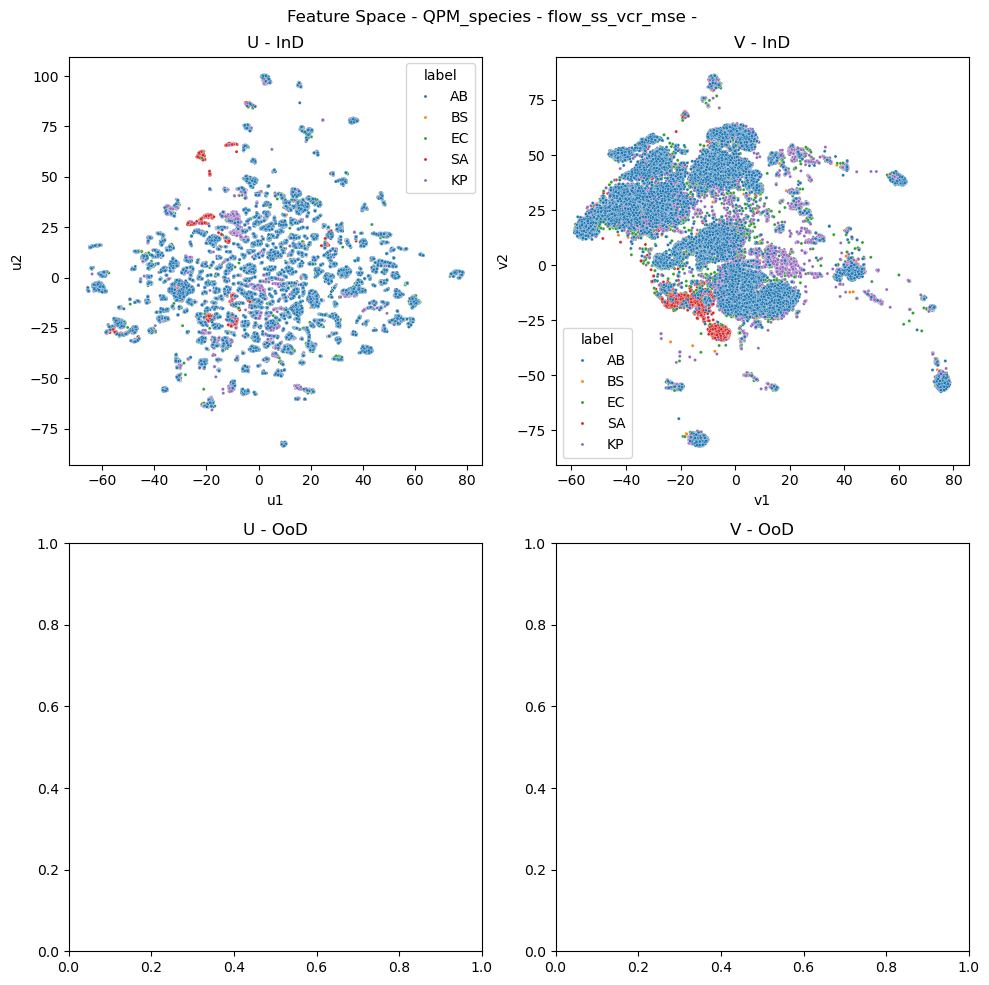

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
emb_data = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")

sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)

plt.tight_layout()
plt.show()

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:16<00:48, 16.23s/it]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:32<00:32, 16.20s/it]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:48<00:16, 16.25s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.44s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:05<00:00, 16.37s/it]

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▌                                                                         | 1/4 [01:43<05:09, 103.19s/it]

 50%|█████████████████████████████████████████████████                                                 | 2/4 [03:26<03:26, 103.42s/it]

 75%|█████████████████████████████████████████████████████████████████████████▌                        | 3/4 [05:10<01:43, 103.60s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:54<00:00, 103.88s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:54<00:00, 103.72s/it]

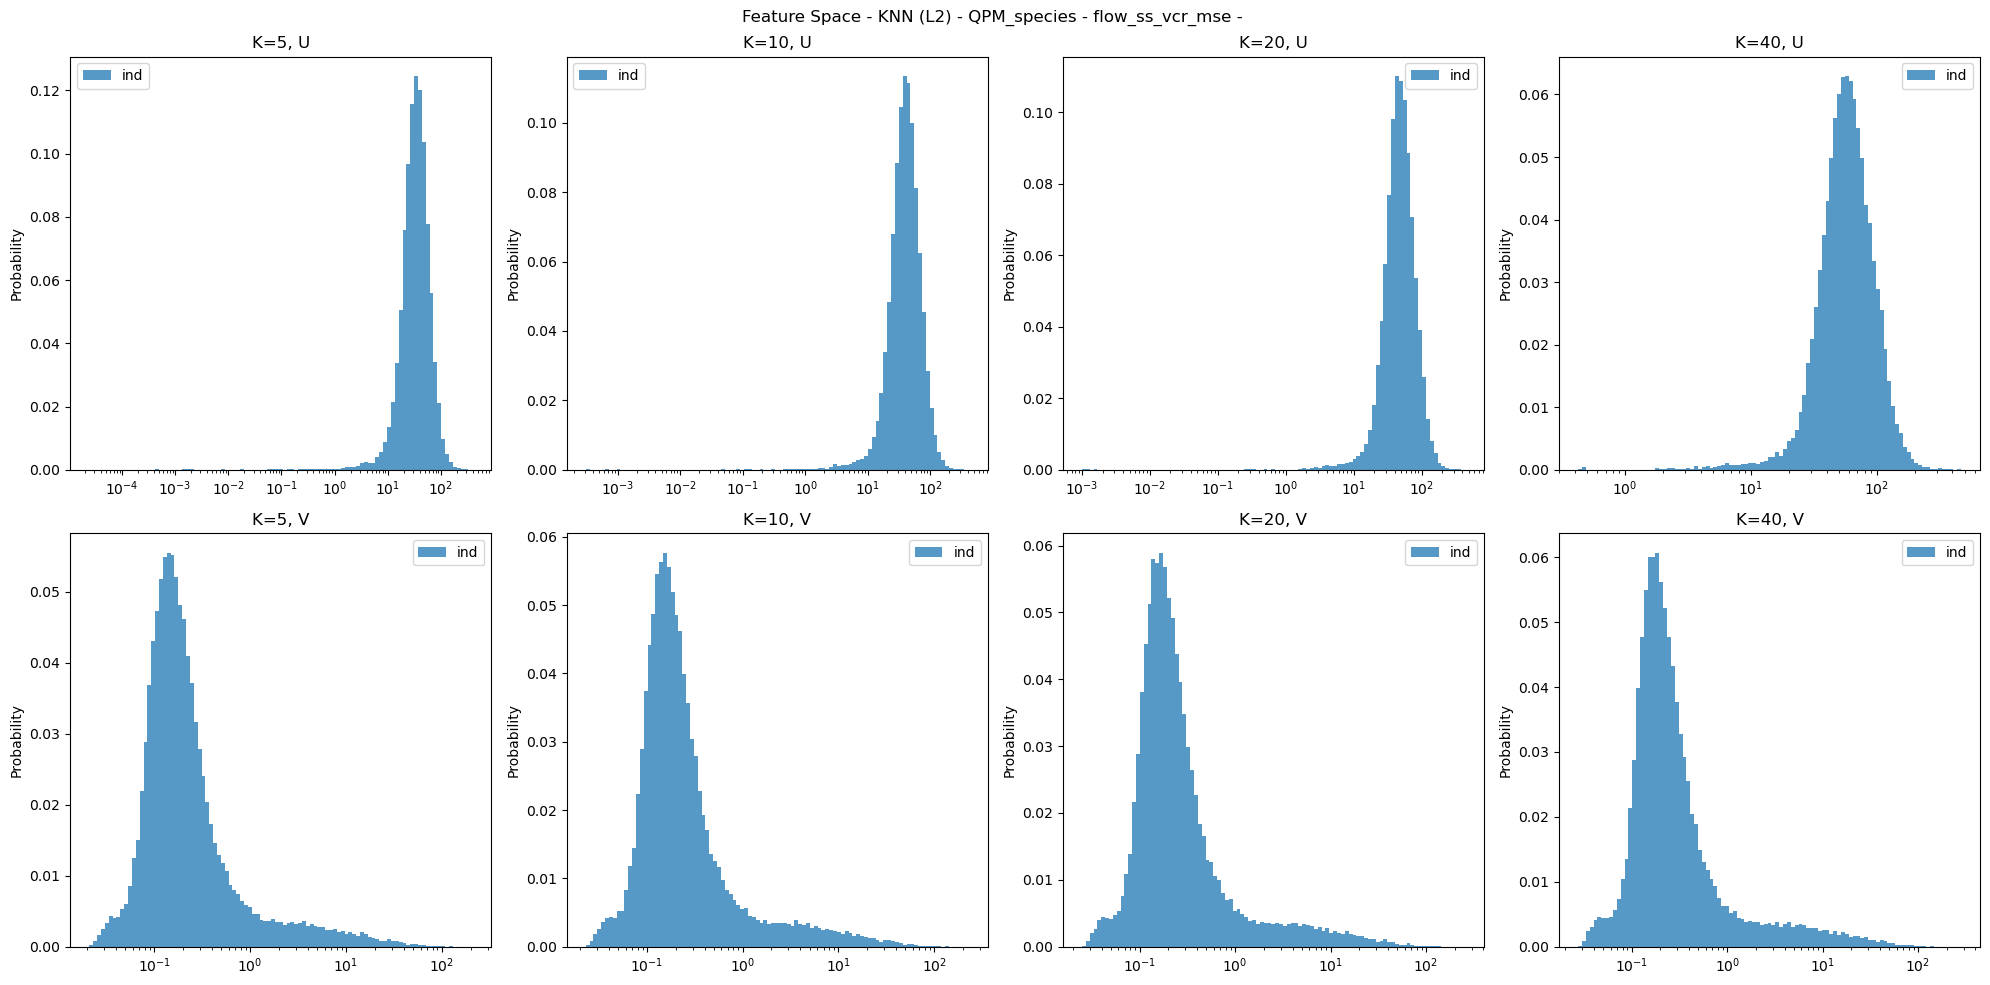

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatL2(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatL2(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:15<00:47, 15.86s/it]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:31<00:31, 15.89s/it]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:47<00:16, 16.01s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:04<00:00, 16.16s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:04<00:00, 16.08s/it]

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▌                                                                         | 1/4 [01:42<05:08, 102.76s/it]

 50%|█████████████████████████████████████████████████                                                 | 2/4 [03:25<03:25, 102.78s/it]

 75%|█████████████████████████████████████████████████████████████████████████▌                        | 3/4 [05:08<01:42, 102.97s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:52<00:00, 103.14s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:52<00:00, 103.04s/it]

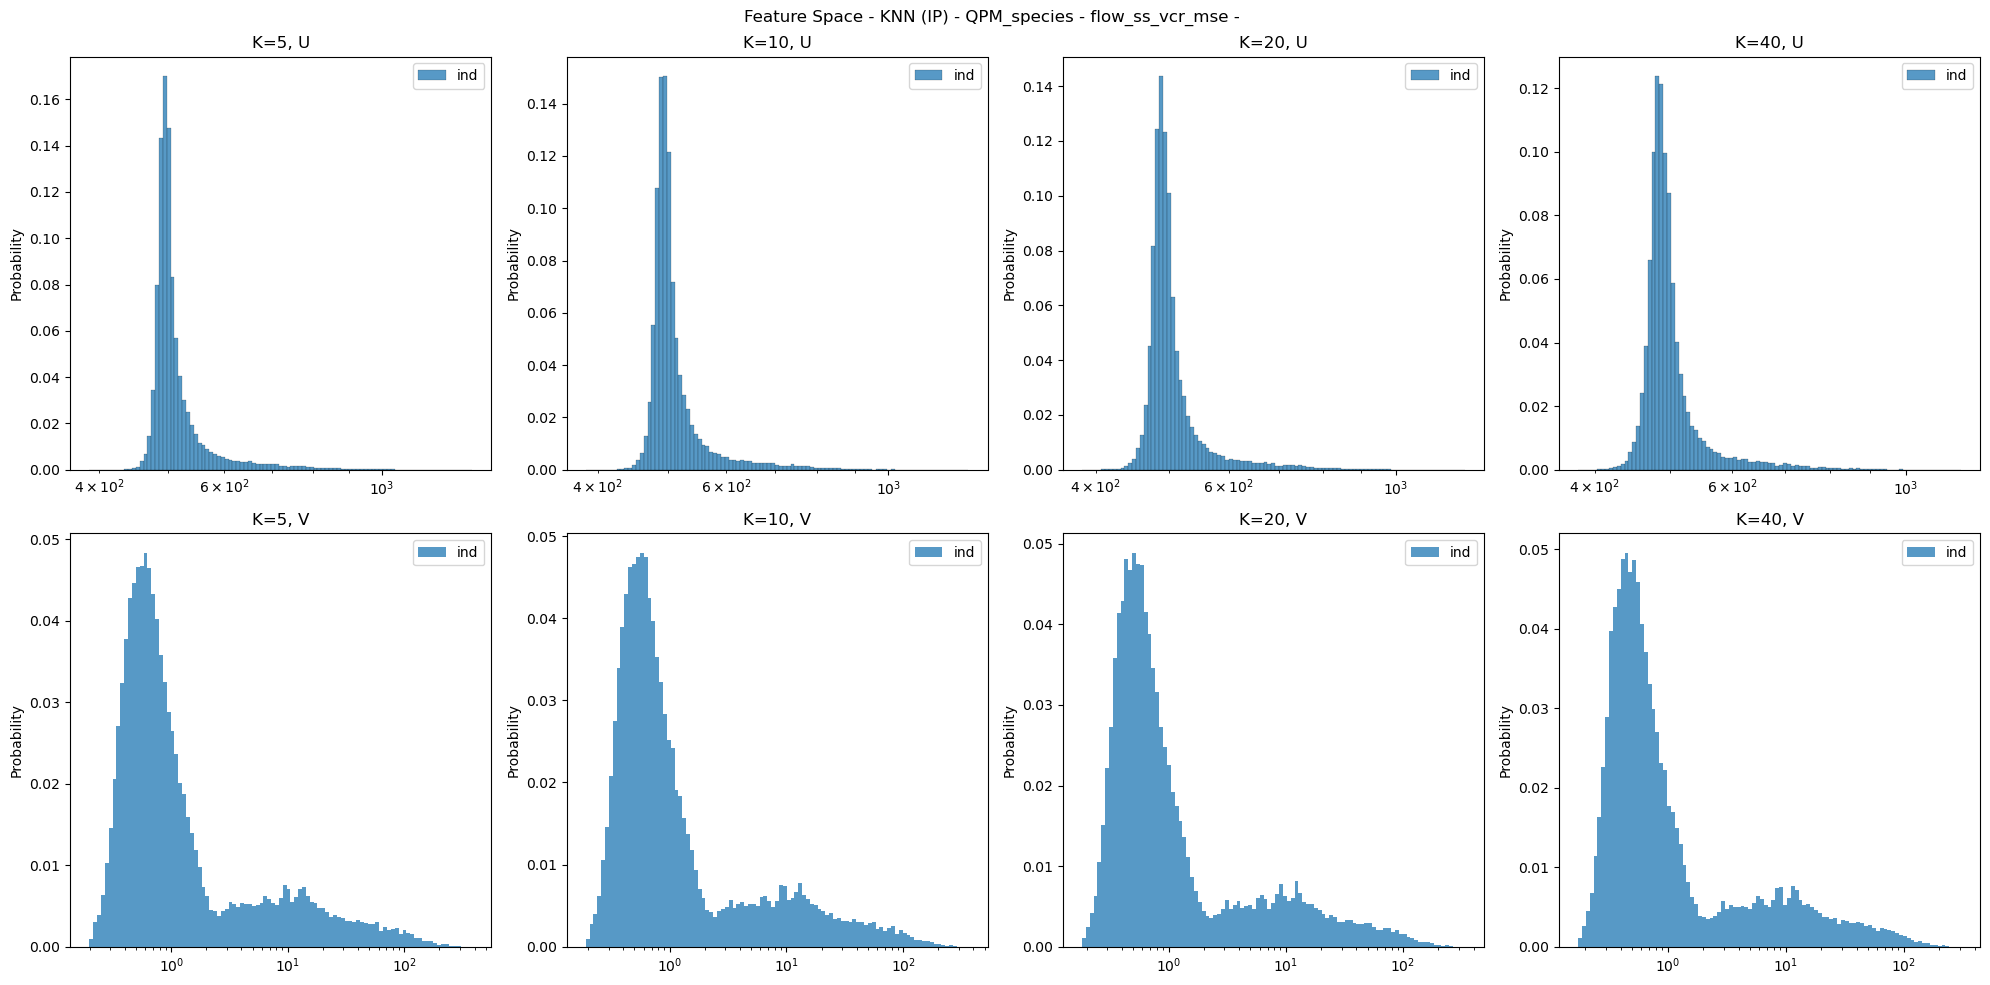

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatIP(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatIP(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.946756 0.901855 1.1398872 1.3923346
22.889229 0.81971514 1.0596985 1.2596536
22.995163 0.9976535 1.216509 1.5436974
36.078094 1.0400147 54.15554 0.7623262


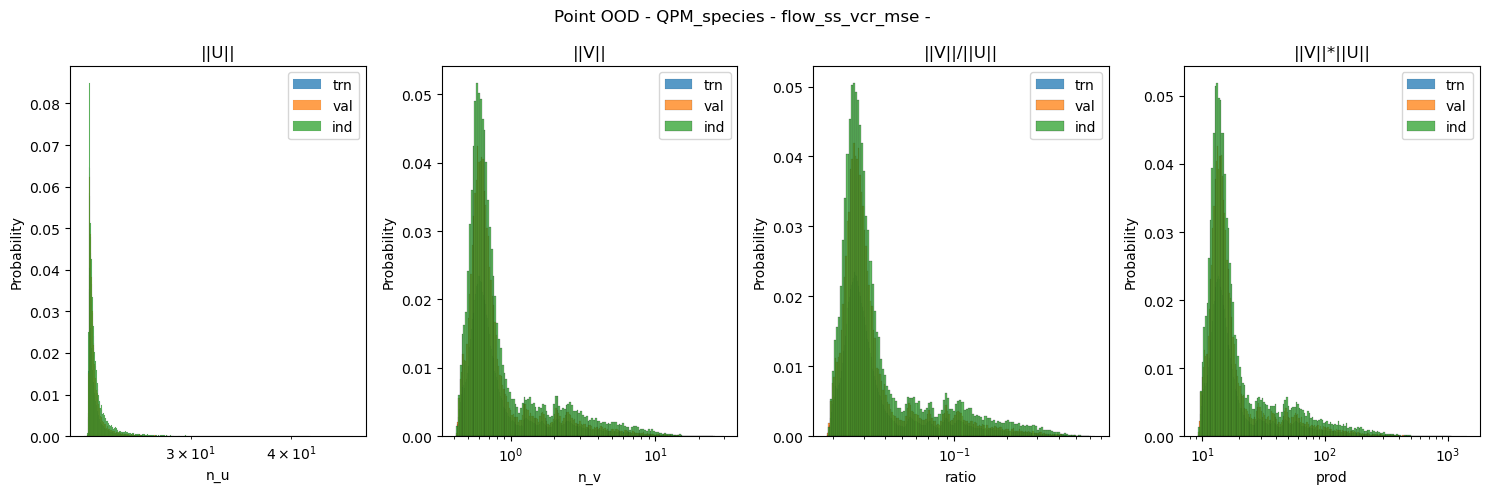

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='density', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


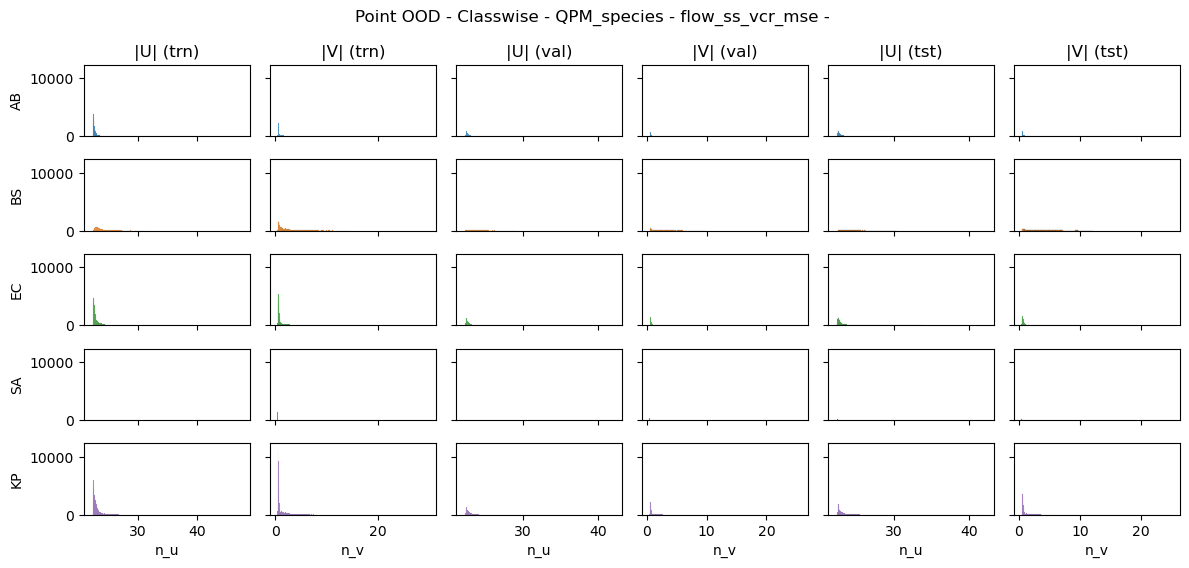

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

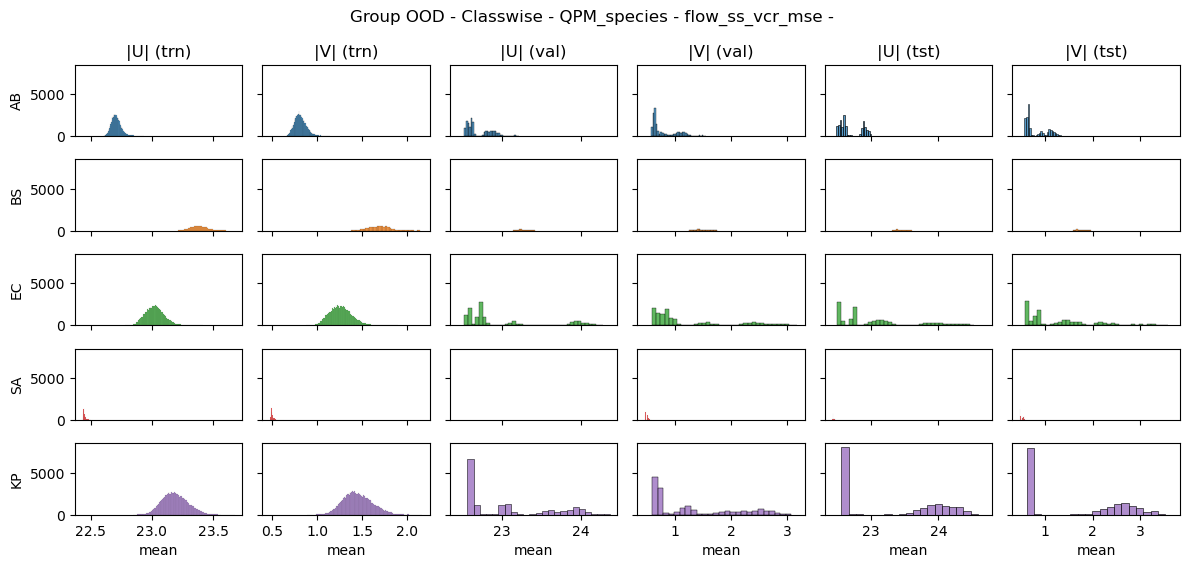

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()